# IMPORT LIBRARIES

In [2]:
import pandas as pd
import random
from pyomo.environ import *
import numpy as np
import time
import matplotlib.pyplot as plt


# IMPORT DATA

In [3]:
df = pd.read_csv(r'C:\Users\Matteo.Gabellini\OneDrive - Alma Mater Studiorum Università di Bologna\DOTTORATO\2.CONSULENZA\AZIENDE\MELONI\1.DATI\TABULAR\DatasetClean.csv')
df

Unnamed: 0  Num. Ordine Mese-Giorno  Articolo  \
0                 0       738378       04-18     20918   
1                 1       738379       04-18      3456   
2                 2       738379       04-18      7199   
3                 3       738379       04-18     43556   
4                 4       738379       04-18     50045   
...             ...          ...         ...       ...   
2447292     2447292       791134       12-29     92720   
2447293     2447293       791134       12-29     98819   
2447294     2447294       791134       12-29    105877   
2447295     2447295       791134       12-29    107171   
2447296     2447296       791140       12-30    107904   

                                      Descrizione  Pezzi ordinati  \
0         CAREFREE COTTON SALVASLIP 44 PZ.DISTESO               6   
1        STUDIO L.5 INVISI FIX GEL FOR.LIQ.150ml                6   
2        STUDIO L.8 FIX&FORCE GEL IPERFOR.150 ML.               6   
3         STUDIO L.9 INDESTRUC.GEL ESTREMO 150 ML               6   
4        STUDIO L.5 INVISI FIX GEL CR.FOR.VAS.150               6   
...                                           ...             ...   
2447292     CHANTECLAIR SGRASS.600 MLx2 PZ.LIMONE               1   
2447293    VIM GEL BAGNO 5in1 ANTICALCARE 1000 ML               1   
2447294  CIF CREMA GREEN ACTIVE 500 ML PINK BLOOM               1   
2447295      OMINO B.DET.IDROCAPS SALVAFIBRE 20pz               1   
2447296  ACE LAVAT.LIQ.27 LAVx3 PZ MELAeCANNELLA                2   

         Pezzi evasi  Pz x CT  Pz x TH  Volume pezzo  Volume cartone  \
0                  6       24        0      1.288000        33.96900   
1                  6        6        0      0.378000         2.66000   
2                  6        6        0      0.303750         2.94400   
3                  6        6        0      0.720000         2.81600   
4                  6        6        0      0.405000         2.54375   
...              ...      ...      ...           ...             ...   
2447292            1        6        0      3.271125        23.04000   
2447293            1       12        0      1.559250        25.63600   
2447294            1       16        0      0.728000        17.02400   
2447295            1        8        0      2.025000        20.46000   
2447296            2        1        0     10.620000        10.62000   

                  Ecr1               Ecr2                   Ecr3  \
0         Cura Persona  Igienico Sanitari             Assorbenti   
1         Cura Persona            Capelli        Styling Capelli   
2         Cura Persona            Capelli        Styling Capelli   
3         Cura Persona            Capelli        Styling Capelli   
4         Cura Persona            Capelli        Styling Capelli   
...                ...                ...                    ...   
2447292  Casa e Bucato          Superfici   Detergenti Superfici   
2447293  Casa e Bucato              Bagno  Detergenti Bagno e WC   
2447294  Casa e Bucato          Superfici   Detergenti Superfici   
2447295  Casa e Bucato             Bucato       Detersivi Bucato   
2447296  Casa e Bucato             Bucato       Detersivi Bucato   

                                Ecr4         Canale  Cliente  PV  Percorso  
0           Salvaslip e Proteggislip  Piume Diretti  2104490  SM        26  
1                 Gel e Cere Capelli  Piume Diretti  2104490  SM        26  
2                 Gel e Cere Capelli  Piume Diretti  2104490  SM        26  
3                 Gel e Cere Capelli  Piume Diretti  2104490  SM        26  
4                 Gel e Cere Capelli  Piume Diretti  2104490  SM        26  
...                              ...            ...      ...  ..       ...  
2447292                  Sgrassatori            B2C  2152842  UD       999  
2447293             Detergenti Bagno            B2C  2152842  UD       999  
2447294          Detergenti Multiuso            B2C  2152842  UD       999  
2447295  Detersivi Capsule Lava

# DEFINE FUNCTIONS

In [4]:
def initial_population(gene_space, num_genes, sol_per_pop):
    """
    Generate an initial random population.
    
    Each individual is a vector of length `num_genes`, where each gene is chosen from `gene_space`.
    
    Parameters:
        gene_space (list or array): Possible gene values.
        num_genes (int): Number of genes per individual.
        sol_per_pop (int): Number of individuals (solutions) in the population.
    
    Returns:
        np.ndarray: Population array of shape (sol_per_pop, num_genes).
    """
    return np.random.choice(gene_space, size=(sol_per_pop, num_genes))

In [5]:
gene_space = [0,1]
num_genes = df['Articolo'].nunique()
sol_per_pop = 4
population = initial_population(gene_space = gene_space, num_genes=num_genes, sol_per_pop=sol_per_pop)
population

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 1]])

In [6]:
def fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor,fitness_type = 'BASE'):
    """
    Compute fitness and unfitness for each individual in the population.
    
    **Fitness Calculation:**
      - For each individual, create an allocation DataFrame mapping unique 'Articolo' values
        to the individual's warehouse assignment.
      - Merge this allocation with the input DataFrame (which must contain columns 'Articolo'
        and 'Num. Ordine').
      - For each order, compute the number of transitions between warehouses (from 1 to 0 and 0 to 1).
      - The fitness is the sum of all transitions.
    
    **Unfitness Calculation:**
      - Compute the total stock assigned to Warehouse A (assignment 1) and Warehouse B (assignment 0).
      - If a warehouse's capacity is exceeded, add a penalty proportional to the excess.
    
    Parameters:
        population (np.ndarray): Array of individuals (shape: sol_per_pop x num_genes).
        stock (np.ndarray): Array of stock values associated with each 'Articolo'.
        capacity_A (float): Capacity for Warehouse A.
        capacity_B (float): Capacity for Warehouse B.
        df (pd.DataFrame): DataFrame containing order information; must include 'Articolo' and 'Num. Ordine'.
        penalty_factor (float): Penalty multiplier for capacity violations.
    
    Returns:
        tuple: Two NumPy arrays: (population_fitness, population_unfitness)
    """
    fitness_list = []
    unfitness_list = []
    unique_articles = df['Articolo'].unique()
    
    for individual in population:
        # Map each unique article to its warehouse assignment from the individual.
        df_allocation = pd.DataFrame({'Articolo': unique_articles, 'Warehouse': individual})
        # Merge the allocation with the main DataFrame.
        df_merged = pd.merge(df, df_allocation, on='Articolo', how='left')
        
        if fitness_type == 'BASE':
            
            individual_fitness = df_merged.groupby('Num. Ordine')['Warehouse'].nunique().sum() - df['Num. Ordine'].nunique()

        else:
        
            # Compute transitions within each order.
            df_merged['prev_warehouse'] = df_merged.groupby('Num. Ordine')['Warehouse'].shift(1)
            df_merged['transition_0_after_1'] = ((df_merged['prev_warehouse'] == 1) & (df_merged['Warehouse'] == 0)).astype(int)
            df_merged['transition_1_after_0'] = ((df_merged['prev_warehouse'] == 0) & (df_merged['Warehouse'] == 1)).astype(int)
            result = df_merged.groupby('Num. Ordine')[['transition_0_after_1', 'transition_1_after_0']].sum()
            individual_fitness = result.sum().sum()
            
        fitness_list.append(individual_fitness)
        
        # Calculate total stock for each warehouse.
        total_A = np.sum(individual * stock)
        total_B = np.sum((1 - individual) * stock)
        penalty = 0
        if total_A > capacity_A:
            penalty += penalty_factor * (total_A - capacity_A)
        if total_B > capacity_B:
            penalty += penalty_factor * (total_B - capacity_B)
        unfitness_list.append(penalty)
        
    return np.array(fitness_list), np.array(unfitness_list)

In [7]:
# stock = np.ones(num_genes) 
stock = np.zeros(num_genes)
# capacity_A = 0 
# capacity_B = 0 
capacity_A = 999999999999999
capacity_B = 999999999999999
penalty_factor = 1

In [8]:
population_fitness, population_unfitness = fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor)
population_fitness, population_unfitness

(array([59532, 59618, 59645, 59447], dtype=int64), array([0, 0, 0, 0]))

In [9]:
# 3. PARENT SELECTION CRITERIA
def ParentSelection(population, sol_per_pop, population_fitness, population_unfitness):
    """
    Select two parents using tournament selection.
    
    Four unique individuals are chosen at random. Among the first two candidates, the one with
    lower fitness is chosen as the first parent. Similarly, among the next two, the one with lower
    fitness is chosen as the second parent.
    
    Parameters:
        population (np.ndarray): Population array.
        sol_per_pop (int): Total number of individuals in the population.
        population_fitness (np.ndarray): Fitness values for the population.
        population_unfitness (np.ndarray): Unfitness values for the population (not used here).
    
    Returns:
        tuple: Two parents (each a 1D numpy array).
    """
    random_indices = np.random.choice(np.arange(sol_per_pop), 4, replace=False)
    # print('random_indices',random_indices)
    
    # Compare first two candidates.
    if population_fitness[random_indices[0]] >= population_fitness[random_indices[1]]:
        first_parent = population[random_indices[1]]
    else:
        first_parent = population[random_indices[0]]
    
    # Compare the next two candidates.
    if population_fitness[random_indices[2]] >= population_fitness[random_indices[3]]:
        second_parent = population[random_indices[2]]
    else:
        second_parent = population[random_indices[3]]
    
    return first_parent, second_parent

In [10]:
parent1, parent2 = ParentSelection(population, sol_per_pop, population_fitness, population_unfitness)
parent1, parent2

(array([1, 1, 0, ..., 1, 0, 0]), array([1, 1, 0, ..., 0, 1, 0]))

In [11]:
def child_generation(parent1, parent2):
    """
    Generate a child individual via one-point crossover followed by a mutation.
    
    **Crossover:** A random crossover index is selected, and the child's genes are taken 
    from parent1 up to this index and from parent2 thereafter.
    
    **Mutation:** Two random positions in the child's gene sequence are swapped.
    
    Parameters:
        parent1 (np.ndarray): First parent's gene sequence.
        parent2 (np.ndarray): Second parent's gene sequence.
    
    Returns:
        np.ndarray: The generated child individual.
    """
    child = parent2.copy()
    crossover_index = random.randint(1, len(parent1) - 1)
    child[:crossover_index] = parent1[:crossover_index]
    
    # Mutation: Swap two random indices.
    mutation_indices = np.random.choice(len(child), size=2, replace=False)
    child[mutation_indices[0]], child[mutation_indices[1]] = child[mutation_indices[1]], child[mutation_indices[0]]
    
    return child

In [12]:
parent1

array([1, 1, 0, ..., 1, 0, 0])

In [13]:
parent2

array([1, 1, 0, ..., 0, 1, 0])

In [14]:
child = child_generation(parent1 = parent1, parent2=parent2)
child

array([1, 1, 0, ..., 0, 1, 0])

In [15]:
#2.COMPUTE FITNESS AND UNFITNESS
def update_fitness_unfitness_func(population, df, stock, population_fitness, population_unfitness, child, worse_individual_index,fitness_type = 'BASE'):
    

    #CHILD IMPROVEMENT

    

    #FITNESS FUNCTION


    unique_articles = df['Articolo'].unique()
    df_allocation = pd.DataFrame({'Articolo': unique_articles, 'Warehouse': child})
    # Merge the allocation with the main DataFrame.
    df_merged = pd.merge(df, df_allocation, on='Articolo', how='left')
    
    if fitness_type == 'BASE':
        
        new_individual_fitness = df_merged.groupby('Num. Ordine')['Warehouse'].nunique().sum() - df['Num. Ordine'].nunique()

    else:
    
        # Compute transitions within each order.
        df_merged['prev_warehouse'] = df_merged.groupby('Num. Ordine')['Warehouse'].shift(1)
        df_merged['transition_0_after_1'] = ((df_merged['prev_warehouse'] == 1) & (df_merged['Warehouse'] == 0)).astype(int)
        df_merged['transition_1_after_0'] = ((df_merged['prev_warehouse'] == 0) & (df_merged['Warehouse'] == 1)).astype(int)
        result = df_merged.groupby('Num. Ordine')[['transition_0_after_1', 'transition_1_after_0']].sum()
        new_individual_fitness = result.sum().sum()
    
    population_fitness[worse_individual_index] = new_individual_fitness.reshape(1)

    #UNFITNESS FUNCTION

    total_A = np.sum(child * stock)
    total_B = np.sum((1 - child) * stock)
    penalty = 0
    if total_A > capacity_A:
        penalty += penalty_factor * (total_A - capacity_A)
    if total_B > capacity_B:
        penalty += penalty_factor * (total_B - capacity_B)

    new_individual_unfitness = penalty

    population_unfitness[worse_individual_index] = new_individual_unfitness

    return population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness



In [16]:
def new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor):
    """
    Update the population by replacing the worst individual with the new child.
    
    If all individuals have zero unfitness, the worst is determined by the highest fitness;
    otherwise, the worst is determined by the highest unfitness.
    
    After replacement, the fitness and unfitness of the entire population are re-calculated.
    
    Parameters:
        population (np.ndarray): Current population.
        child (np.ndarray): New child individual.
        stock (np.ndarray): Stock values.
        capacity_A (float): Capacity for Warehouse A.
        capacity_B (float): Capacity for Warehouse B.
        population_fitness (np.ndarray): Fitness values for the population.
        population_unfitness (np.ndarray): Unfitness values for the population.
        df (pd.DataFrame): DataFrame containing order information.
        penalty_factor (float): Penalty multiplier.
    
    Returns:
        tuple: Updated (population, population_fitness, population_unfitness,
                best_individual, best_individual_fitness, best_individual_unfitness).
    """
    if np.all(population_unfitness == 0):
        worse_individual_index = np.argmax(population_fitness)
    else:
        worse_individual_index = np.argmax(population_unfitness)
    
    population[worse_individual_index] = child

    population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness  = update_fitness_unfitness_func(population, df, stock, population_fitness, population_unfitness, child, worse_individual_index,fitness_type = 'BASE')

    
    best_idx = np.argmin(population_fitness)
    best_individual = population[best_idx]
    best_individual_fitness = population_fitness[best_idx]
    best_individual_unfitness = population_unfitness[best_idx]
    
    return population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness

In [17]:
population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness = new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor)
population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness

(array([[1, 1, 0, ..., 1, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 0, 1, 1]]),
 array([59532, 59618, 59688, 59447], dtype=int64),
 array([0, 0, 0, 0]),
 59688,
 0,
 array([1, 0, 1, ..., 0, 1, 1]),
 59447,
 0)

In [18]:
# 6. MAIN GENETIC ALGORITHM LOOP WITH PLOTTING EVERY MINUTE ON DUAL Y-AXES
def main(day, gene_space, num_genes, sol_per_pop, df, stock, capacity_A, capacity_B, M, penalty_factor):
    non_improving_iteration = 0
    iteration = 0
    child_list = []
    start_time = time.time()
    last_plot_time = start_time  # Initialize last plot time
    
    # History lists.
    fitness_history = []
    unfitness_history = []
    iterations = []
    A_code_history = []
    B_code_history = []
    
    # INITIAL POPULATION
    population = initial_population(gene_space, num_genes, sol_per_pop)
    population_fitness, population_unfitness = fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor)
    
    while non_improving_iteration < M and (time.time() - start_time) < 8 * 60 * 60:
        iteration += 1
        
        # PARENT SELECTION.
        first_parent, second_parent = ParentSelection(population, sol_per_pop, population_fitness, population_unfitness)
        
        # CHILD GENERATION.
        child = child_generation(first_parent, second_parent)
        
        # POPULATION UPDATE.
        (population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness) = new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor)

        #VISUALIZE NUMBER OF CODE PER WAREHOUSE 
        unique_articles = df['Articolo'].unique()
        df_allocation = pd.DataFrame({'Articolo': unique_articles, 'Warehouse': best_individual})
        df_merged = pd.merge(df, df_allocation, on='Articolo', how='left')
        A_code = list(df_merged.groupby('Warehouse')['Articolo'].nunique())[0]
        B_code = df_merged['Articolo'].nunique() - list(df_merged.groupby('Warehouse')['Articolo'].nunique())[0]
        
        # Record history.
        fitness_history.append(best_individual_fitness)
        unfitness_history.append(best_individual_unfitness)
        iterations.append(iteration)
        A_code_history.append(A_code)
        B_code_history.append(B_code)
        
        # Plot every 60 seconds on the same figure with two y-axes.
        current_time = time.time()
        if current_time - last_plot_time >= 10:
            # Assume the following lists have been populated during the algorithm:
            # iterations, fitness_history, unfitness_history, A_code_history, B_code_history
            
            fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Left subplot: Fitness and Unfitness Evolution
            # Plot best fitness on the primary y-axis.
            ax_left.plot(iterations, fitness_history, 'o-', color='blue', label='Best Fitness')
            ax_left.set_xlabel('Iteration')
            ax_left.set_ylabel('Best Fitness', color='blue')
            ax_left.tick_params(axis='y', labelcolor='blue')
            # Create a twin y-axis to plot best unfitness.
            ax_left_right = ax_left.twinx()
            ax_left_right.plot(iterations, unfitness_history, 'o-', color='red', label='Best Unfitness')
            ax_left_right.set_ylabel('Best Unfitness', color='red')
            ax_left_right.tick_params(axis='y', labelcolor='red')
            ax_left.set_title("Evolution of Fitness and Unfitness")
            ax_left.grid(True)
            
            # Right subplot: Code A and Code B Evolution
            # Plot Code A on the primary y-axis.
            ax_right.plot(iterations, A_code_history, 'o-', color='green', label='Code A')
            ax_right.set_xlabel('Iteration')
            ax_right.set_ylabel('Code A', color='green')
            ax_right.tick_params(axis='y', labelcolor='green')
            # Create a twin y-axis to plot Code B.
            ax_right_right = ax_right.twinx()
            ax_right_right.plot(iterations, B_code_history, 'o-', color='purple', label='Code B')
            ax_right_right.set_ylabel('Code B', color='purple')
            ax_right_right.tick_params(axis='y', labelcolor='purple')
            ax_right.set_title("Evolution of Code A and Code B")
            ax_right.grid(True)
            
            fig.tight_layout()
            plt.show()
    
            last_plot_time = current_time
        
        # Check for duplicate child.
        if list(child) in child_list:
            non_improving_iteration += 1
        else:
            non_improving_iteration = 0
            child_list.append(list(child))
    
    computational_time = time.time() - start_time
    
    # Final plot after the loop finishes on dual y-axes.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(iterations, fitness_history, 'o-', label='Best Fitness', color='blue')
    ax2.plot(iterations, unfitness_history, 'o-', label='Best Unfitness', color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best Fitness', color='blue')
    ax2.set_ylabel('Best Unfitness', color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title("Final Evolution of Best Individual's Fitness and Unfitness")
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    return population, population_fitness, population_unfitness, computational_time

## ALLOCATION

In [19]:
df_allocation = pd.DataFrame({'Articolo': df['Articolo'].unique()})
df_allocation['Warehouse'] = best_individual
df_allocation

Articolo  Warehouse
0         20918          1
1          3456          0
2          7199          1
3         43556          1
4         50045          1
...         ...        ...
18655     75927          1
18656    103566          0
18657    107026          0
18658    107496          1
18659    107376          1

[18660 rows x 2 columns]

In [20]:
df_allocation.groupby('Warehouse')['Articolo'].nunique()

Warehouse
0    9372
1    9288
Name: Articolo, dtype: int64

In [24]:
gene_space = [0,1]
num_genes = df['Articolo'].nunique()
sol_per_pop = 50
penalty_factor = 1
M = 100

stock = np.ones(num_genes) # np.random.randint(0, 100, num_genes)
capacity_A = stock.sum() * 0.7
capacity_B = stock.sum() *0.3

# stock = np.zeros(num_genes)
# capacity_A = 999999999999999
# capacity_B = 999999999999999

In [25]:
stock.sum(),capacity_A,capacity_B

(18660.0, 13062.0, 5598.0)

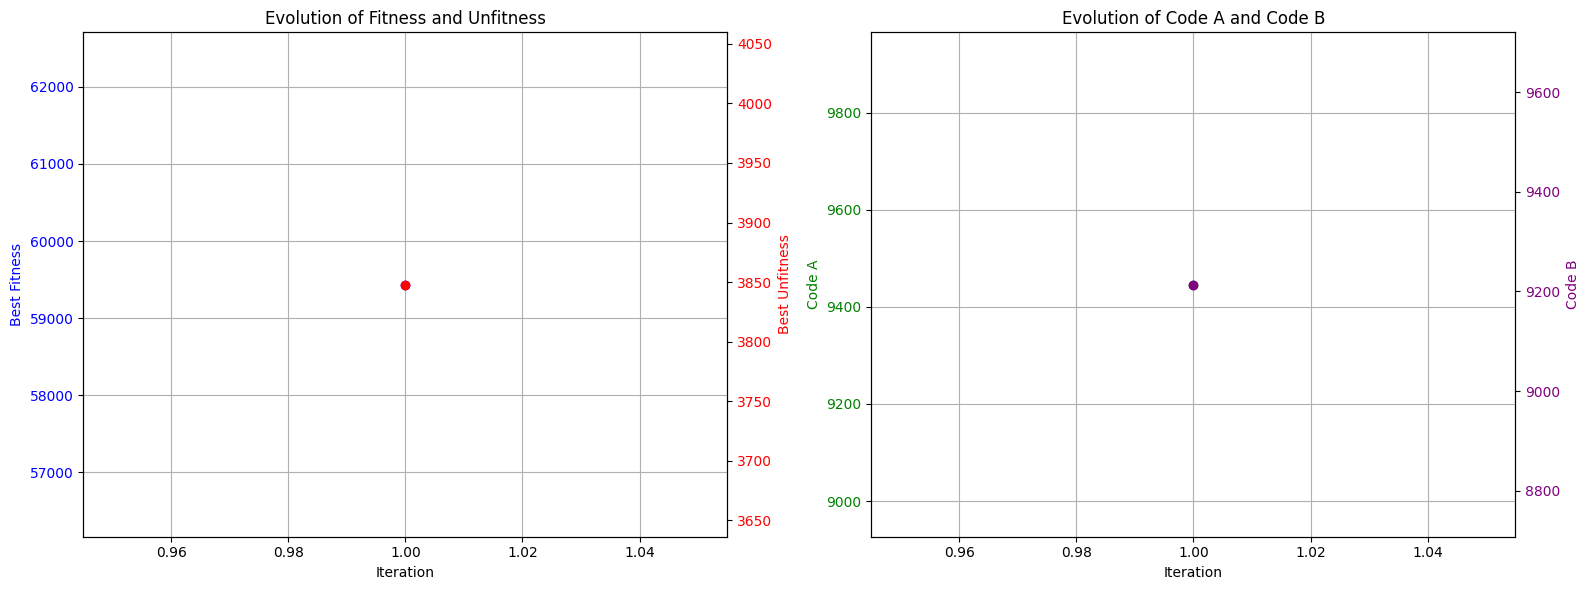

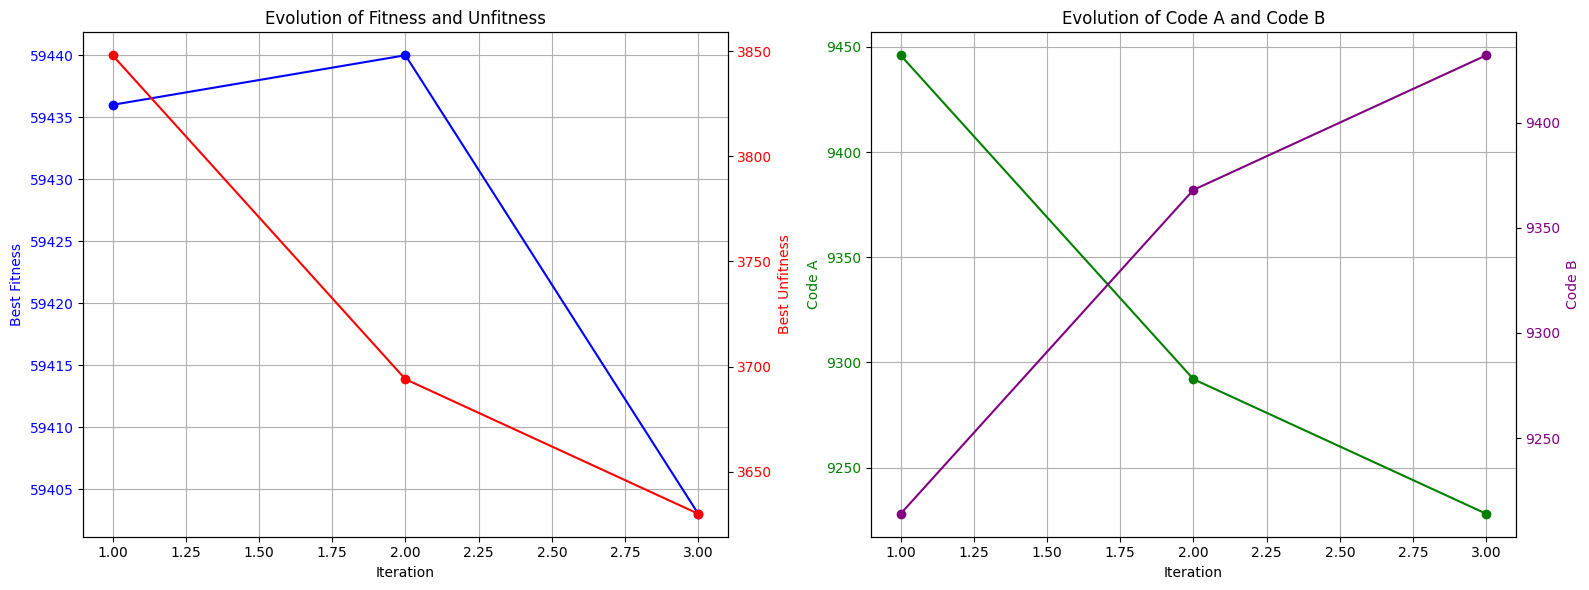

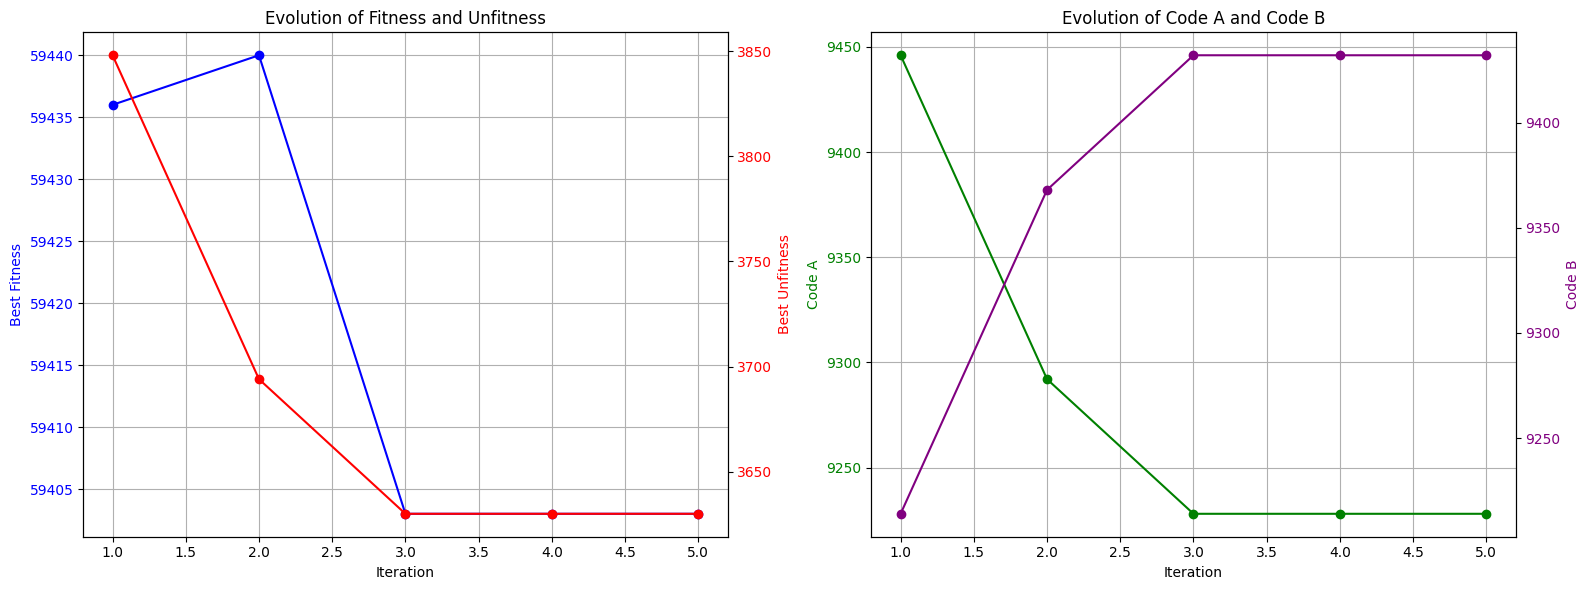

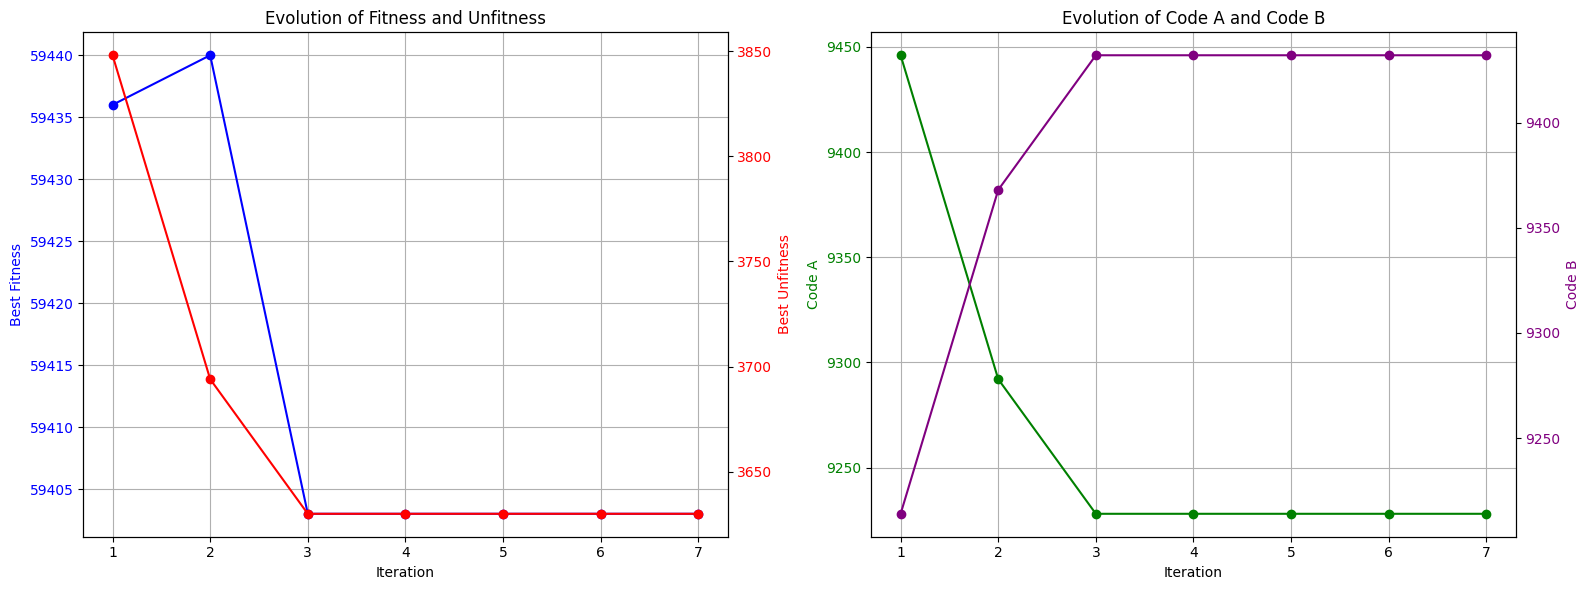

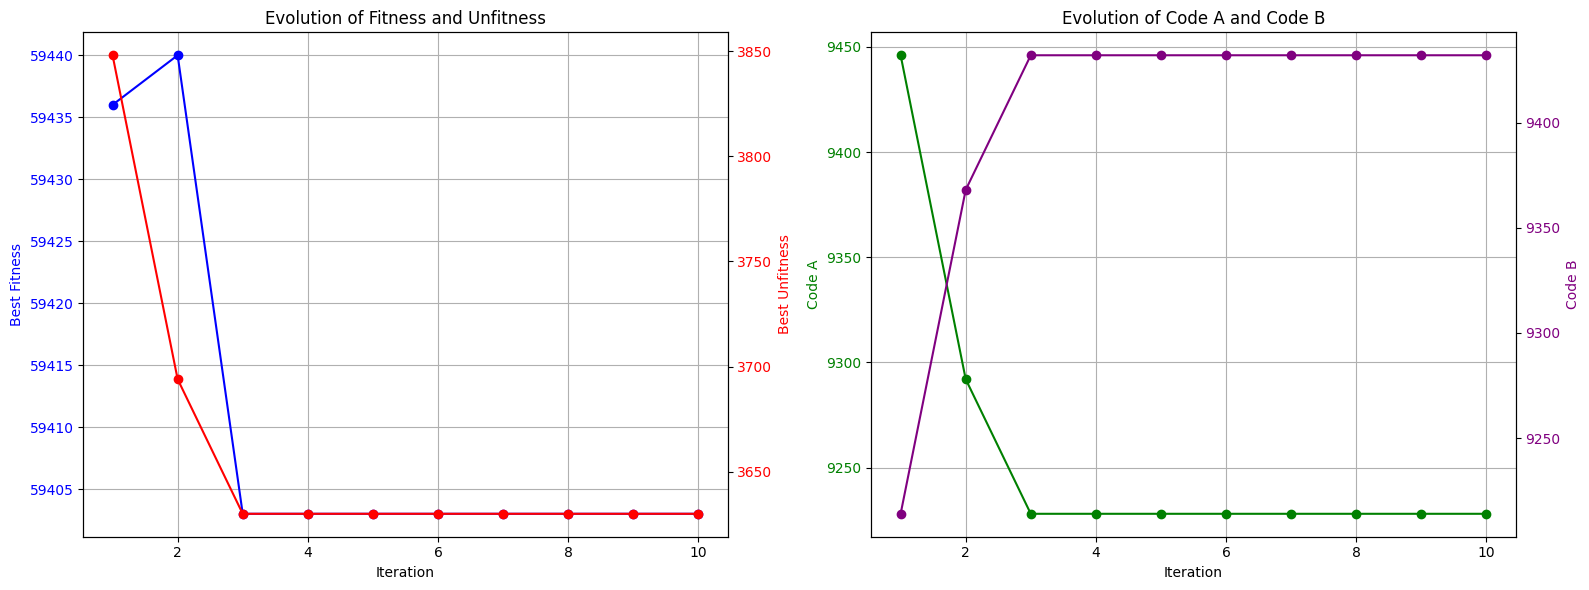

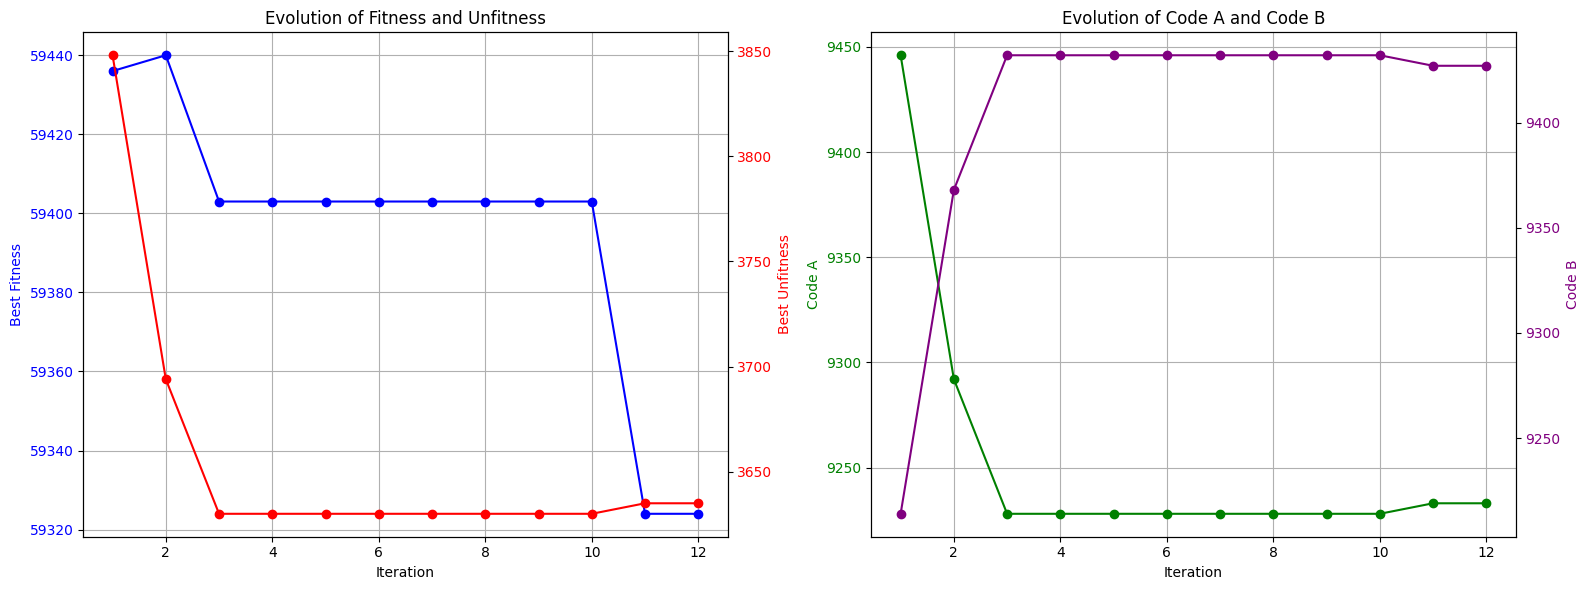

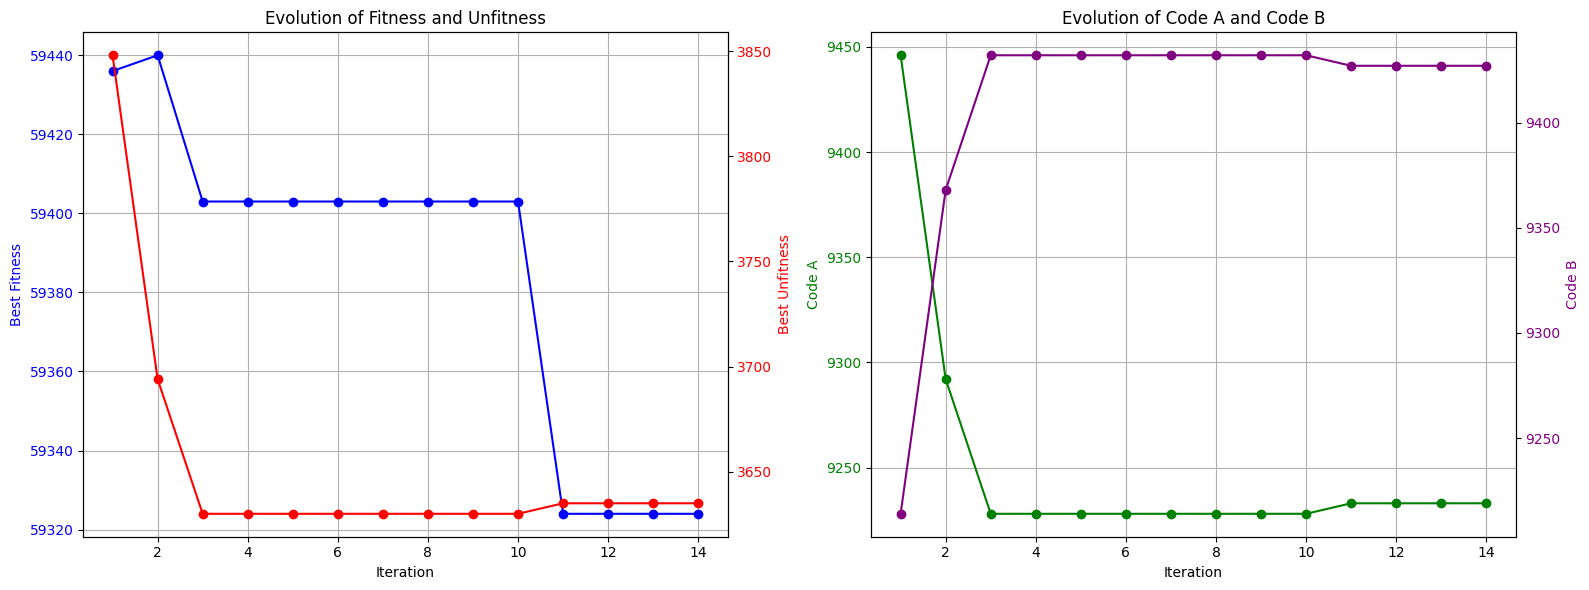

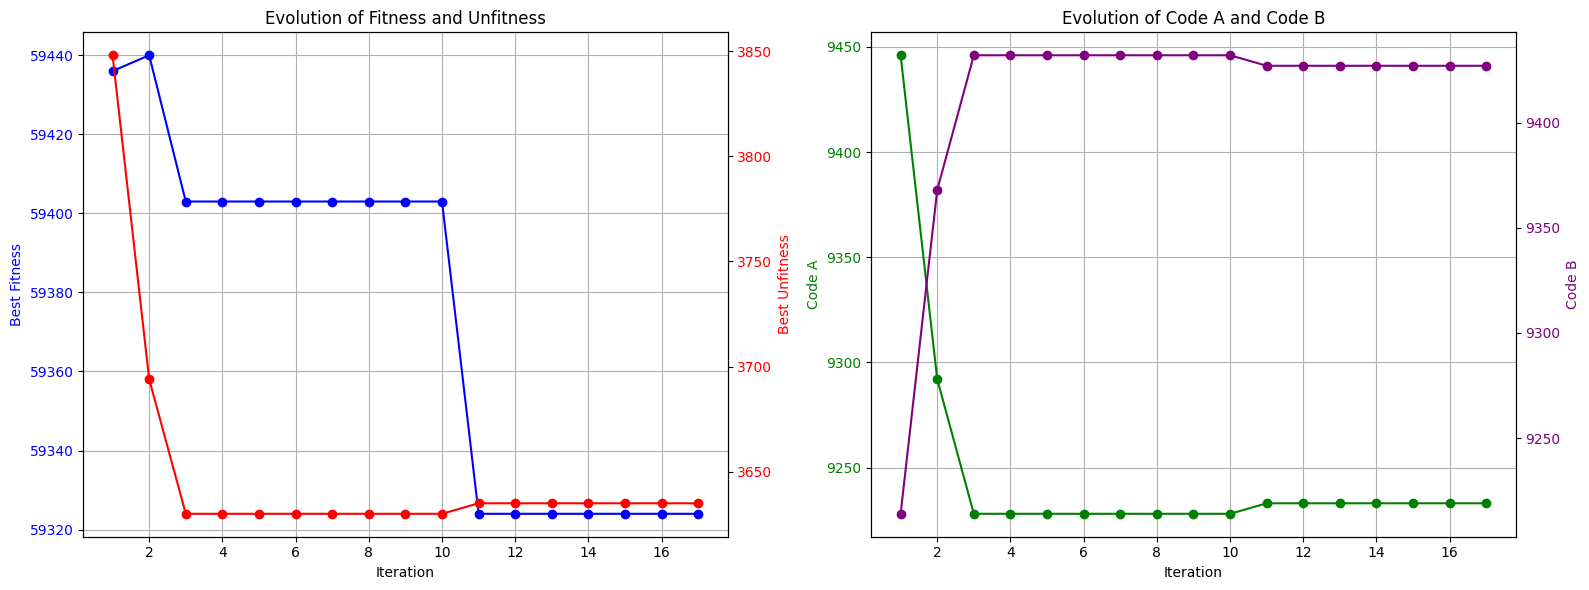

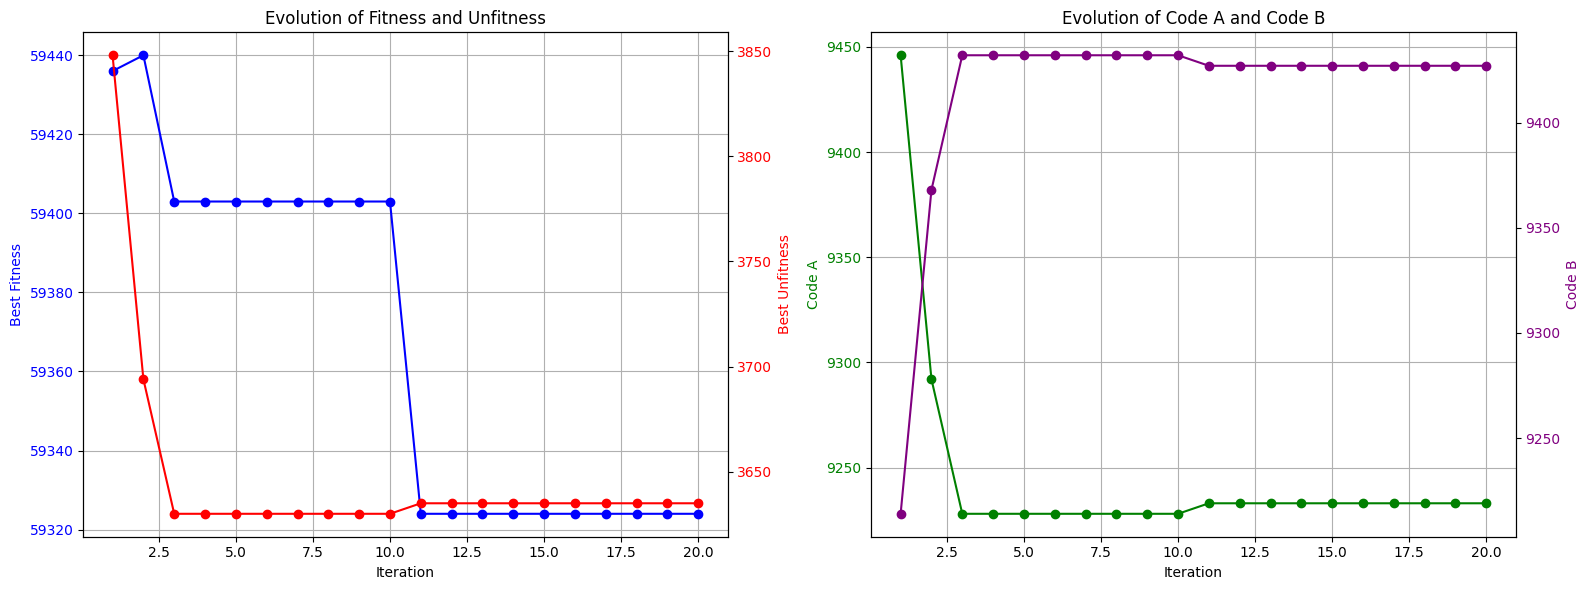

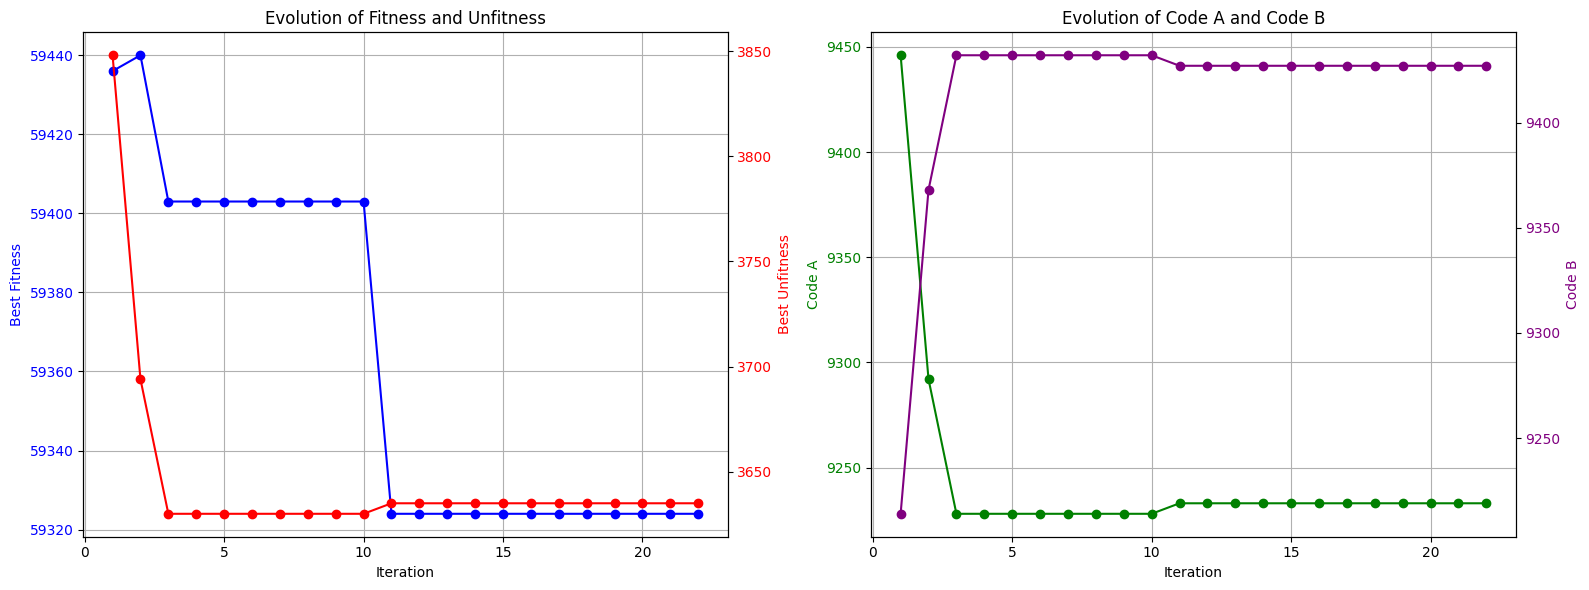

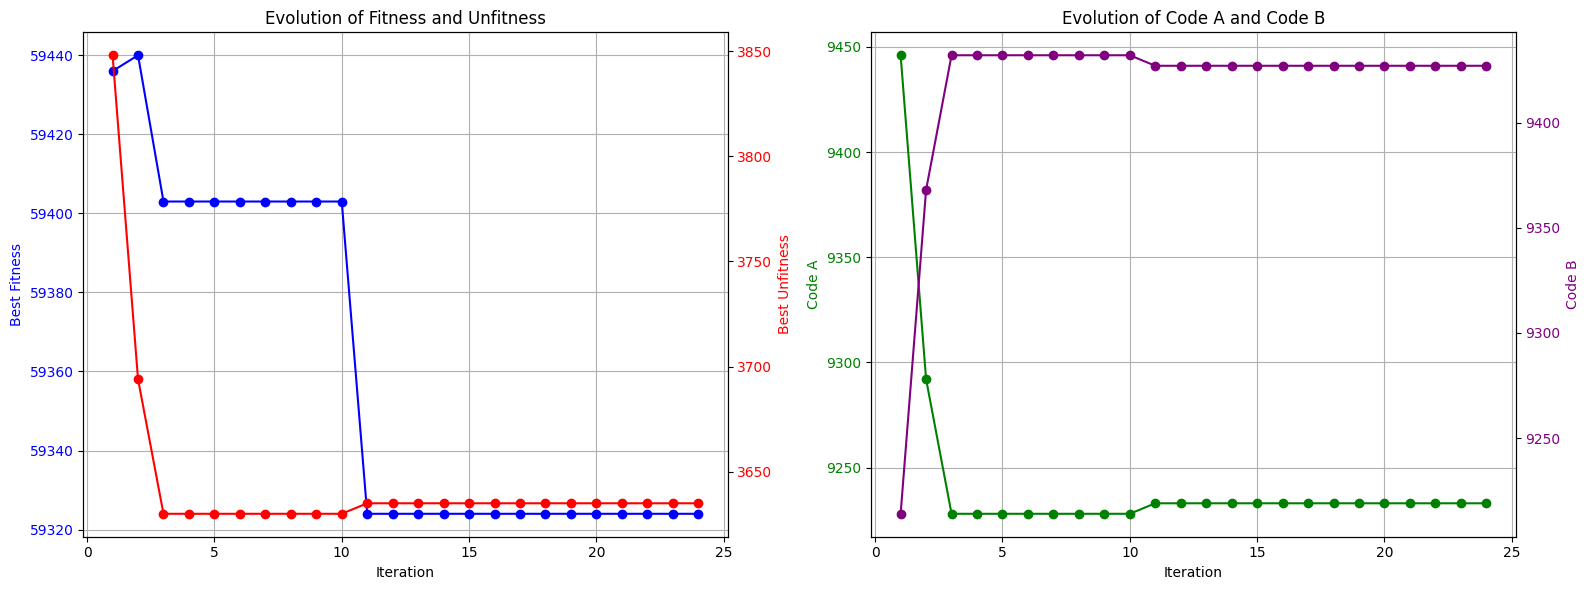

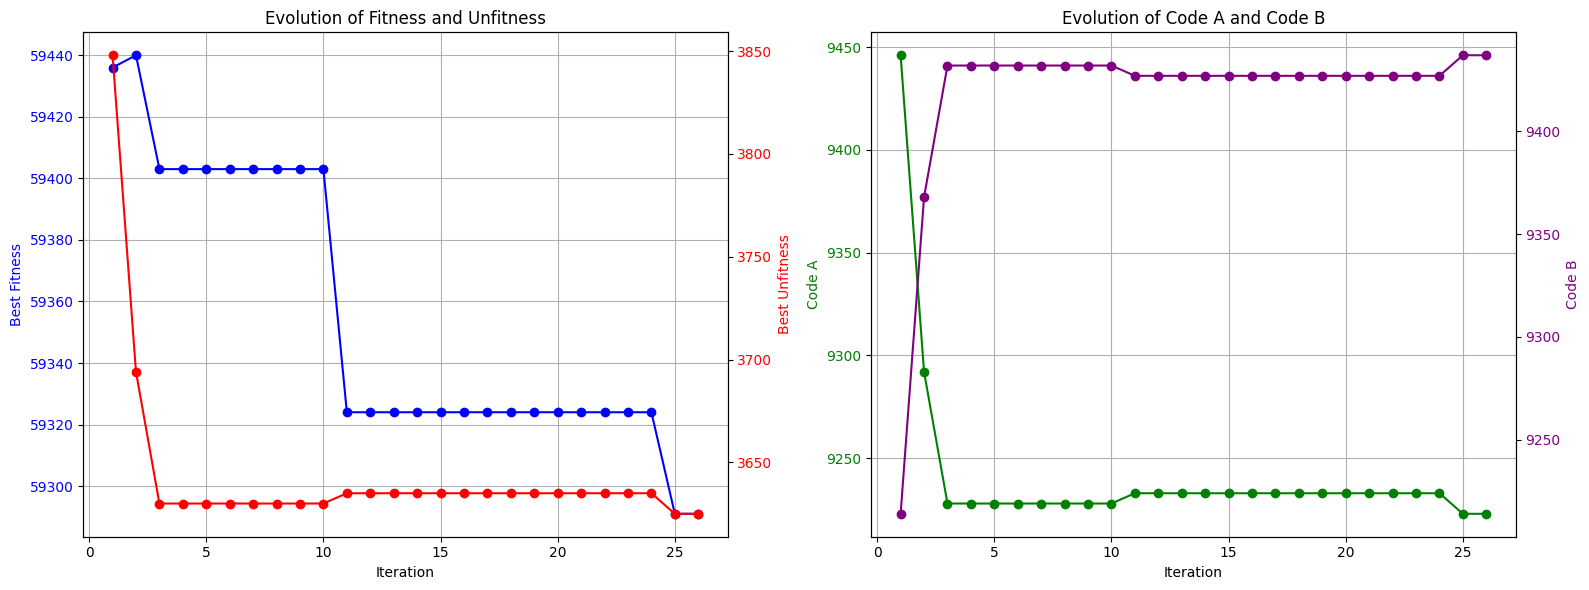

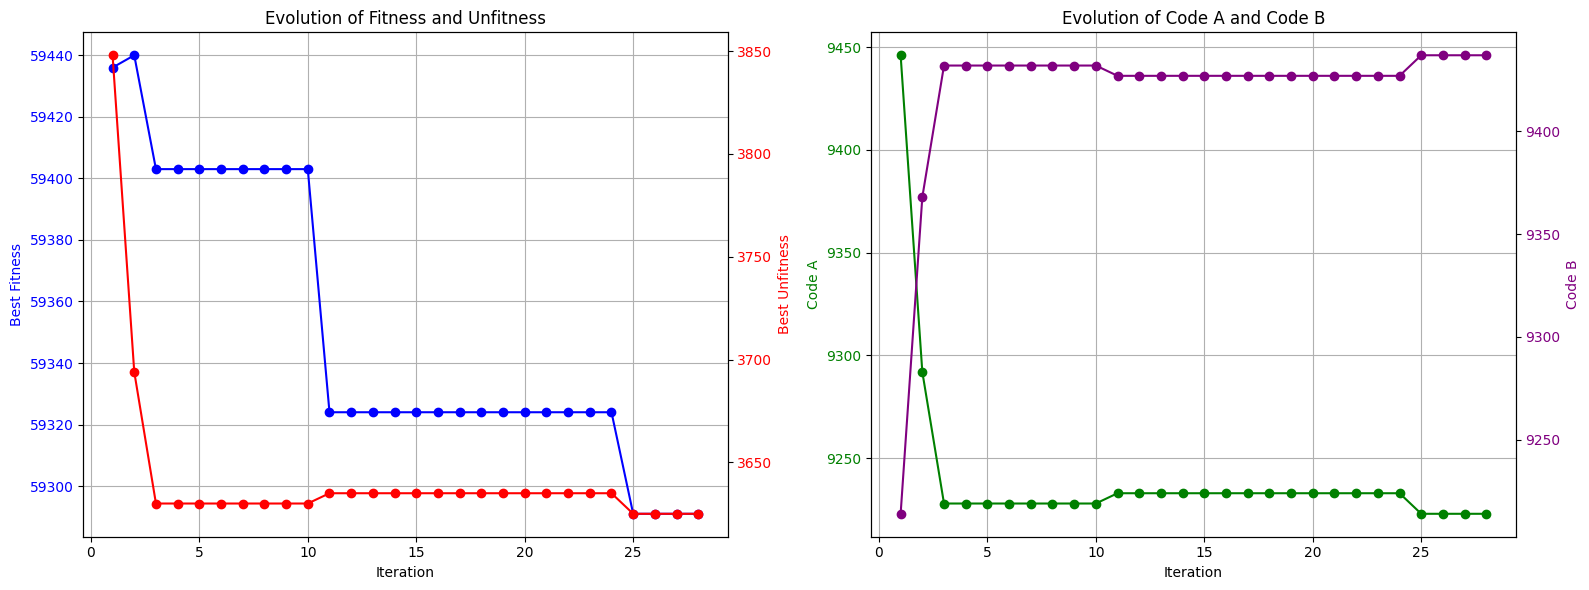

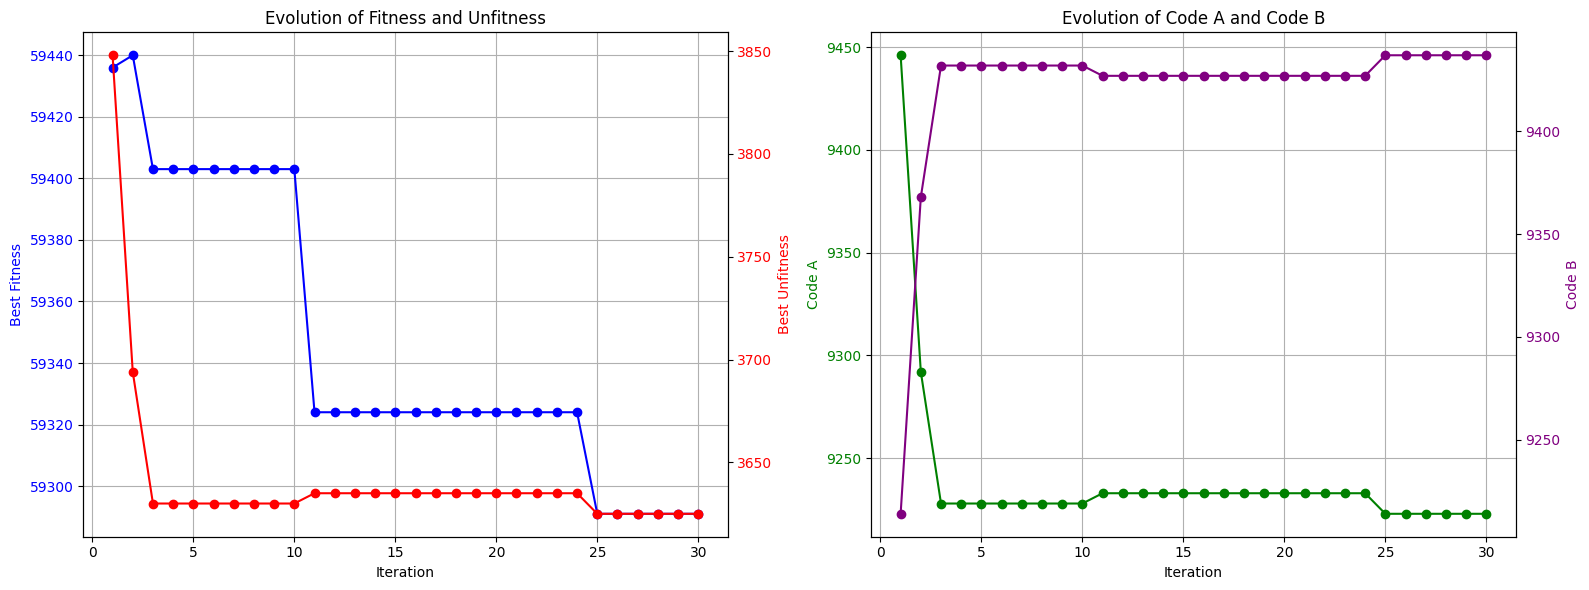

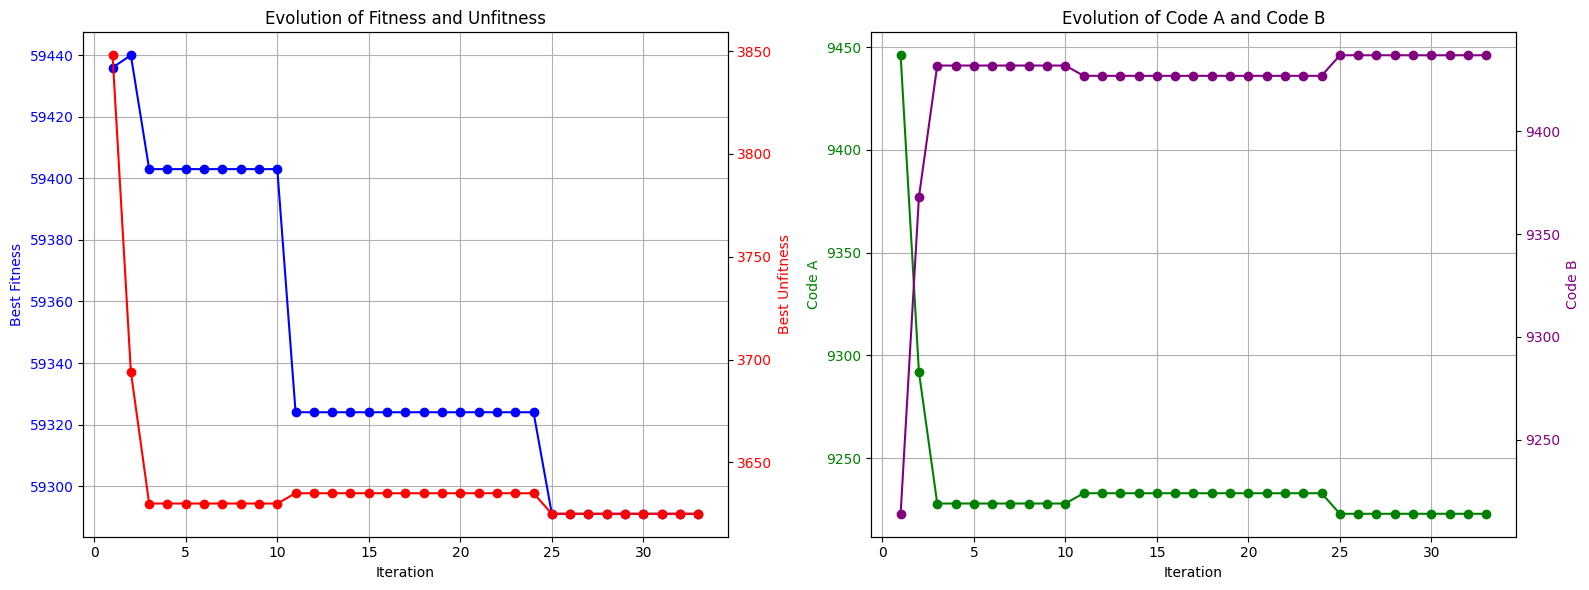

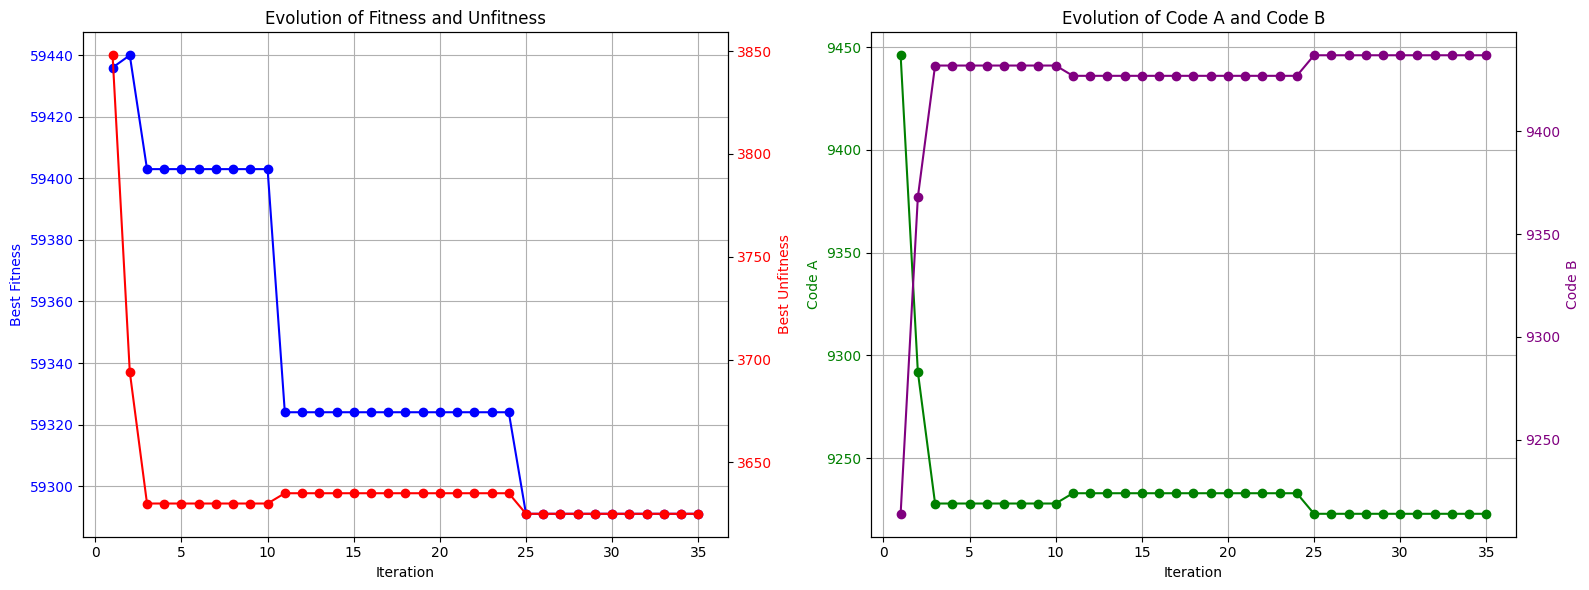

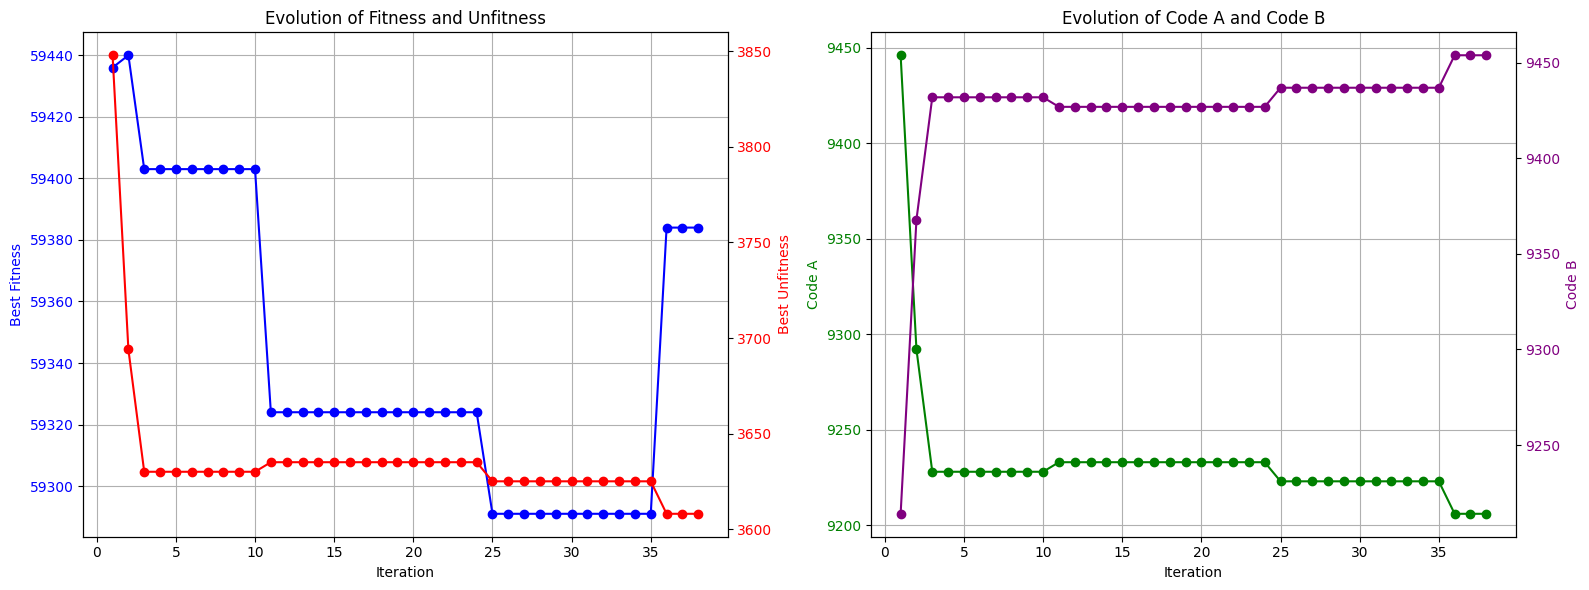

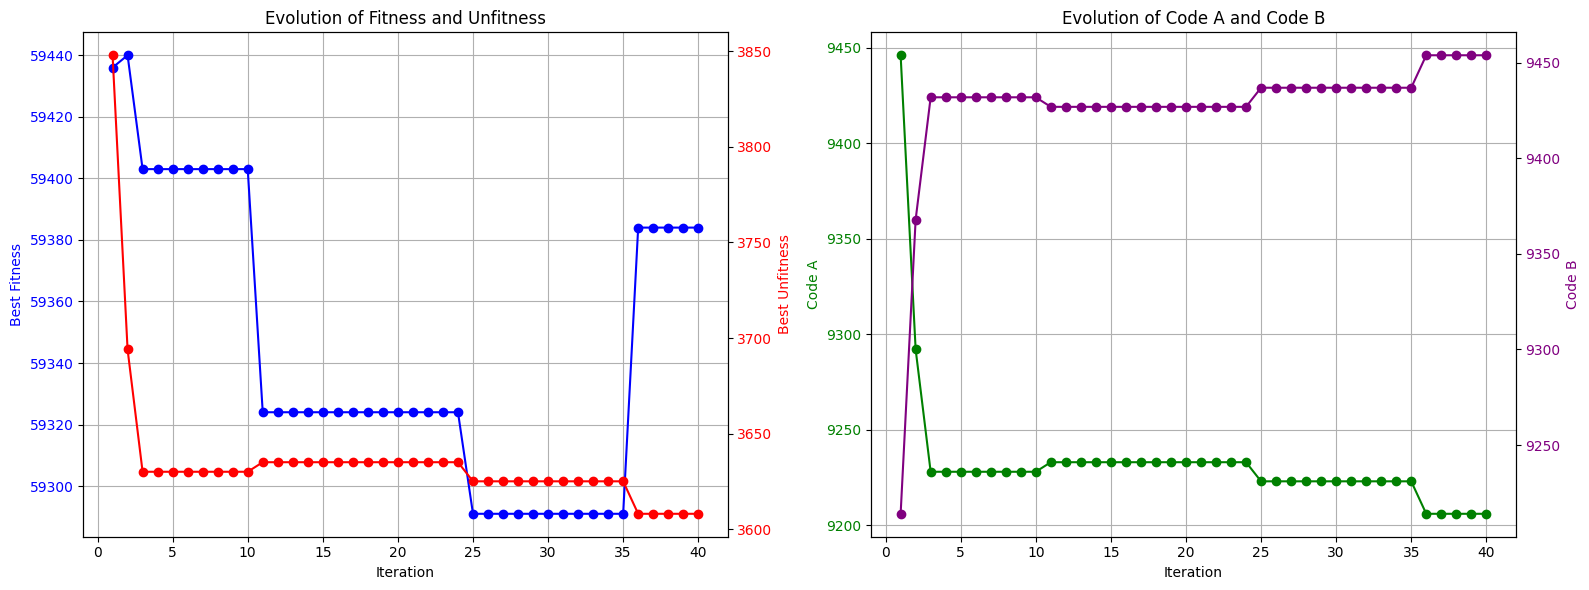

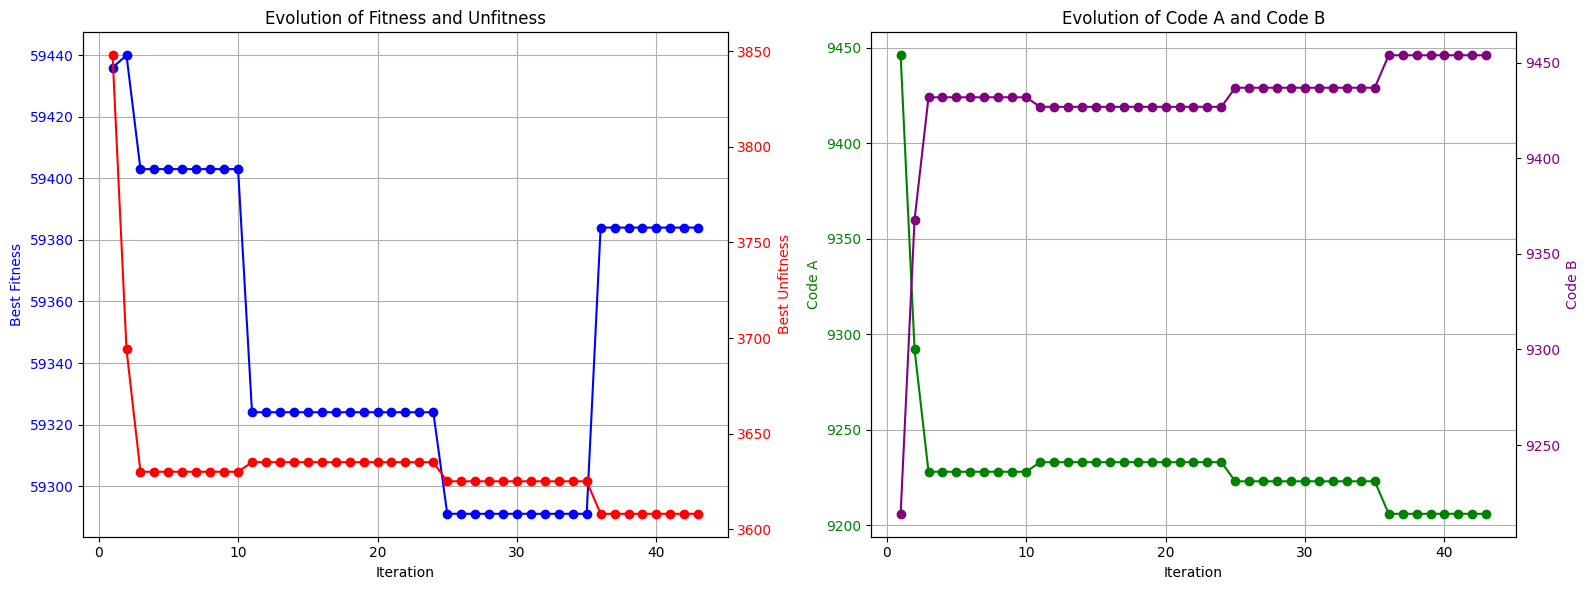

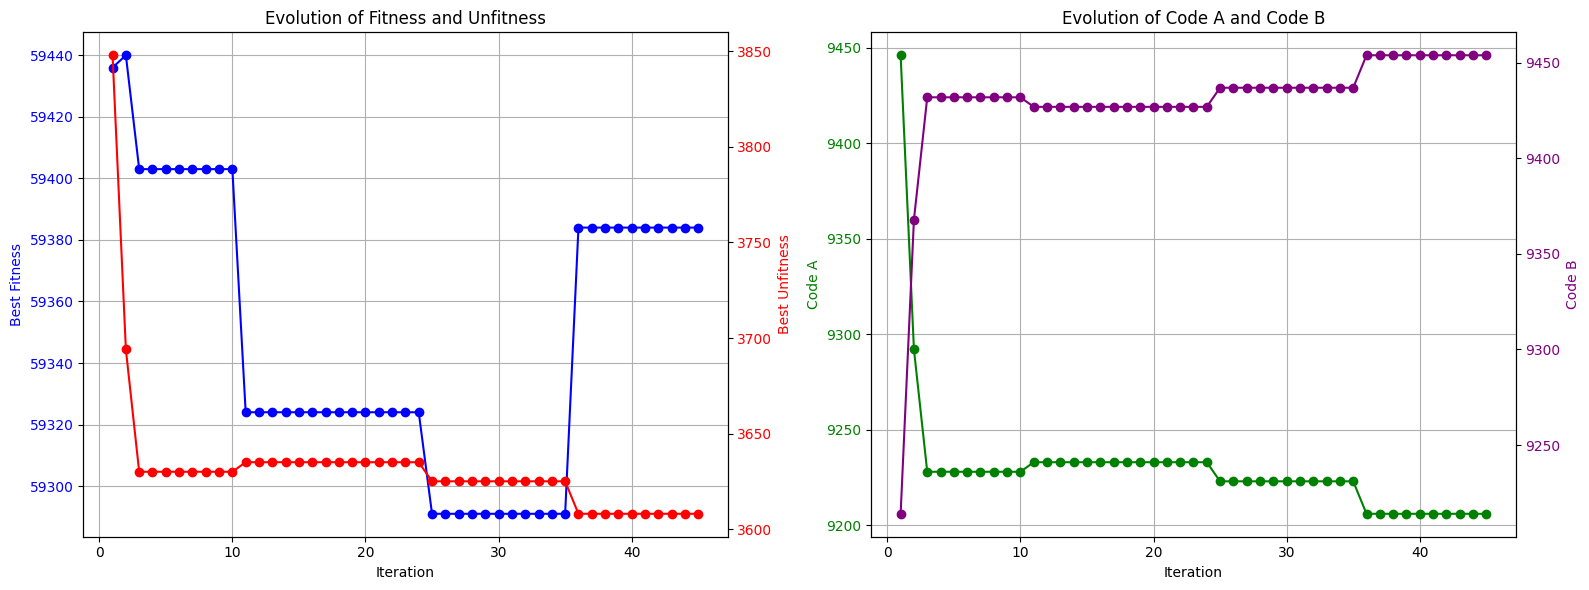

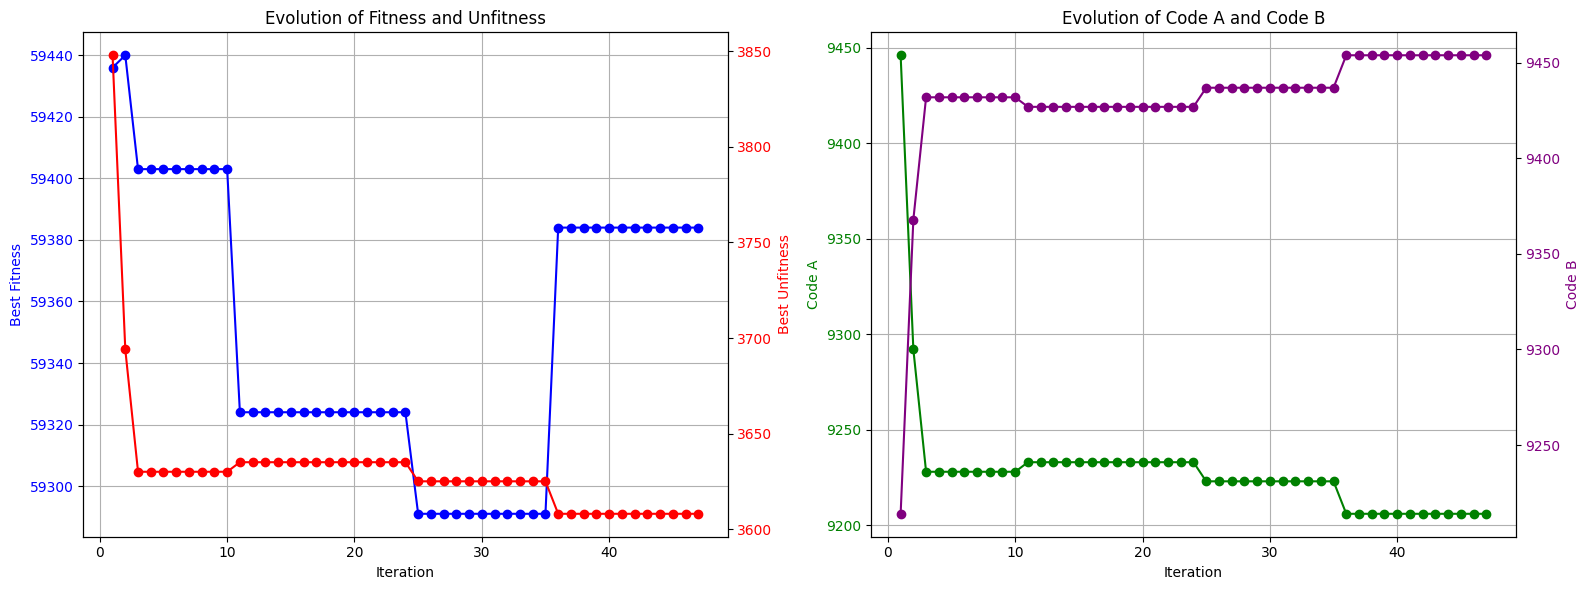

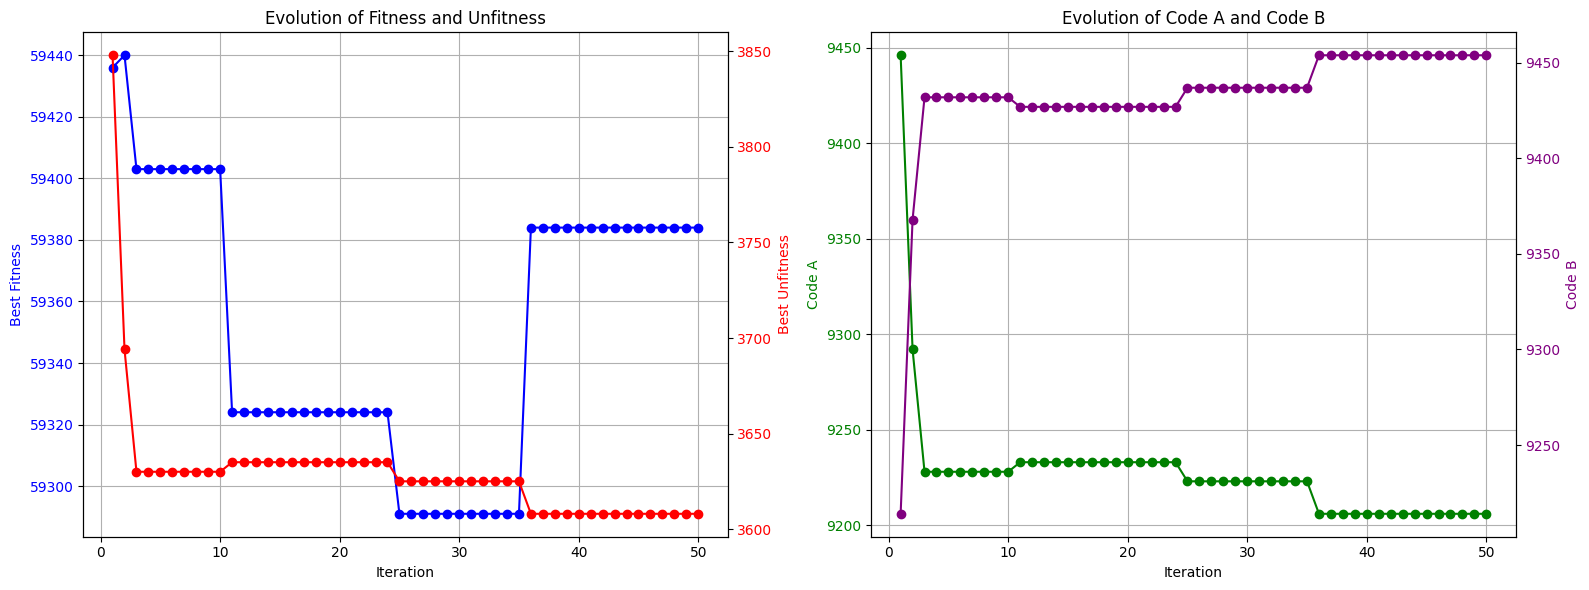

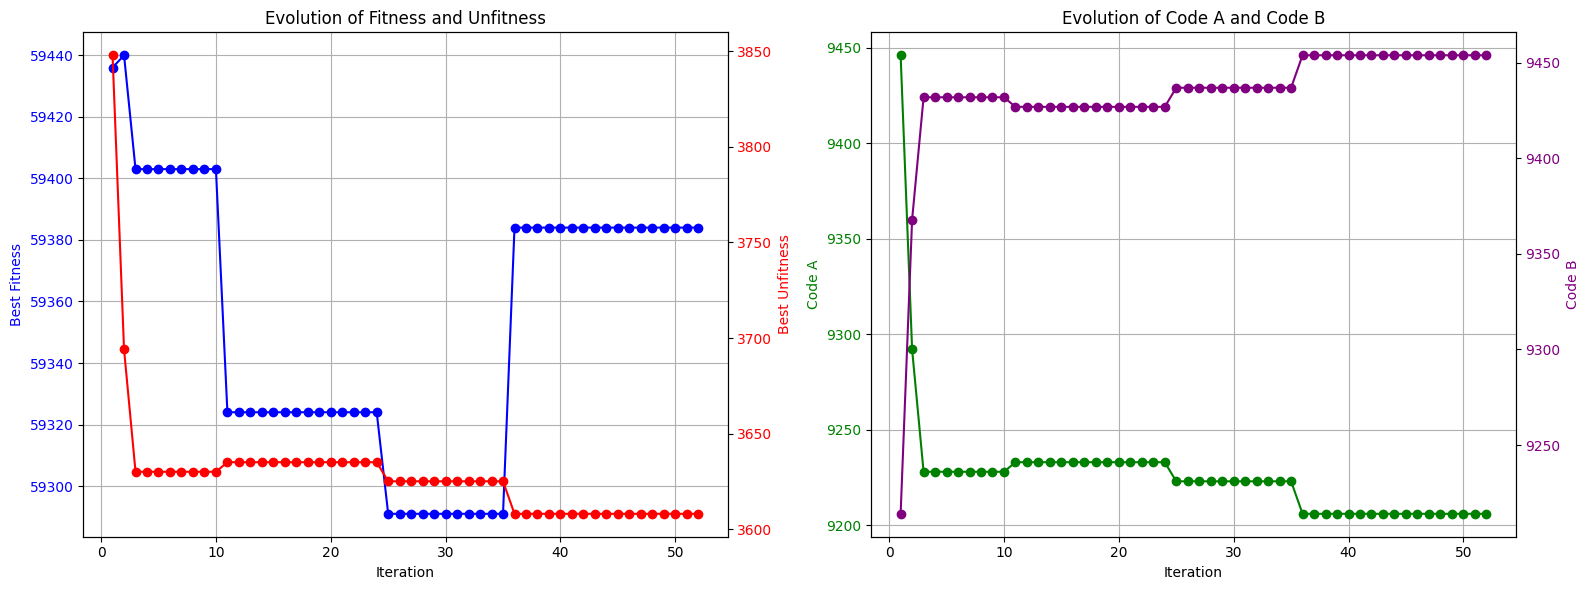

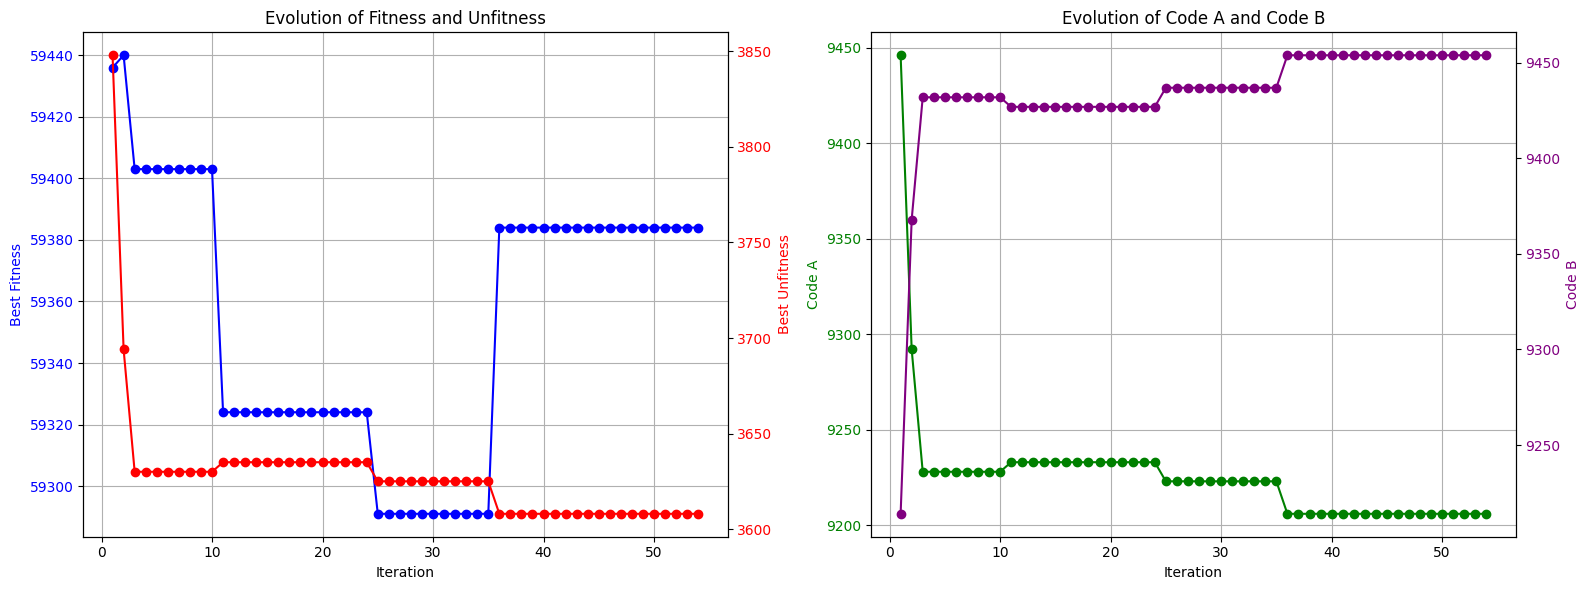

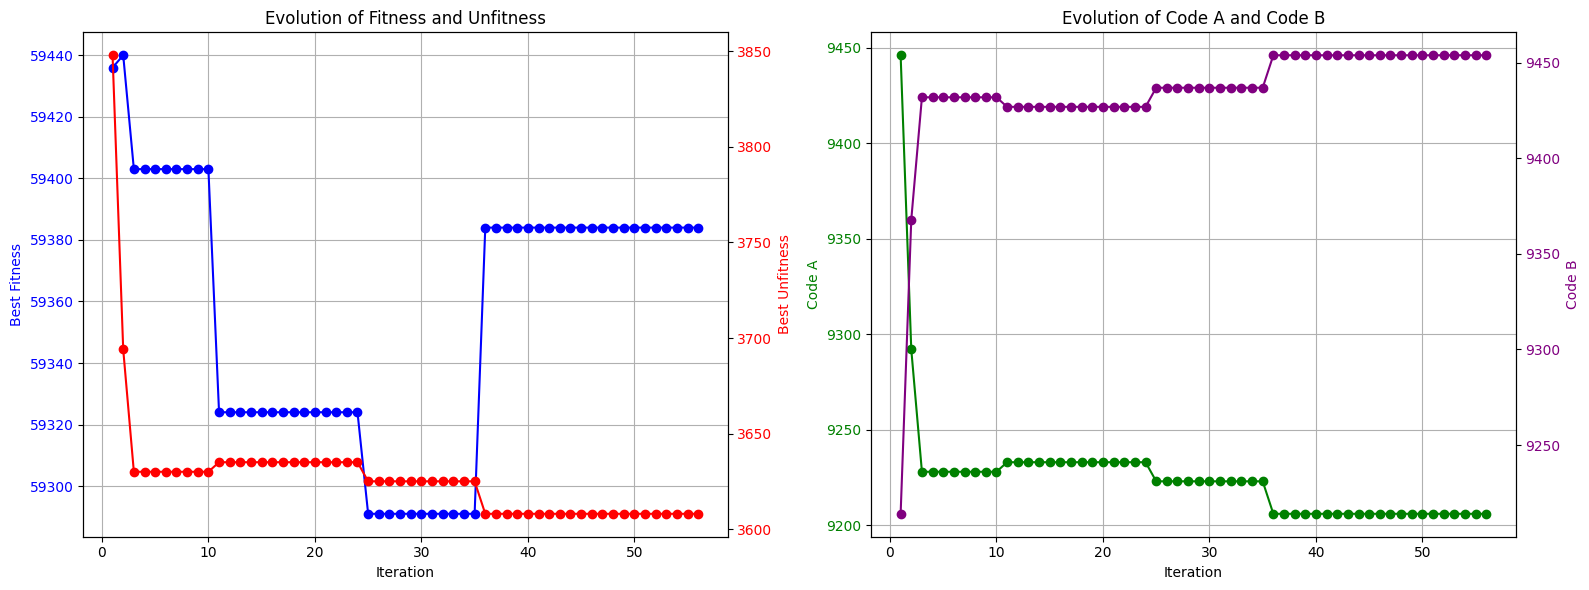

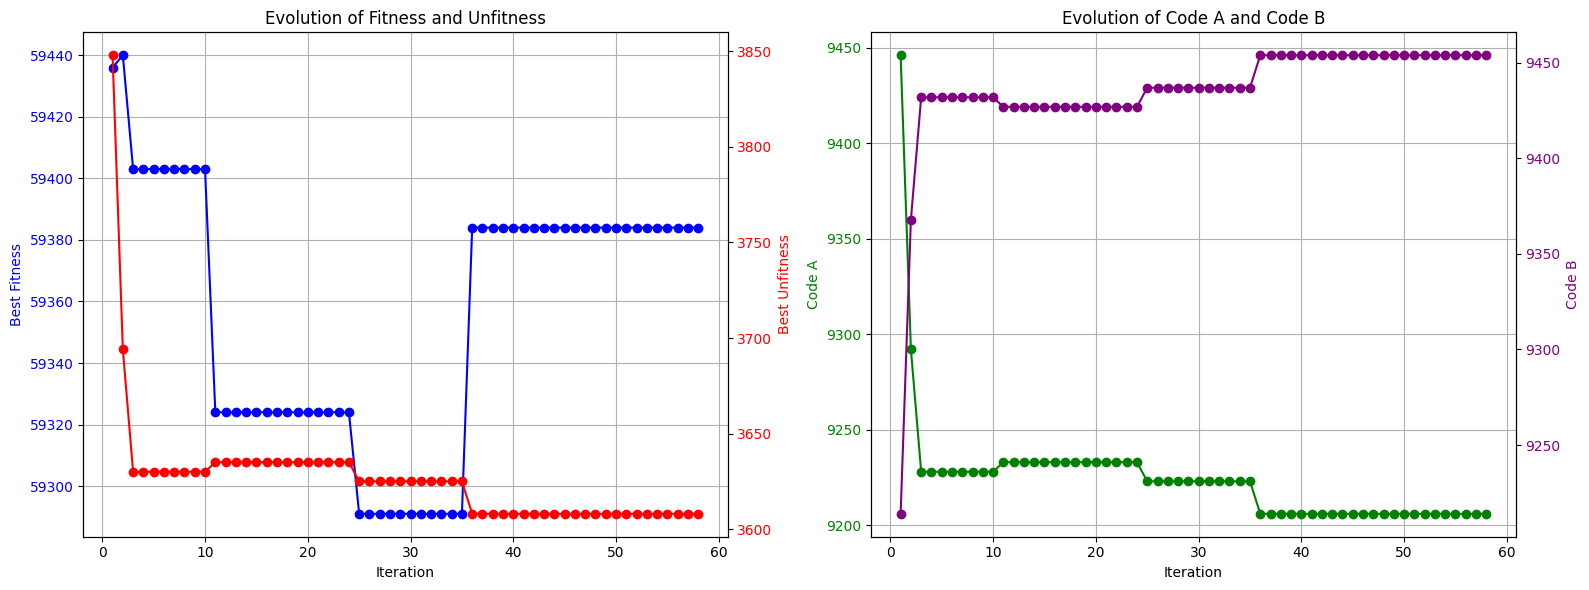

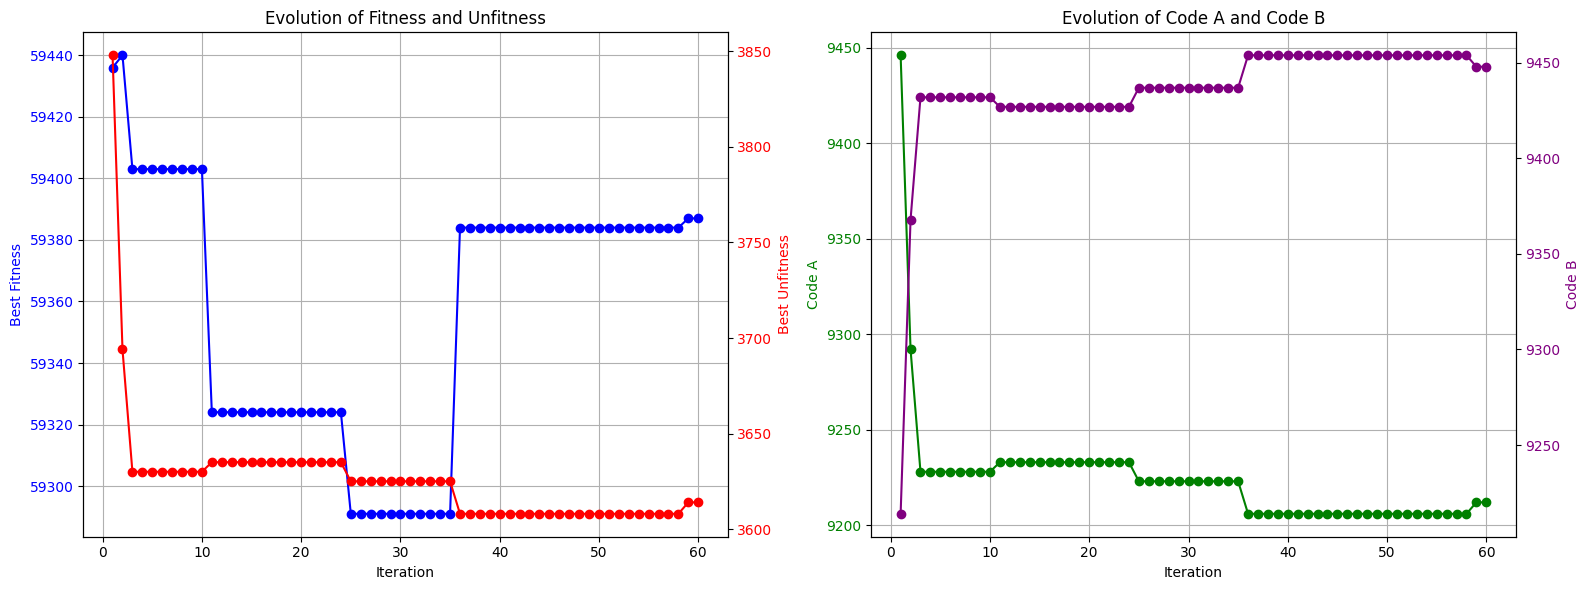

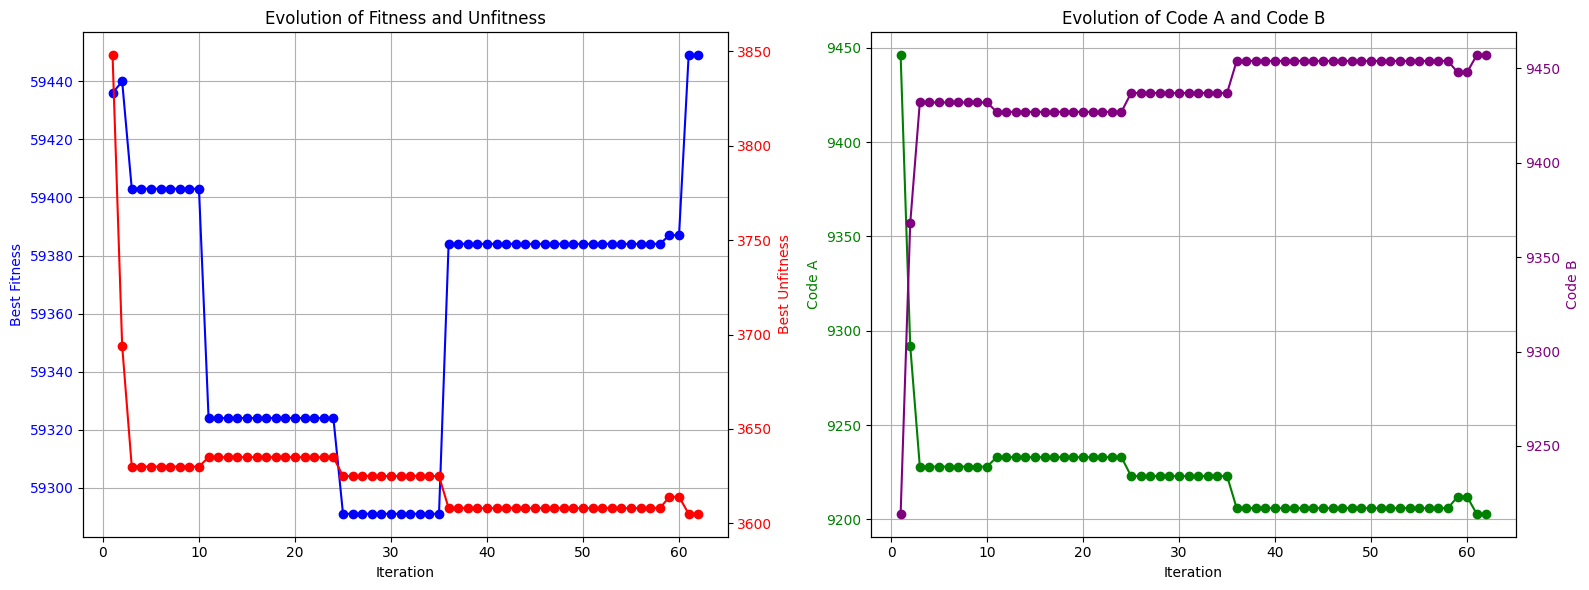

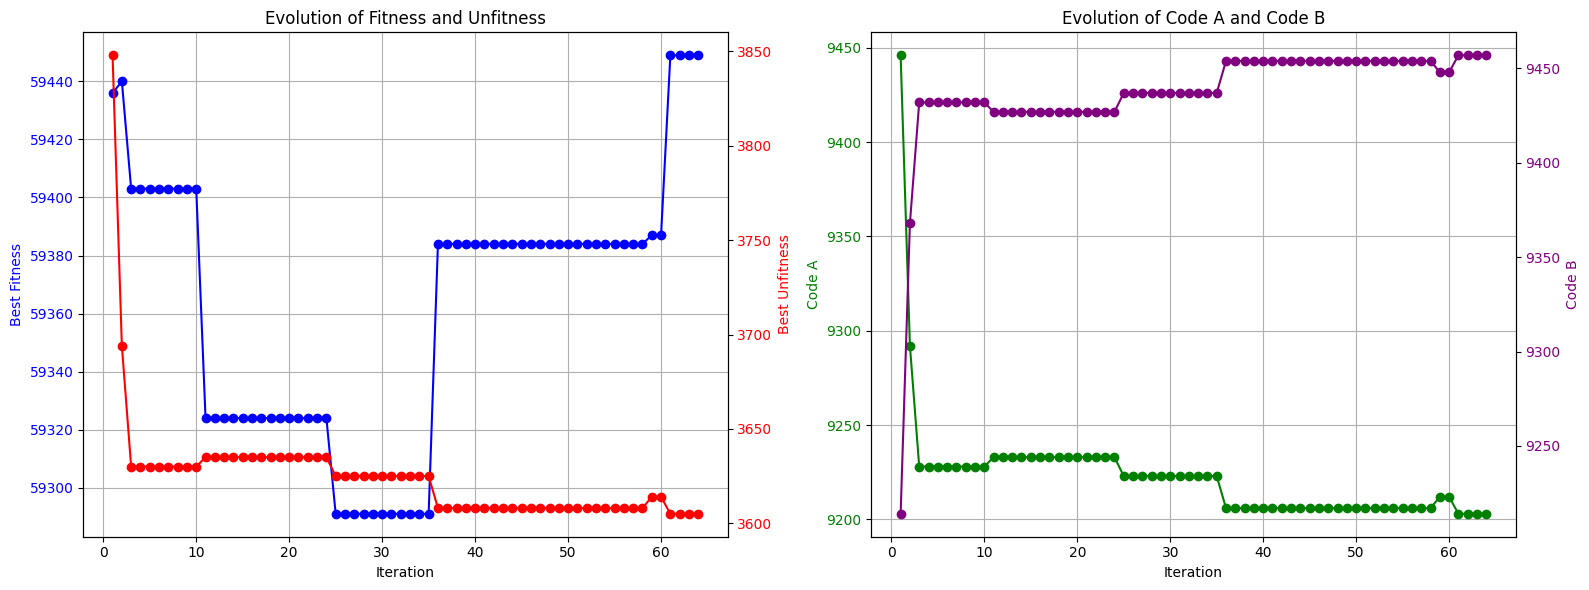

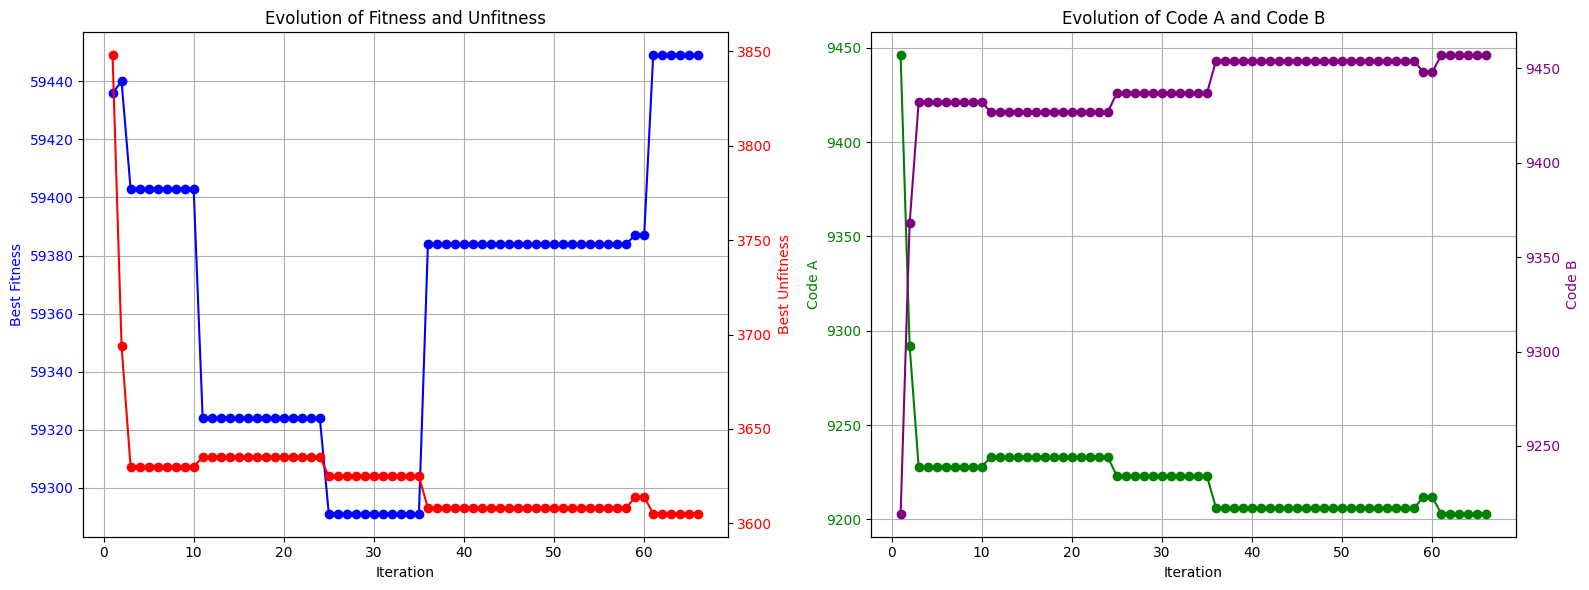

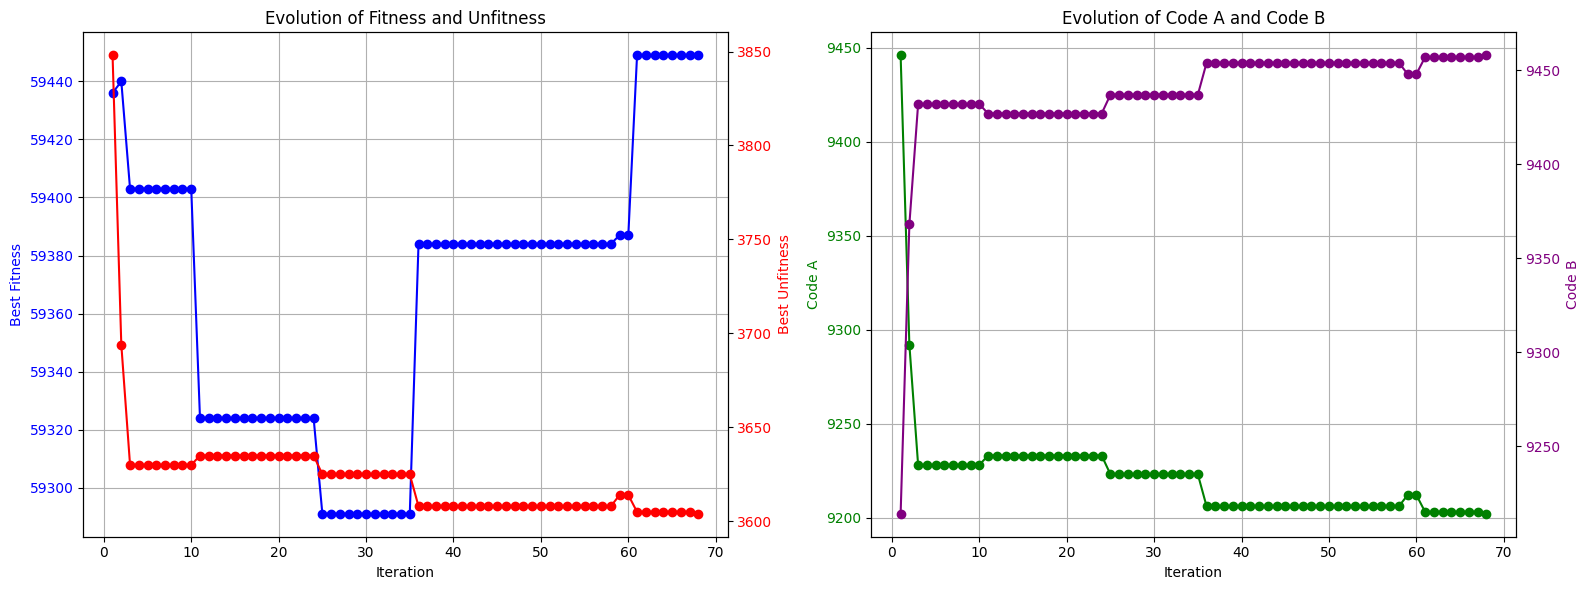

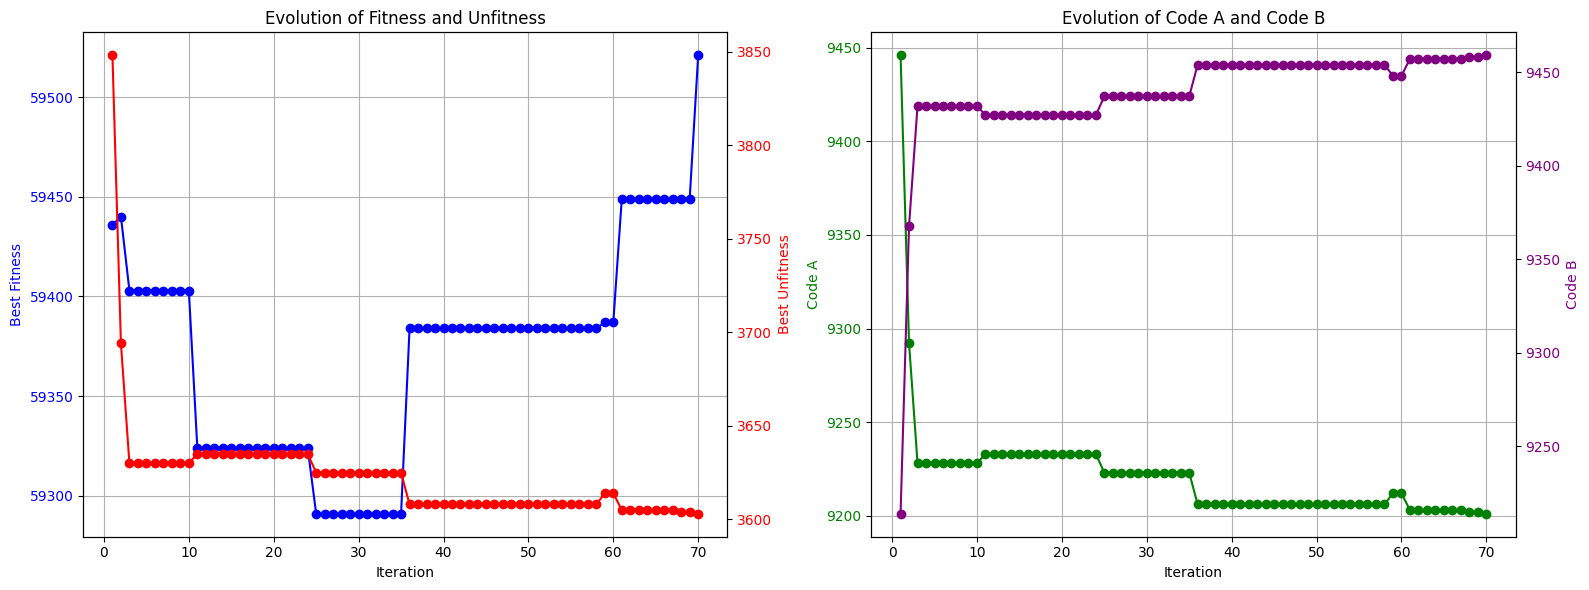

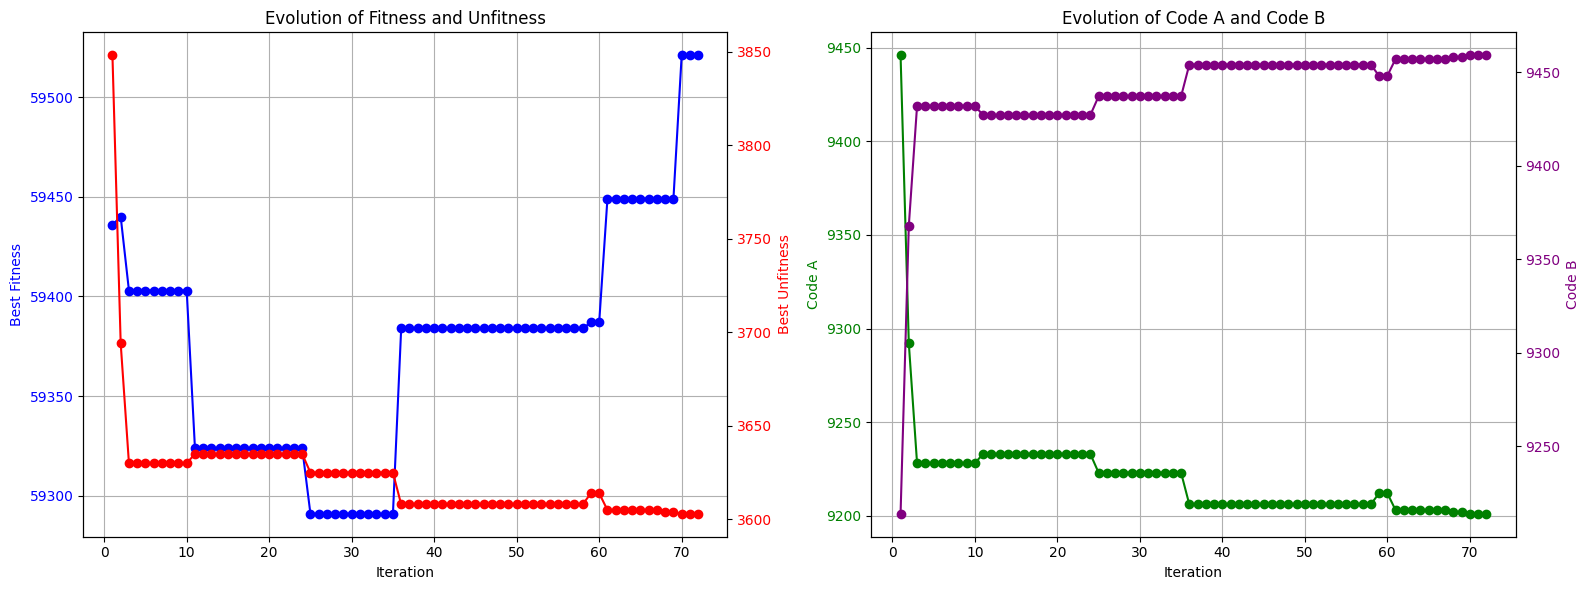

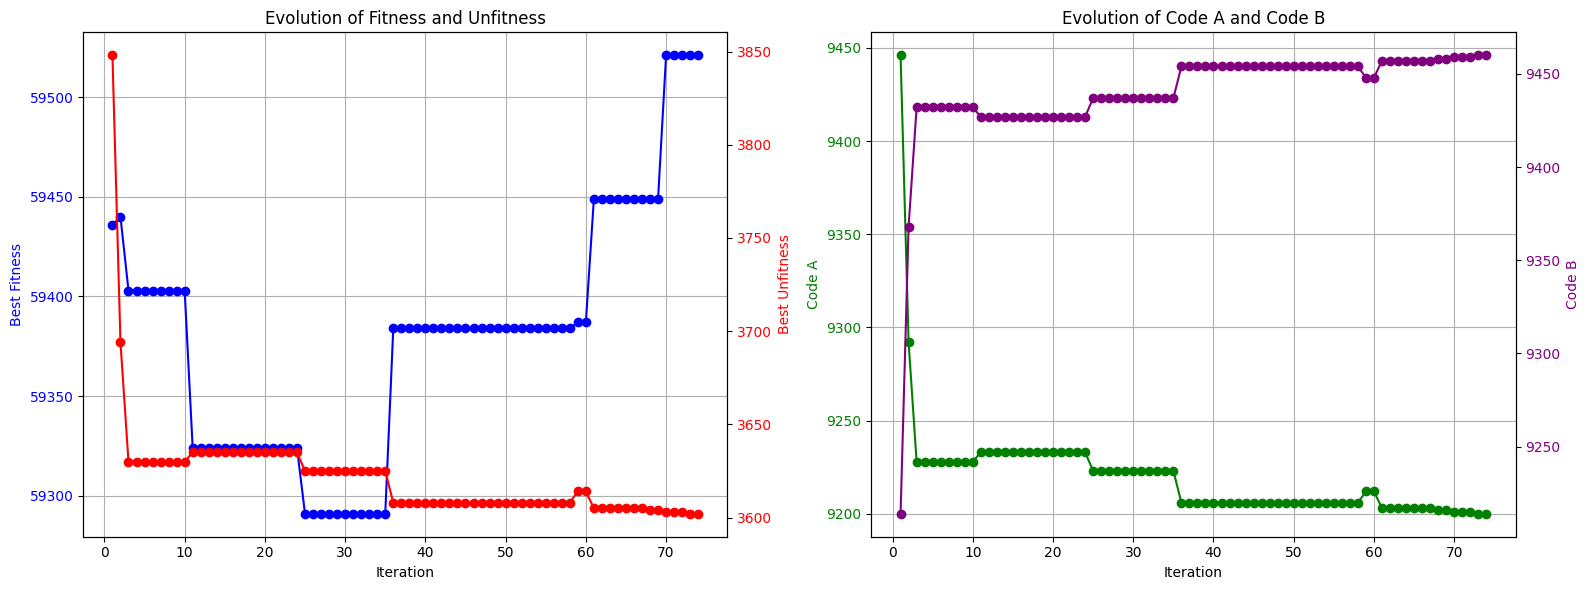

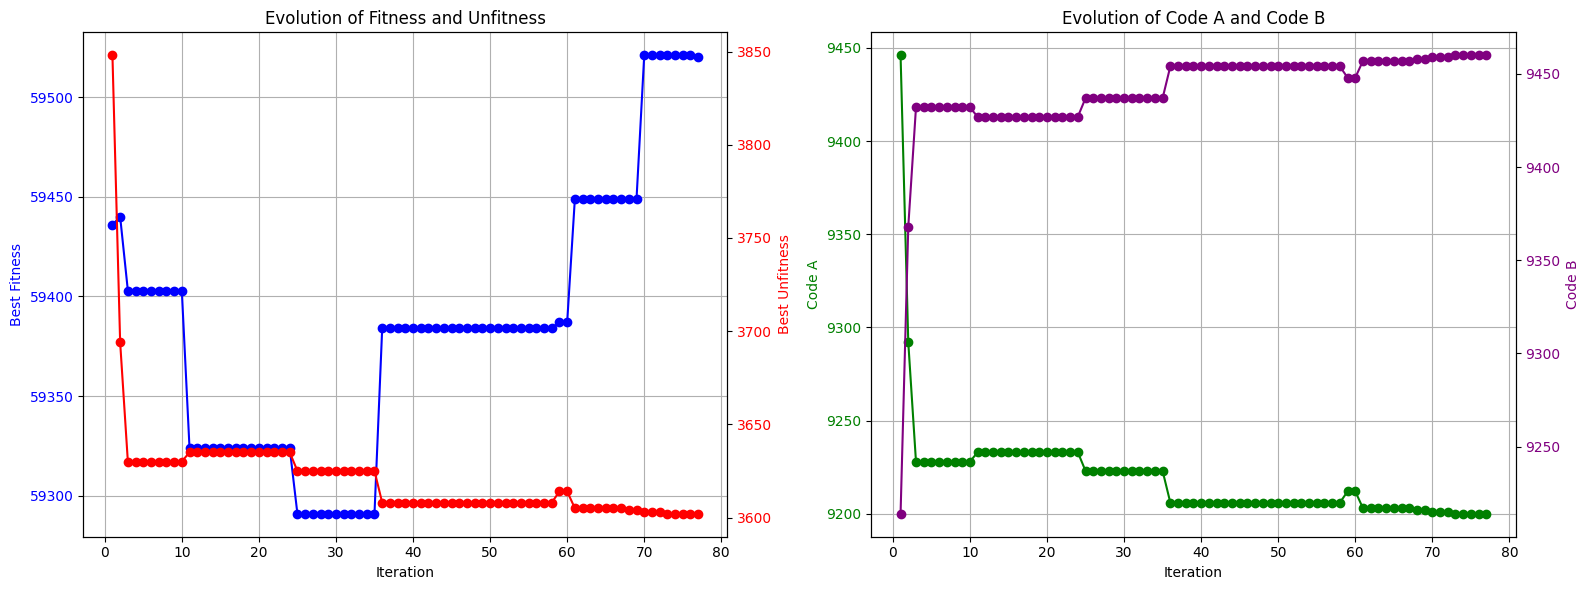

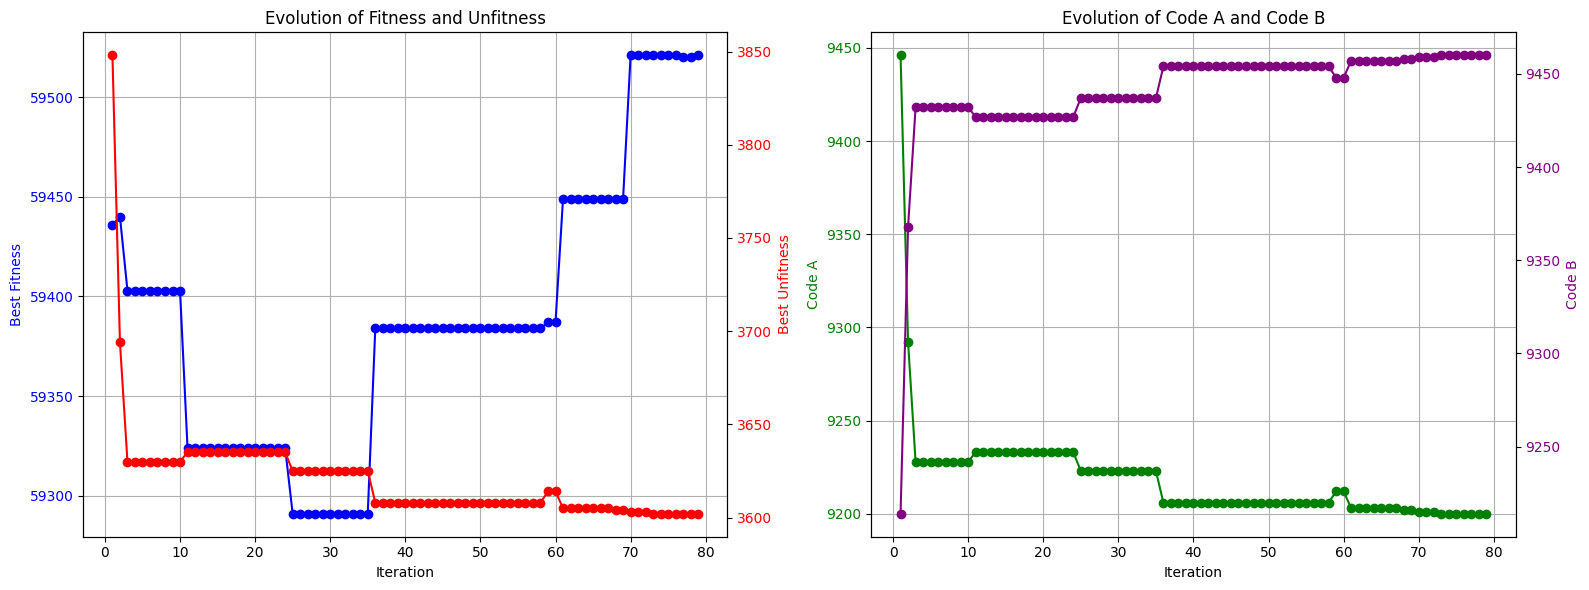

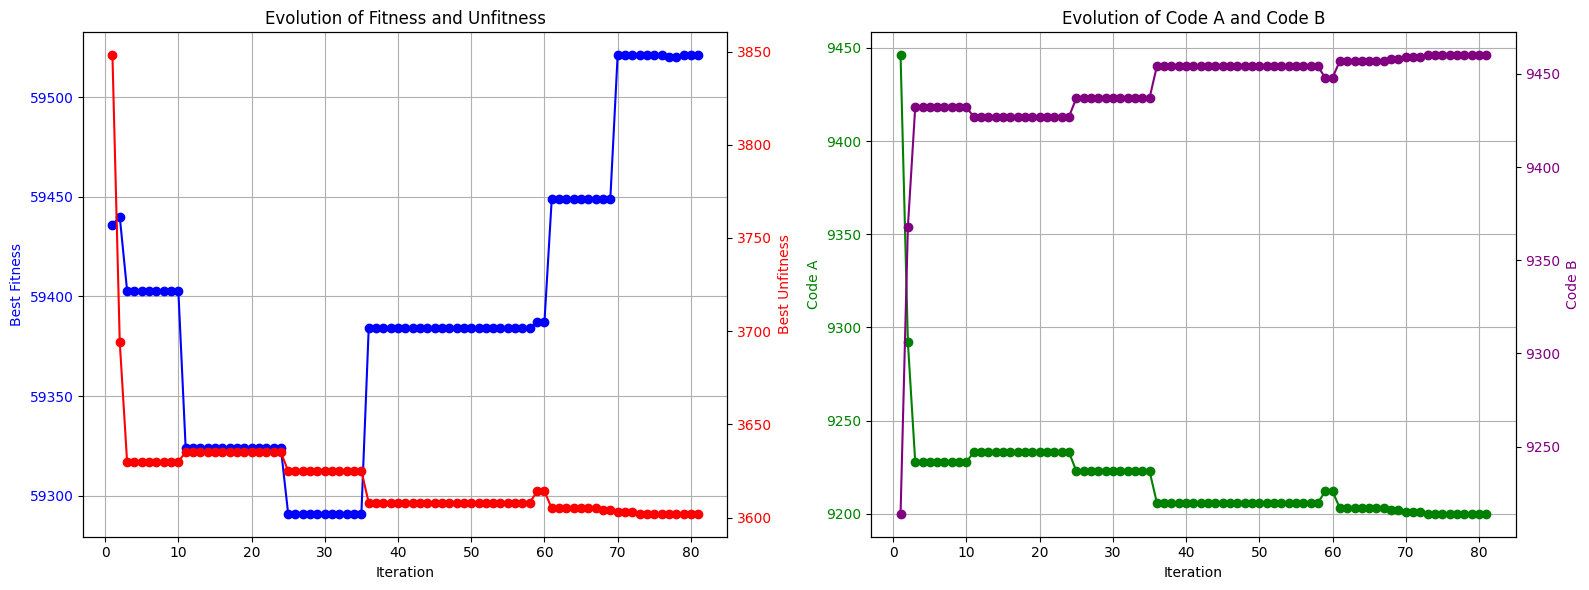

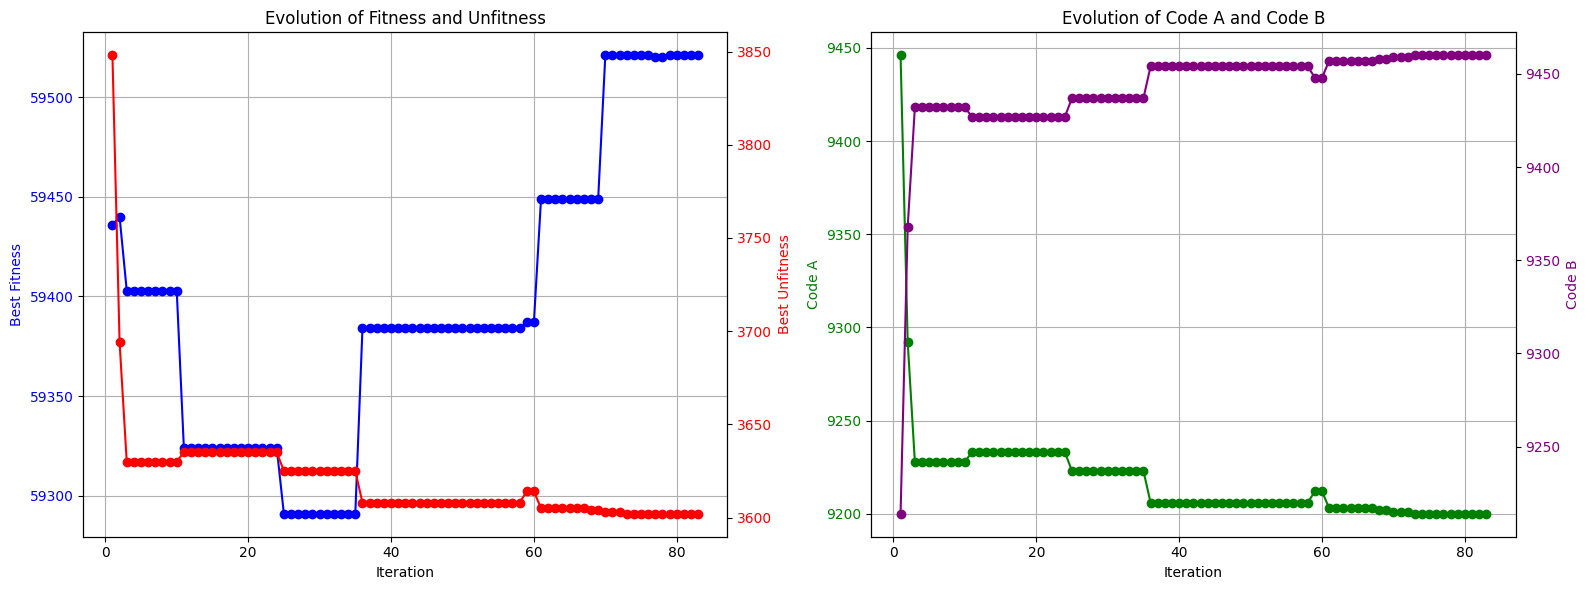

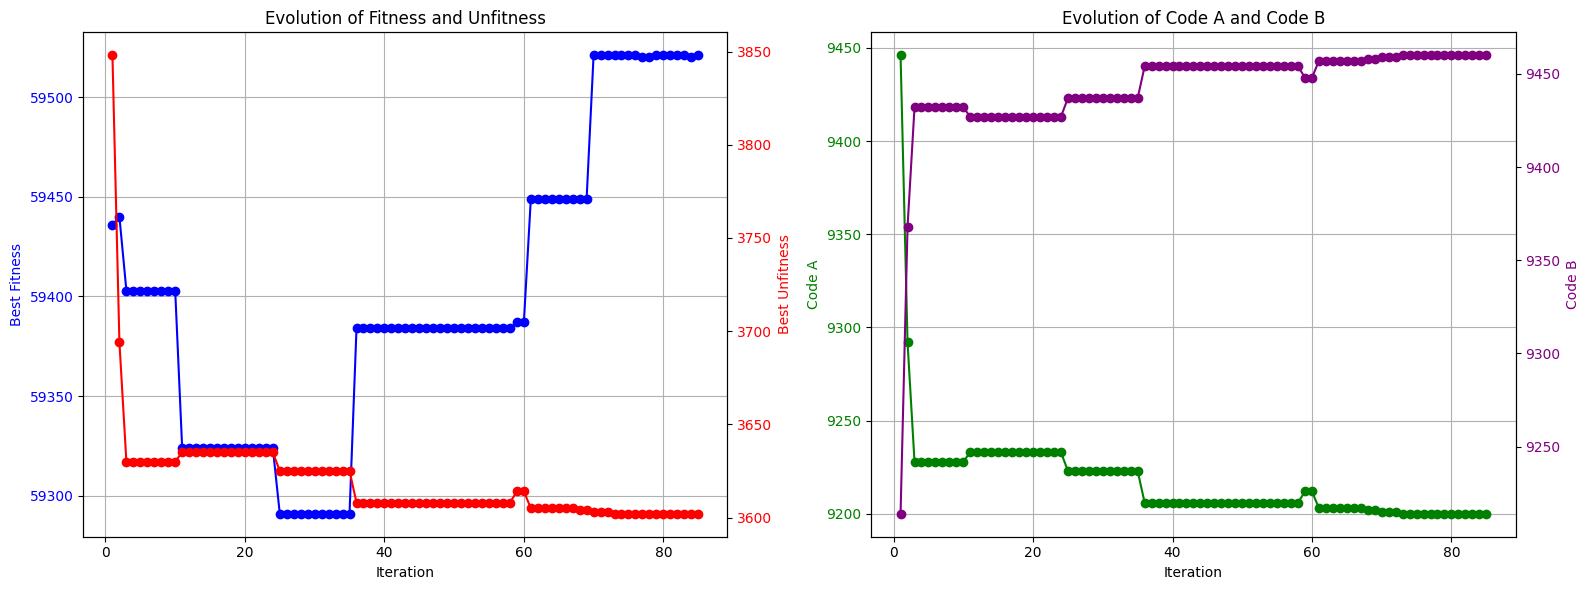

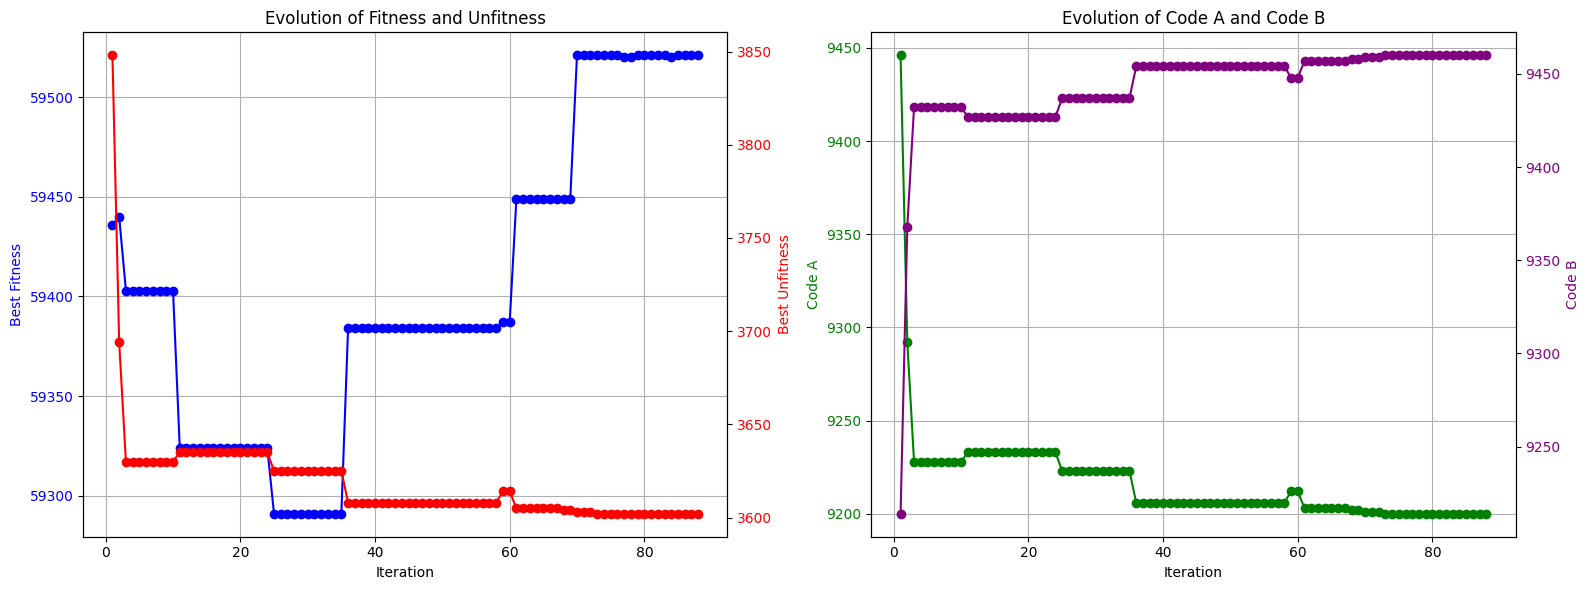

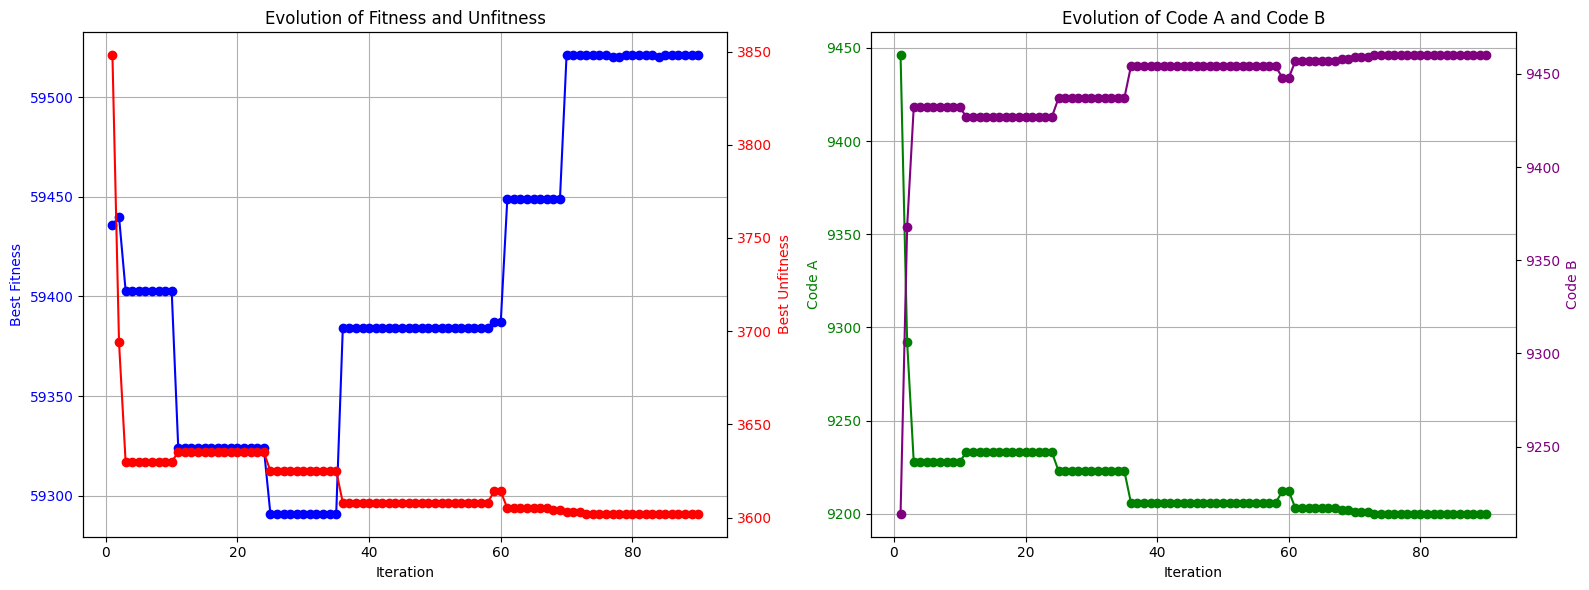

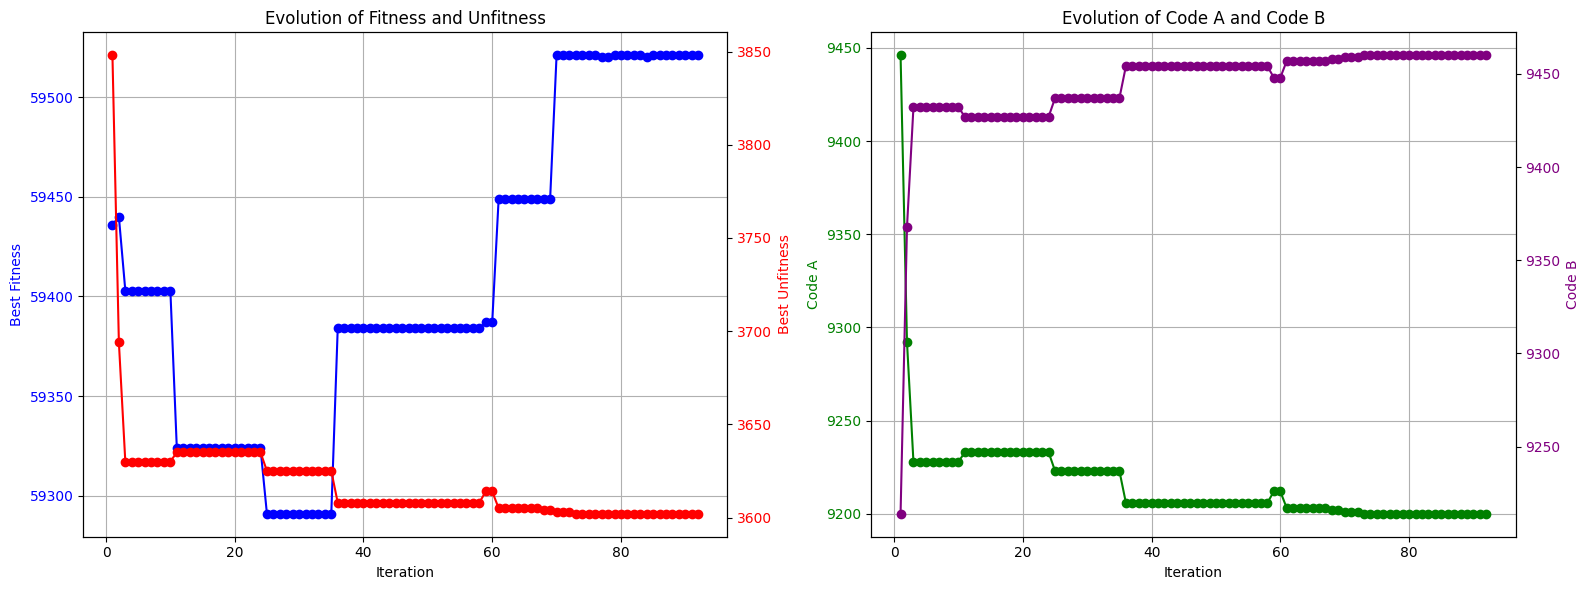

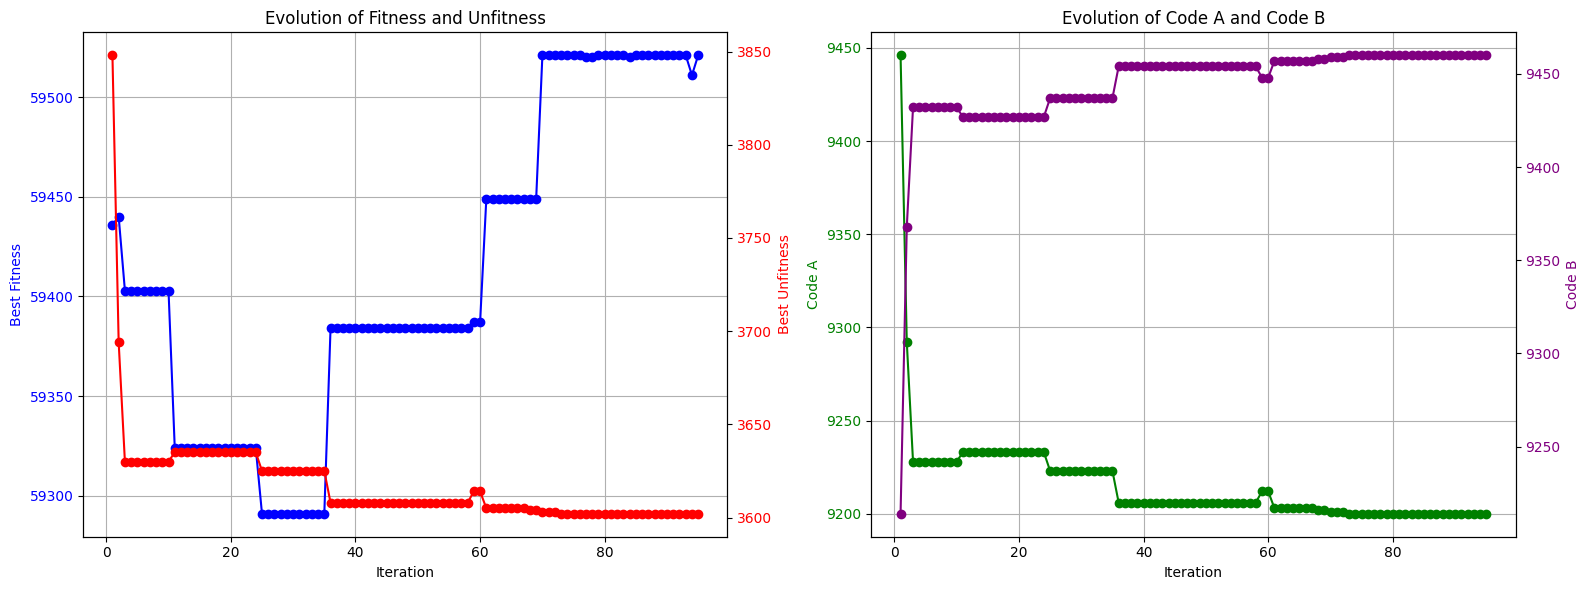

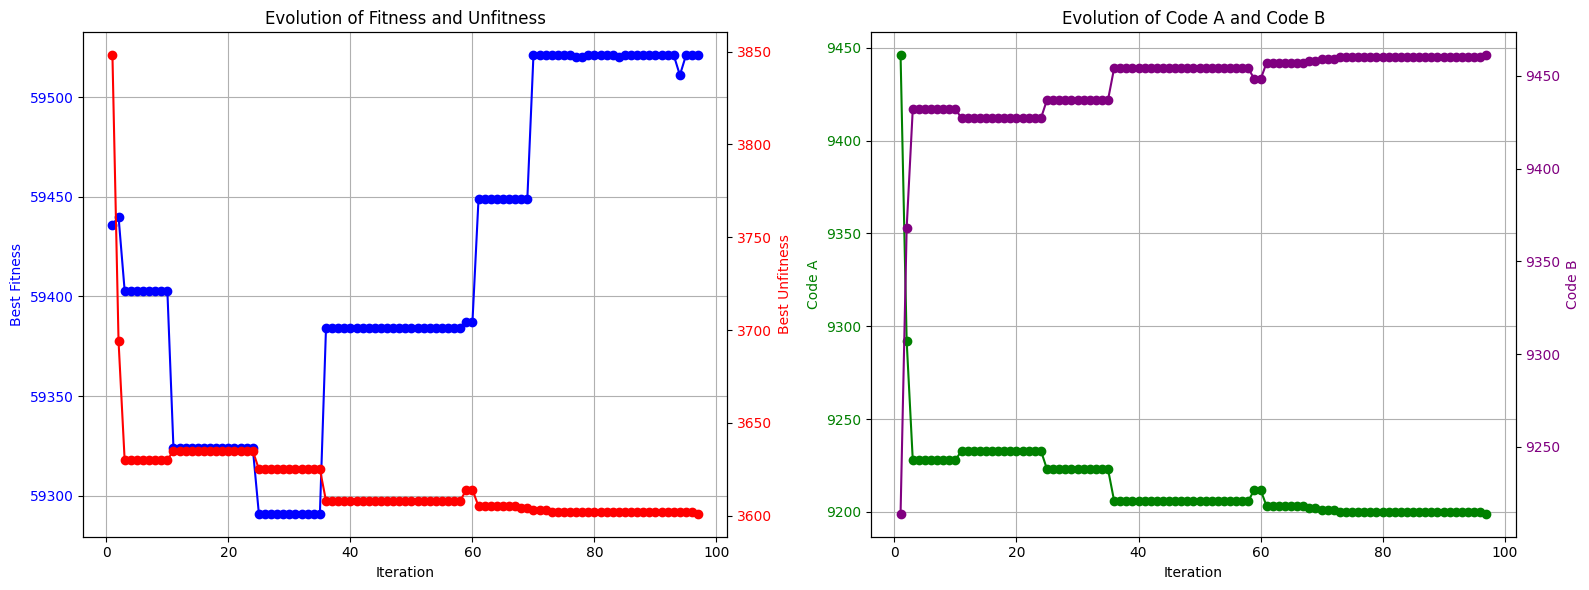

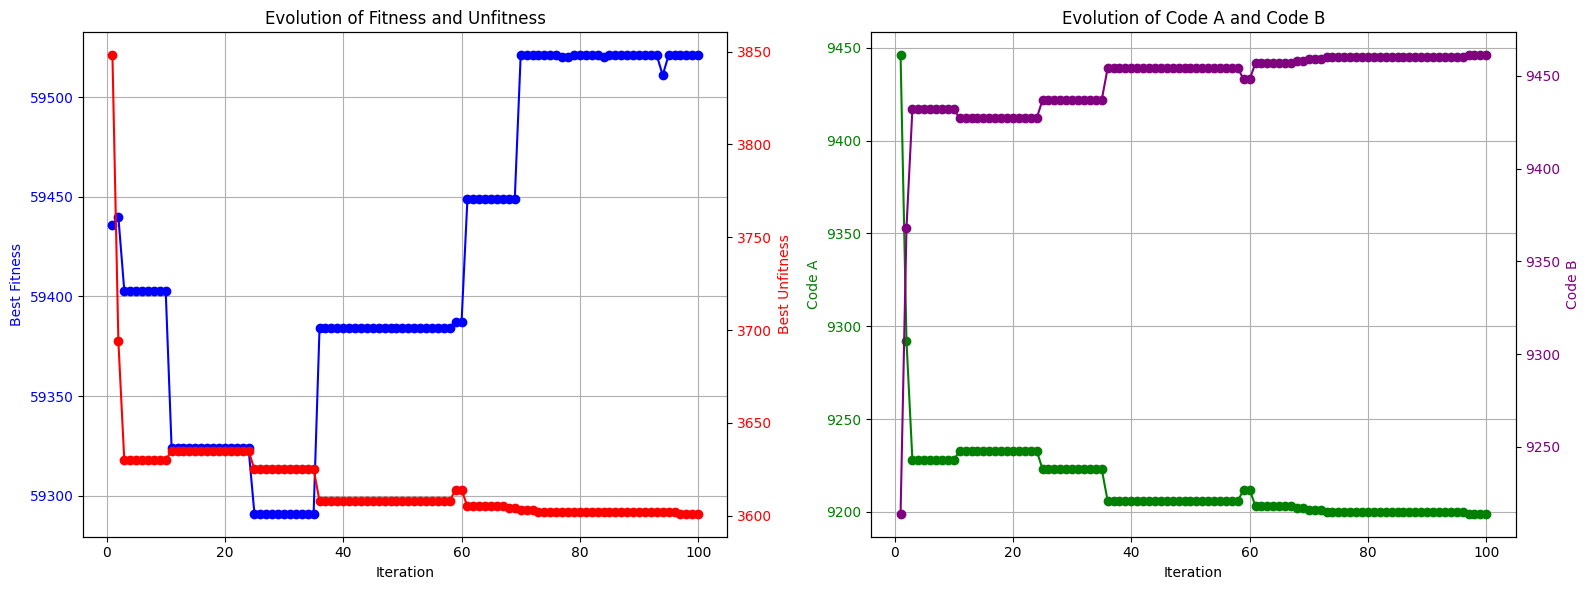

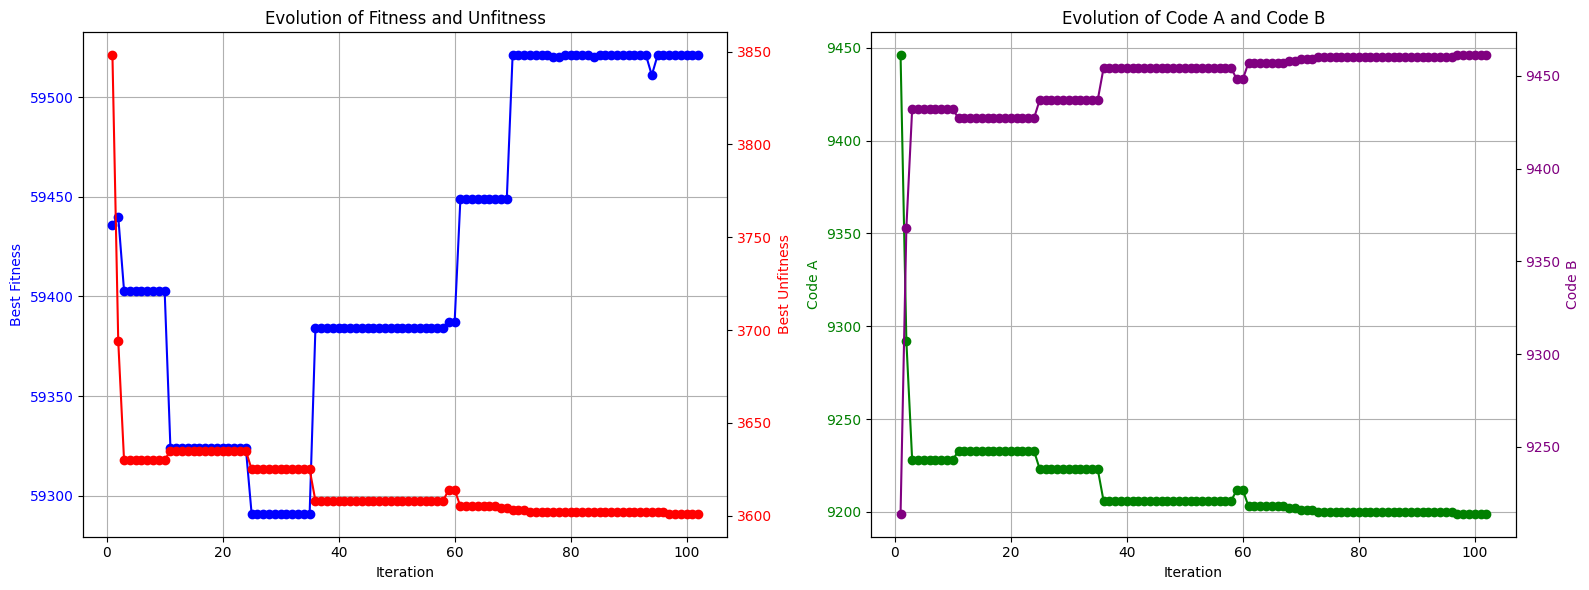

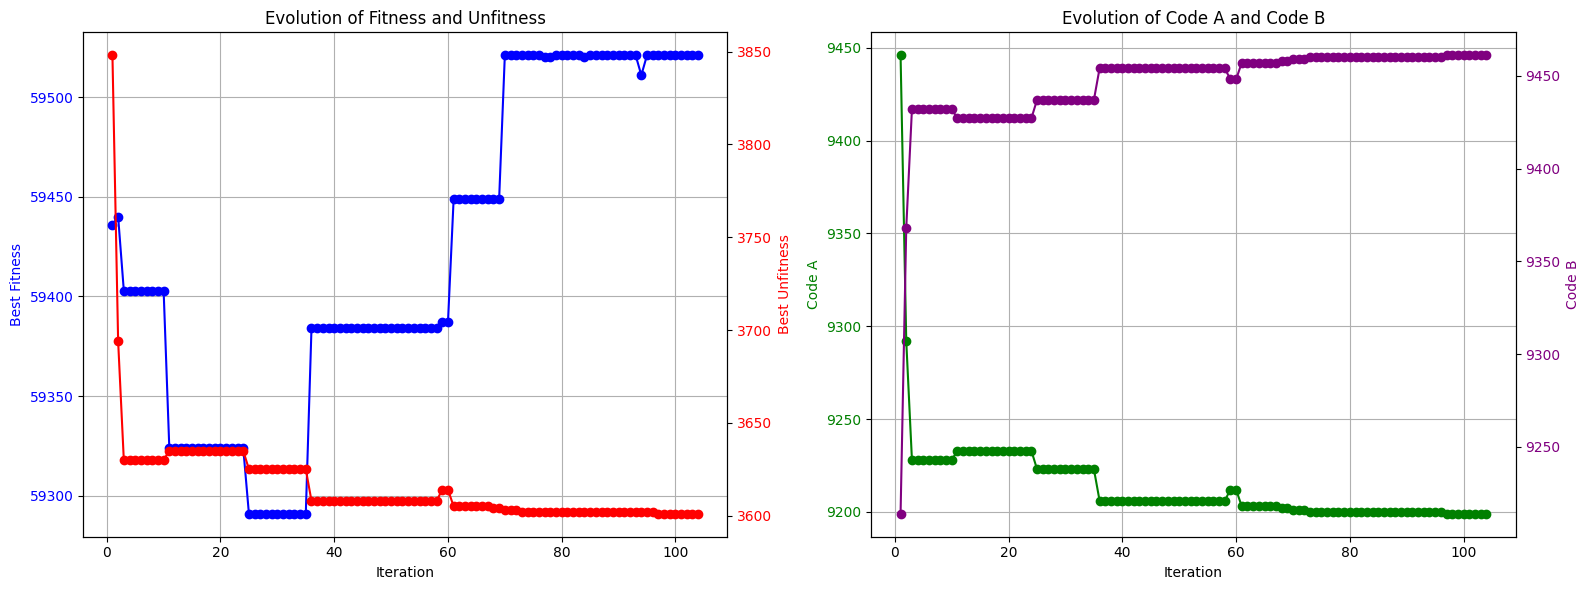

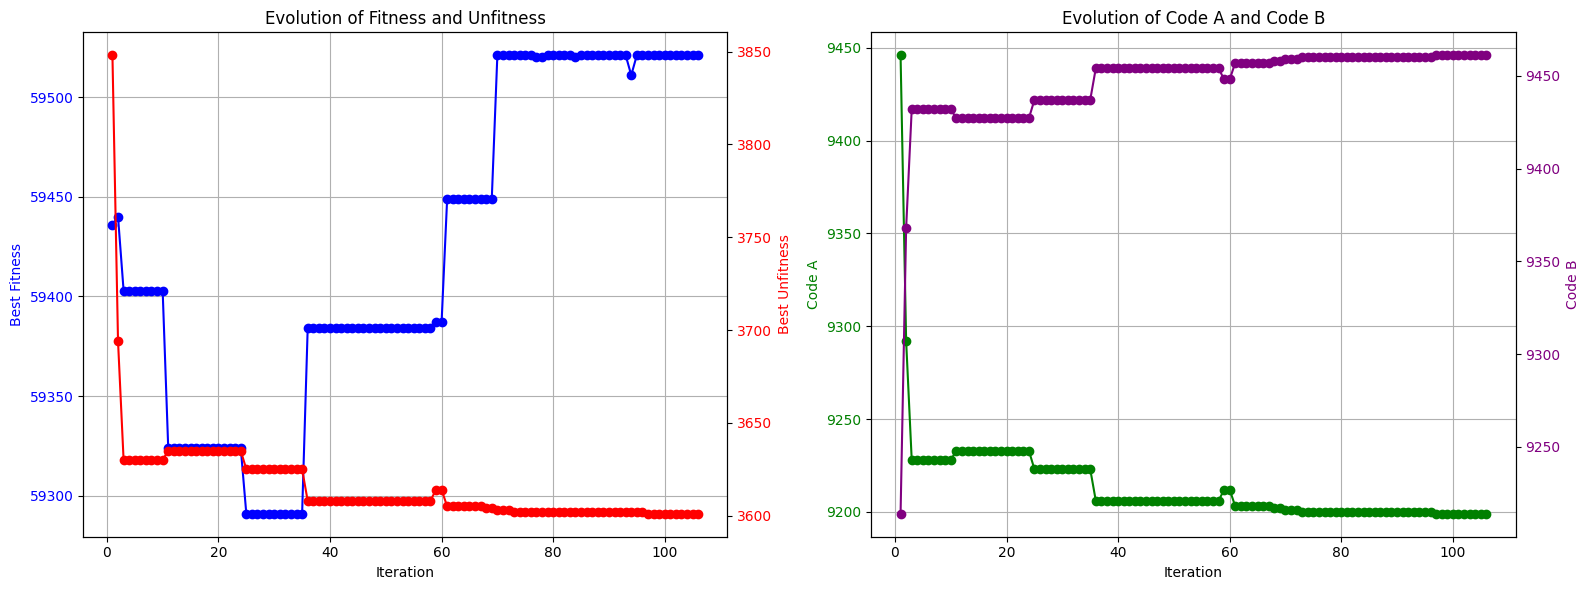

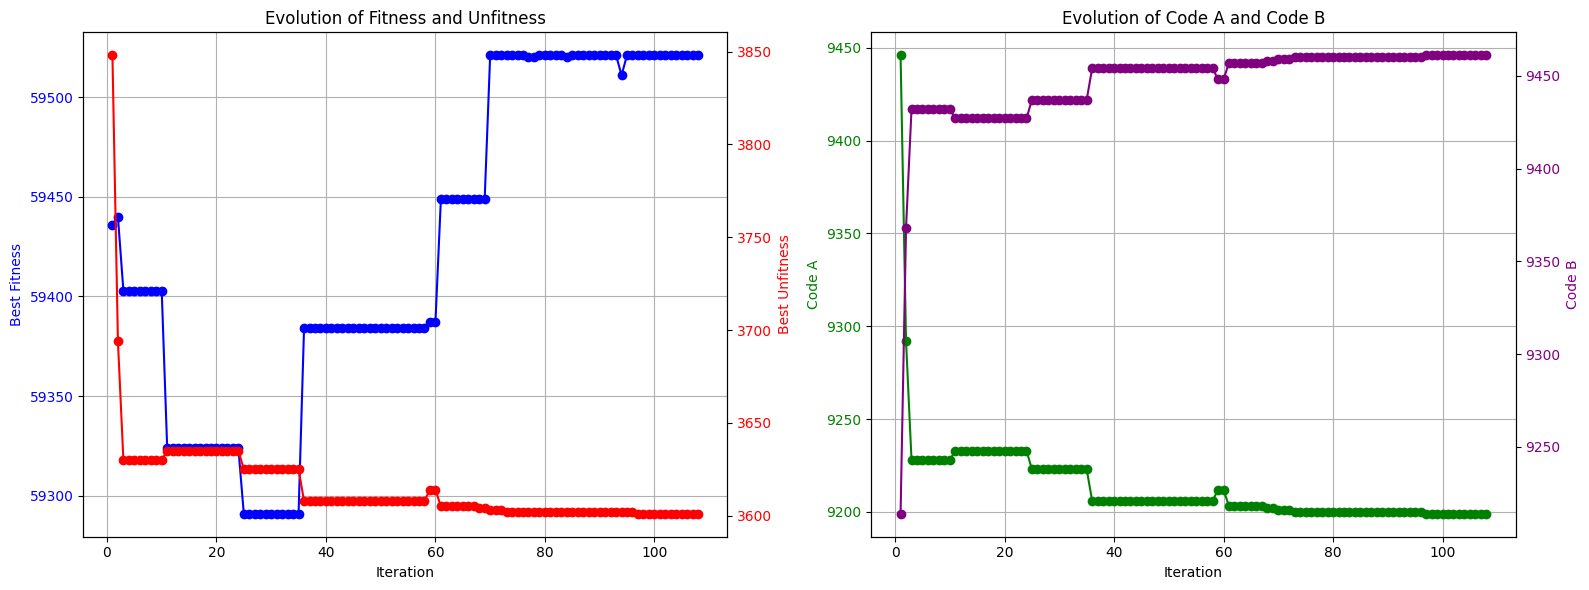

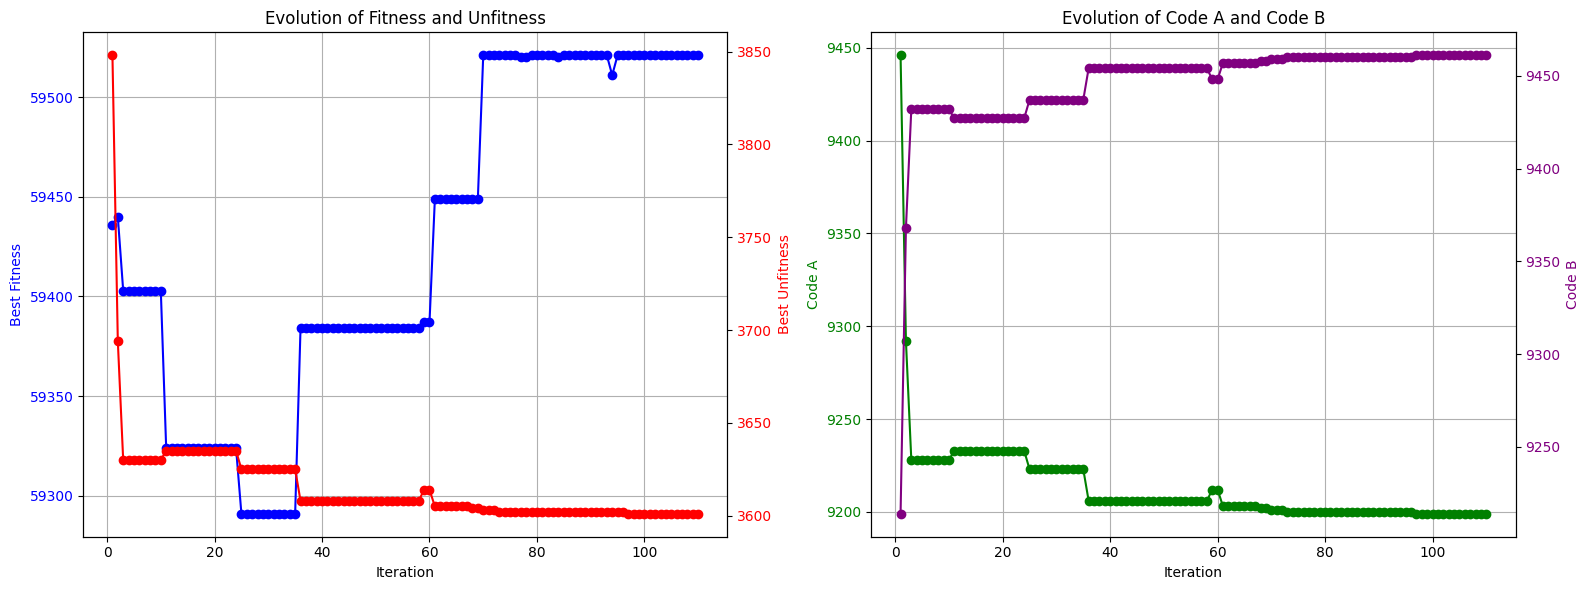

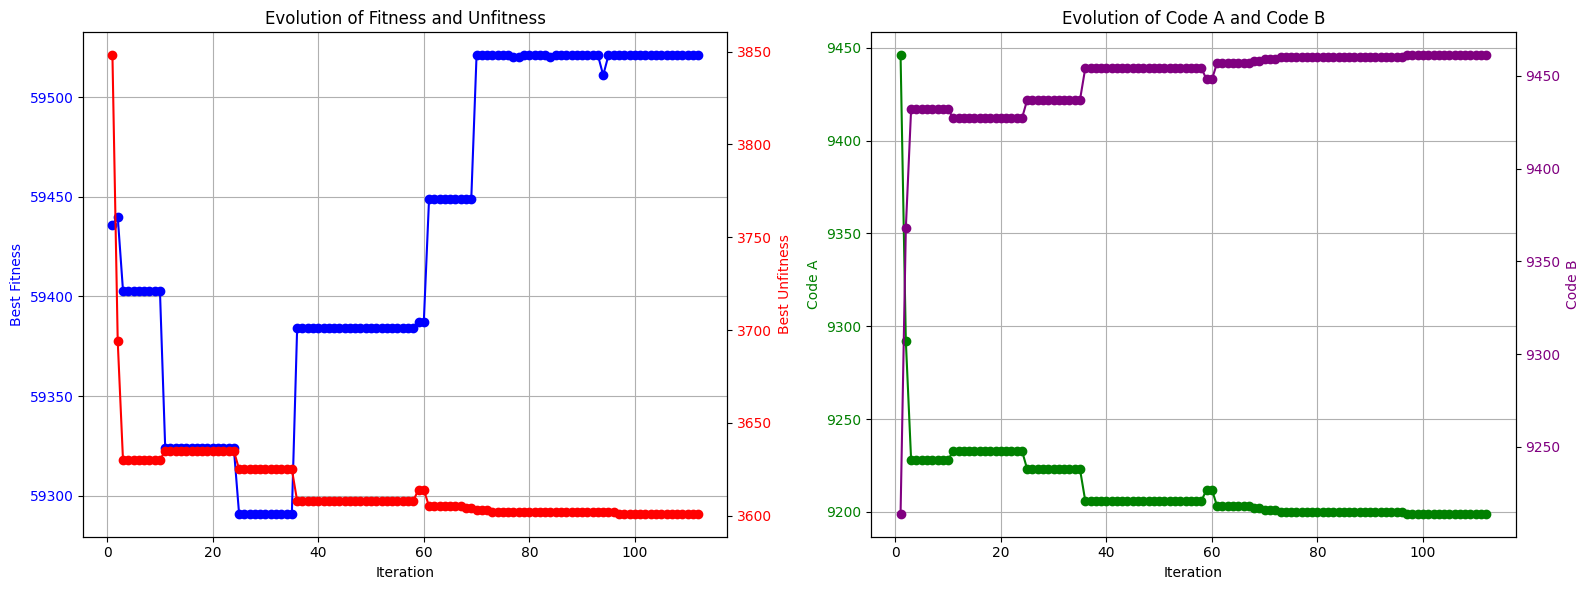

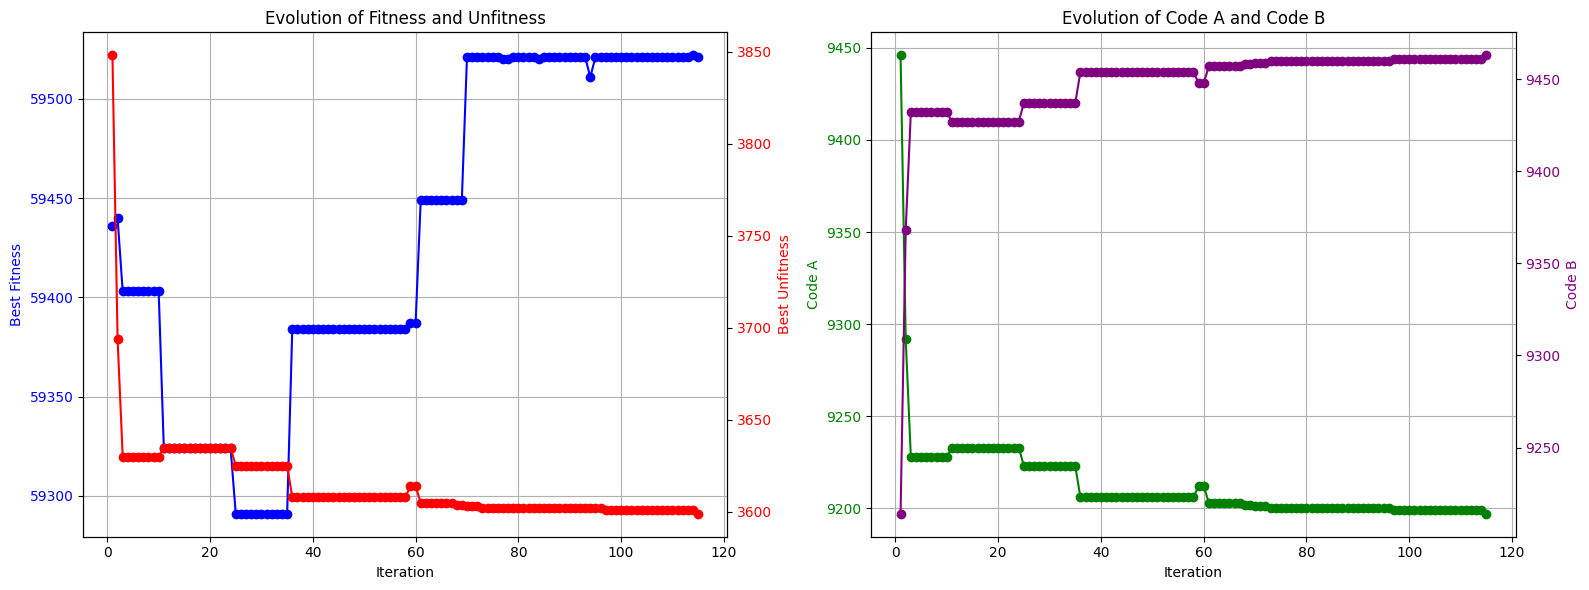

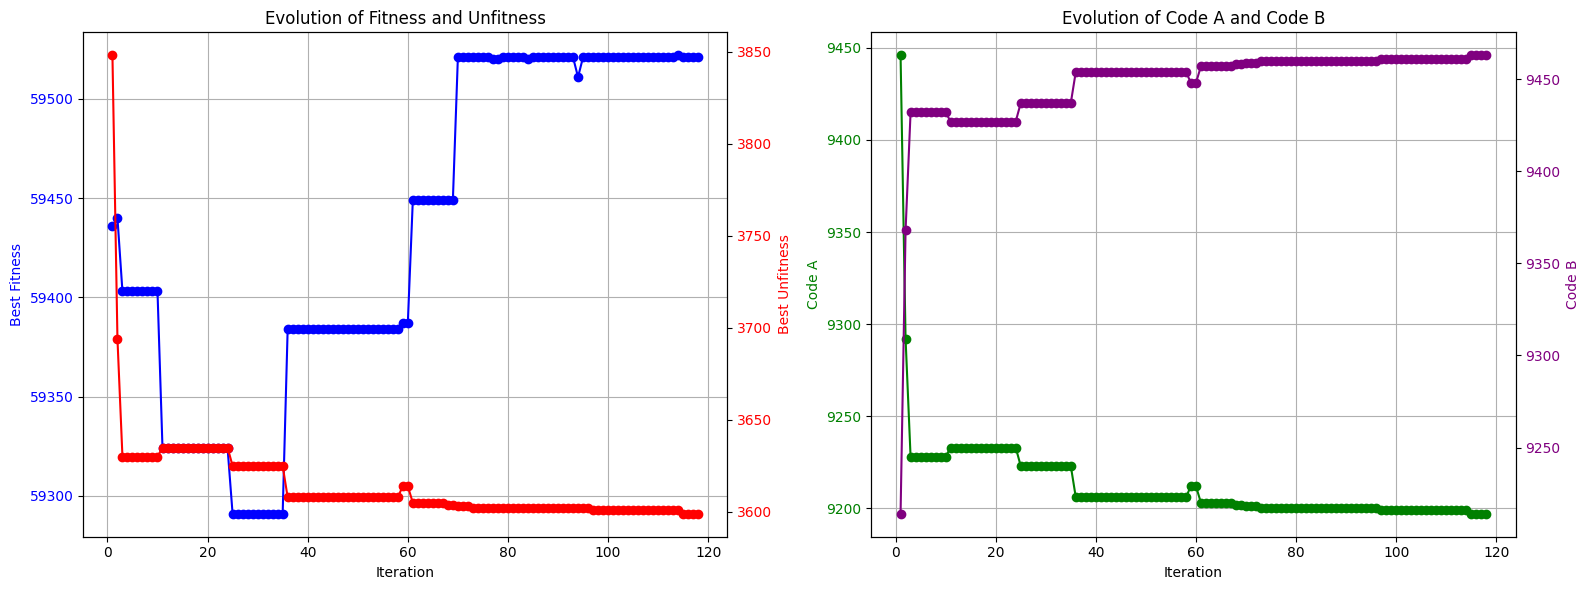

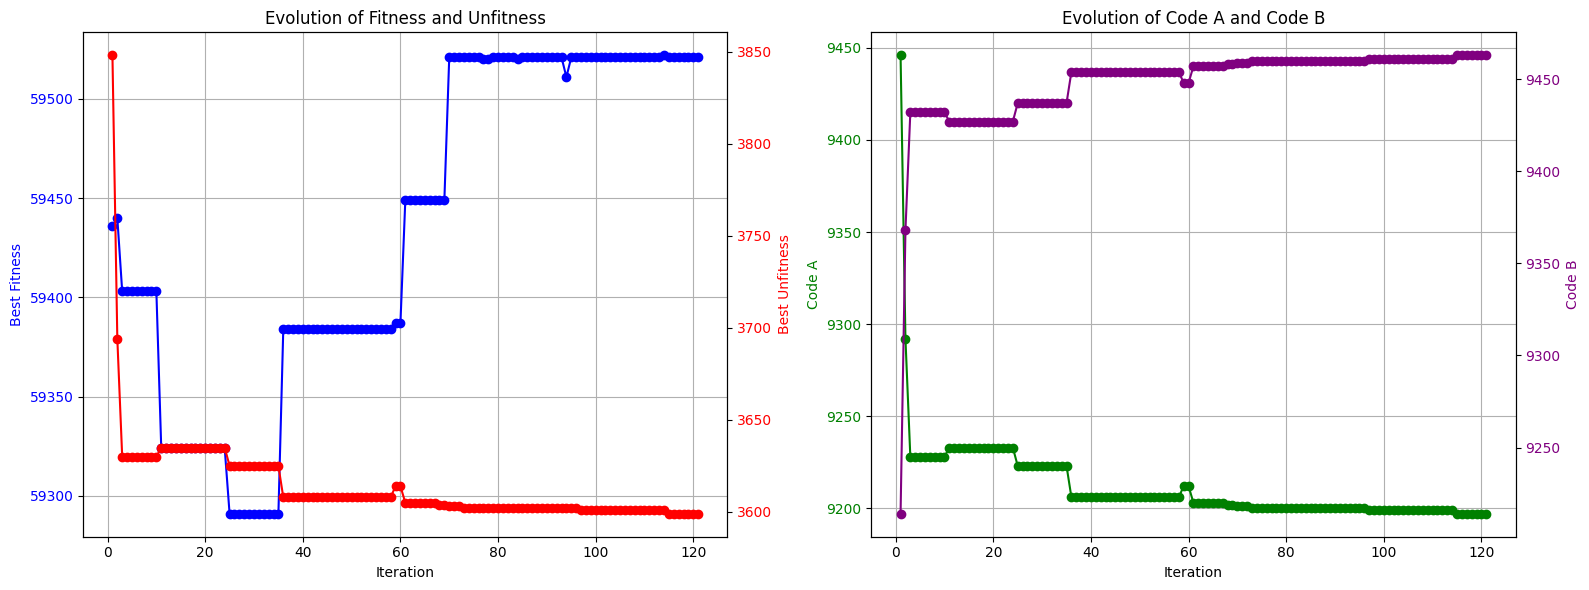

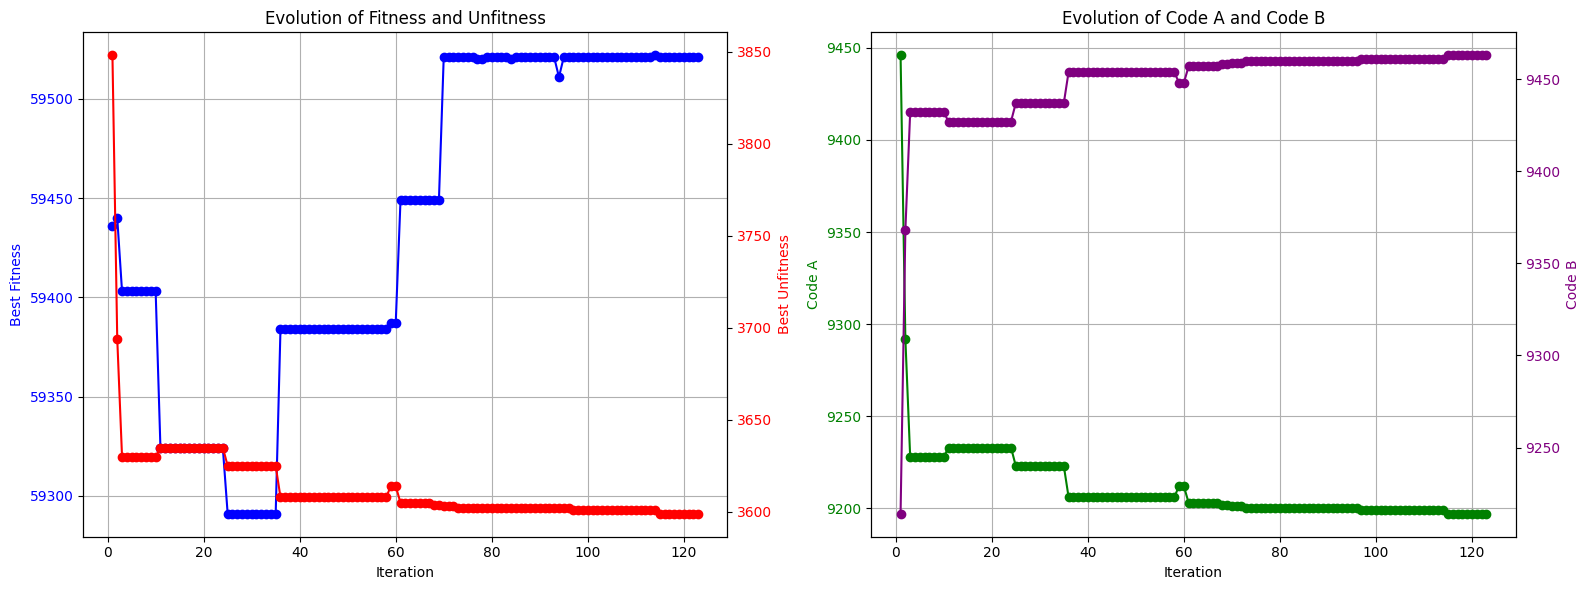

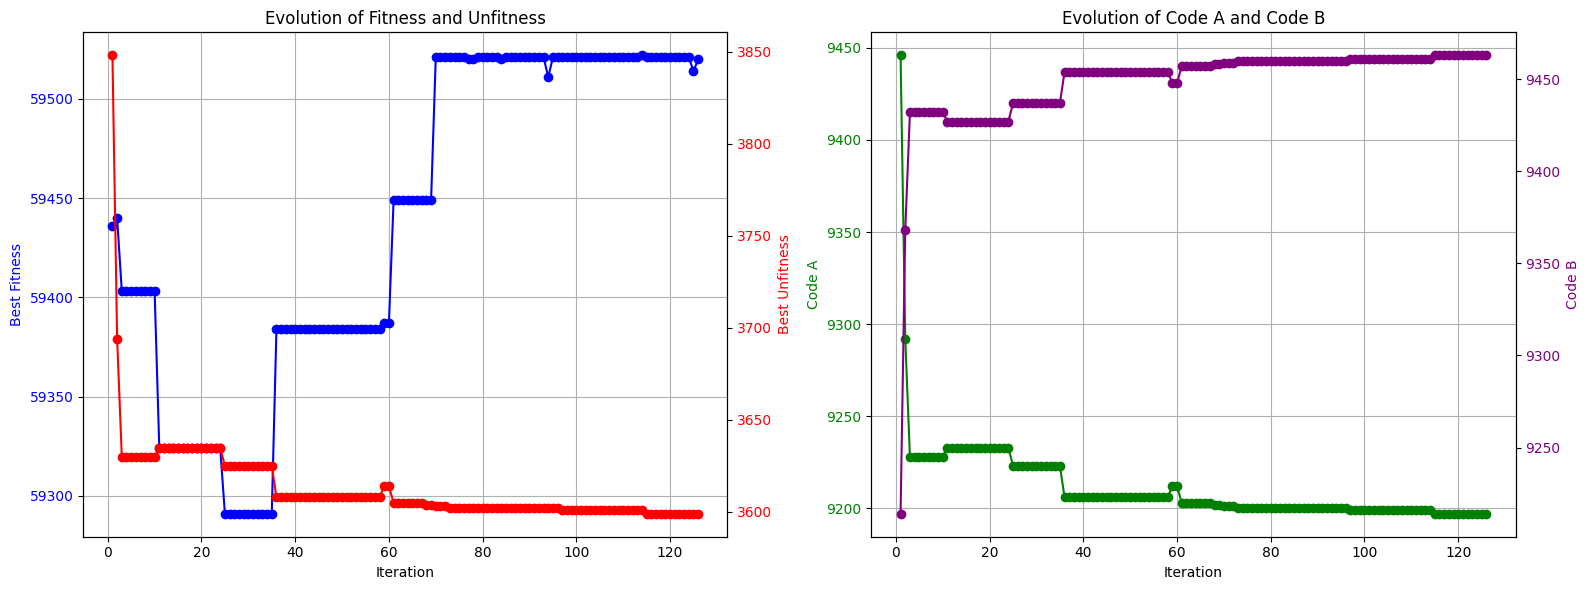

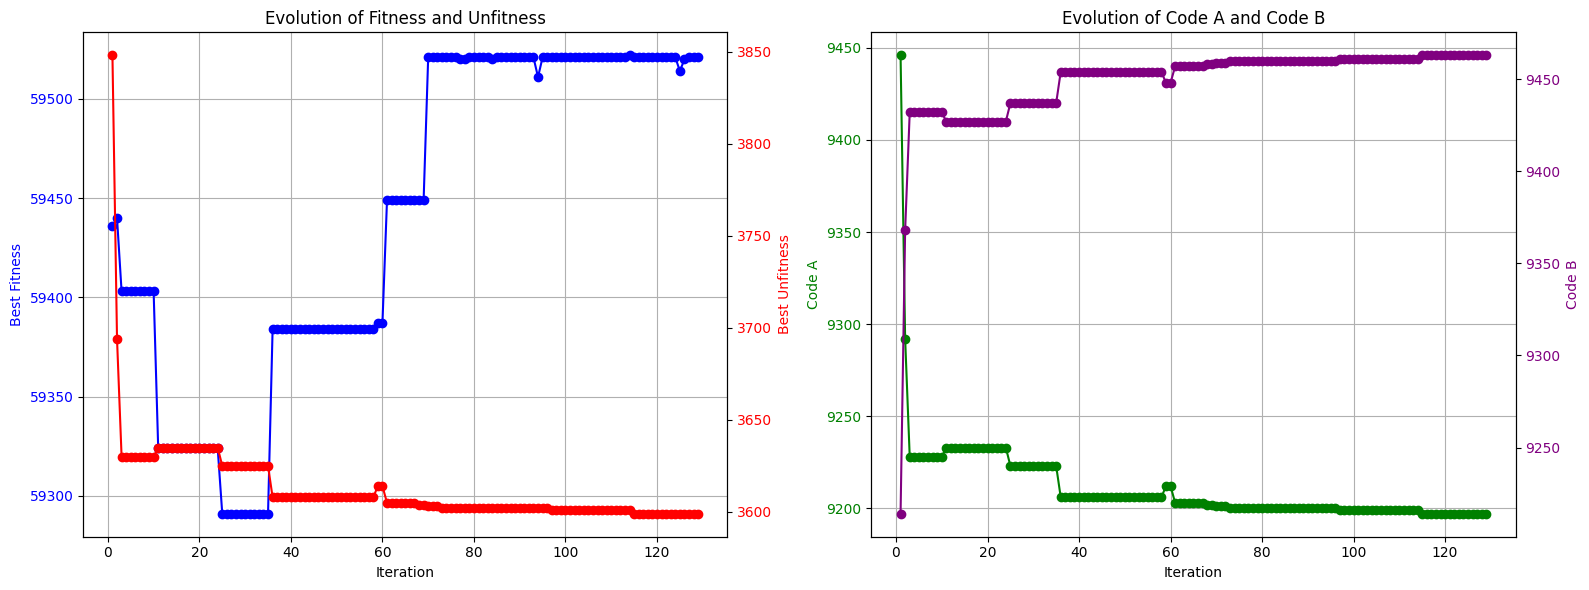

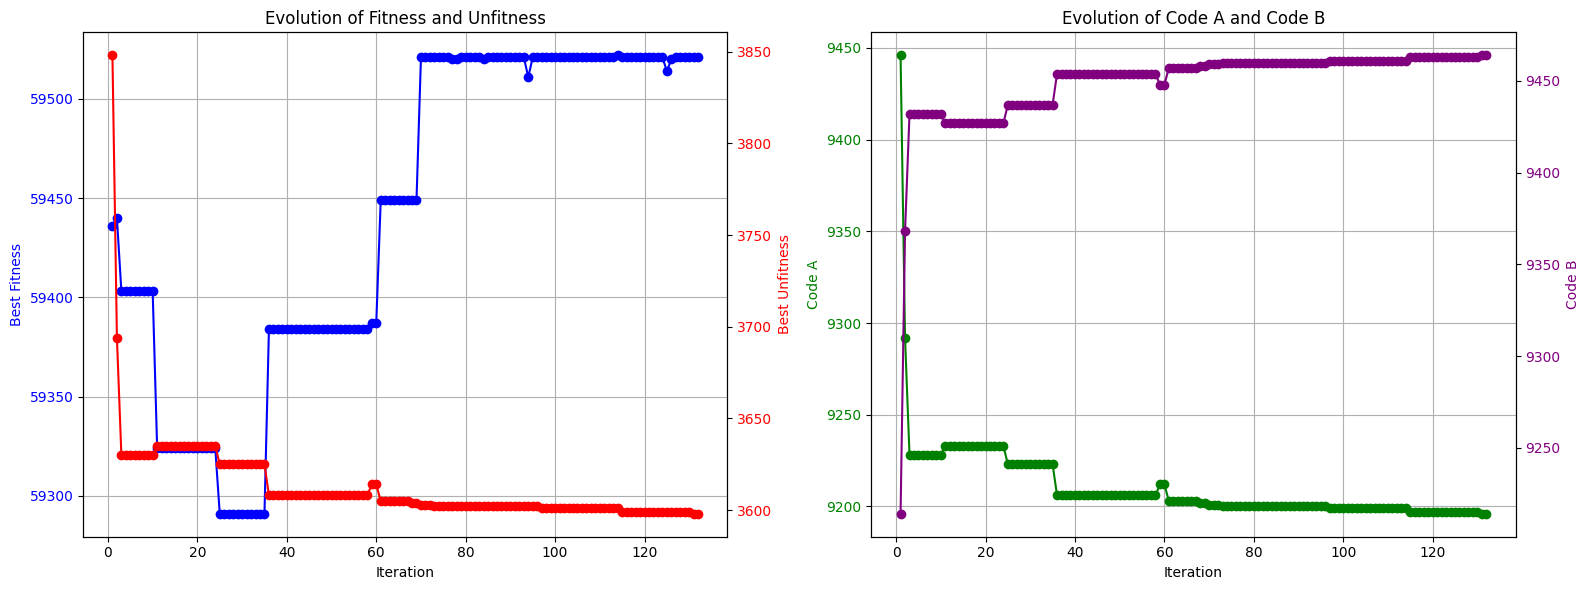

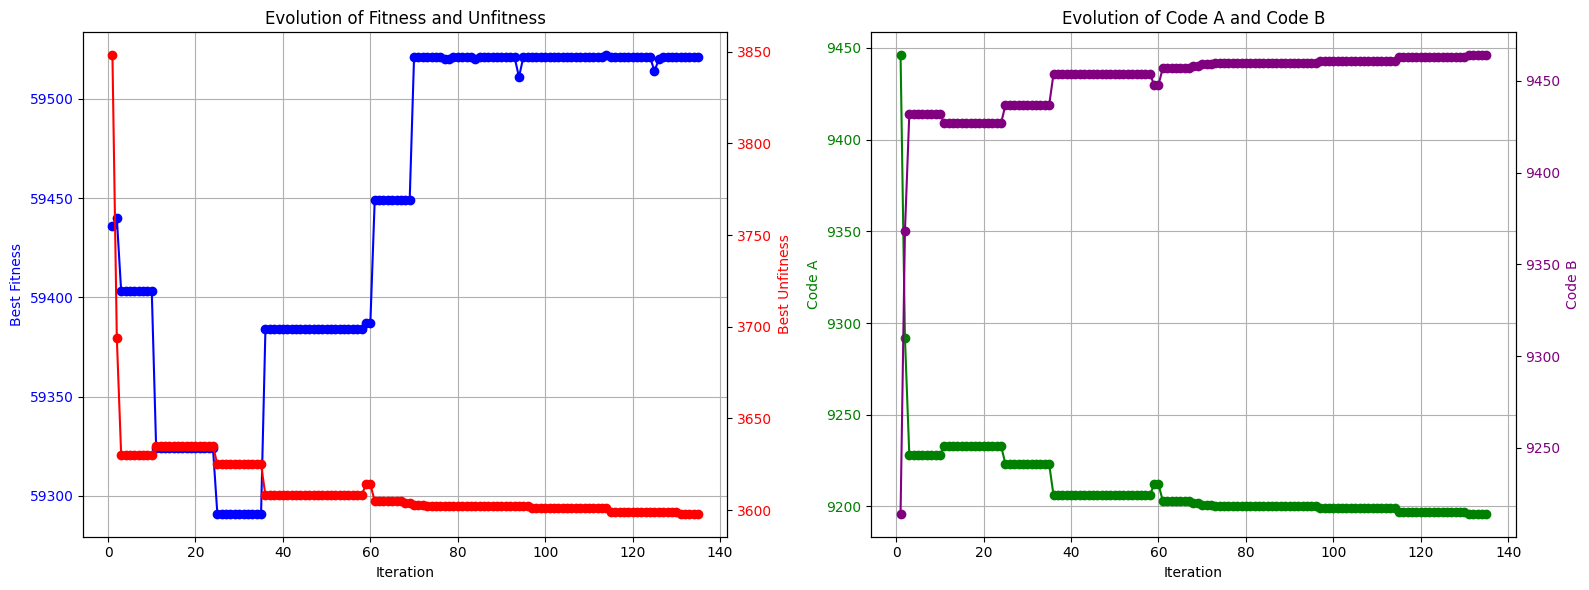

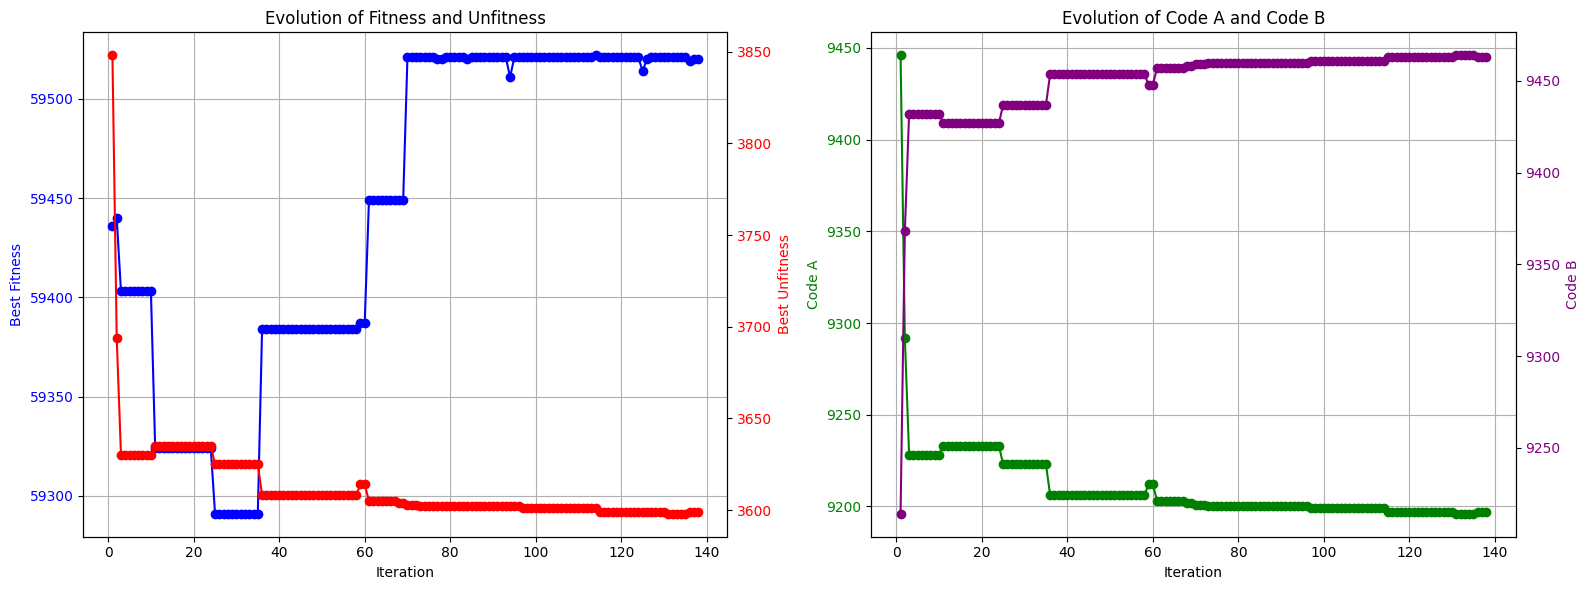

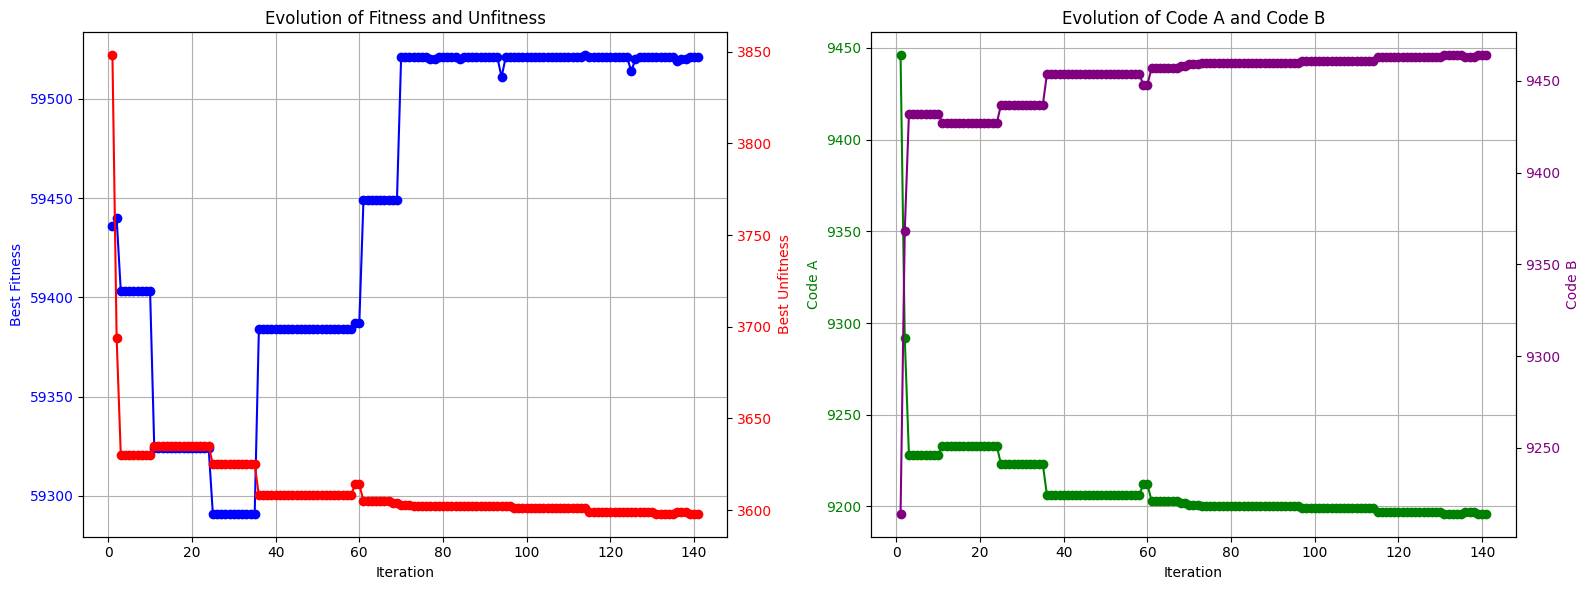

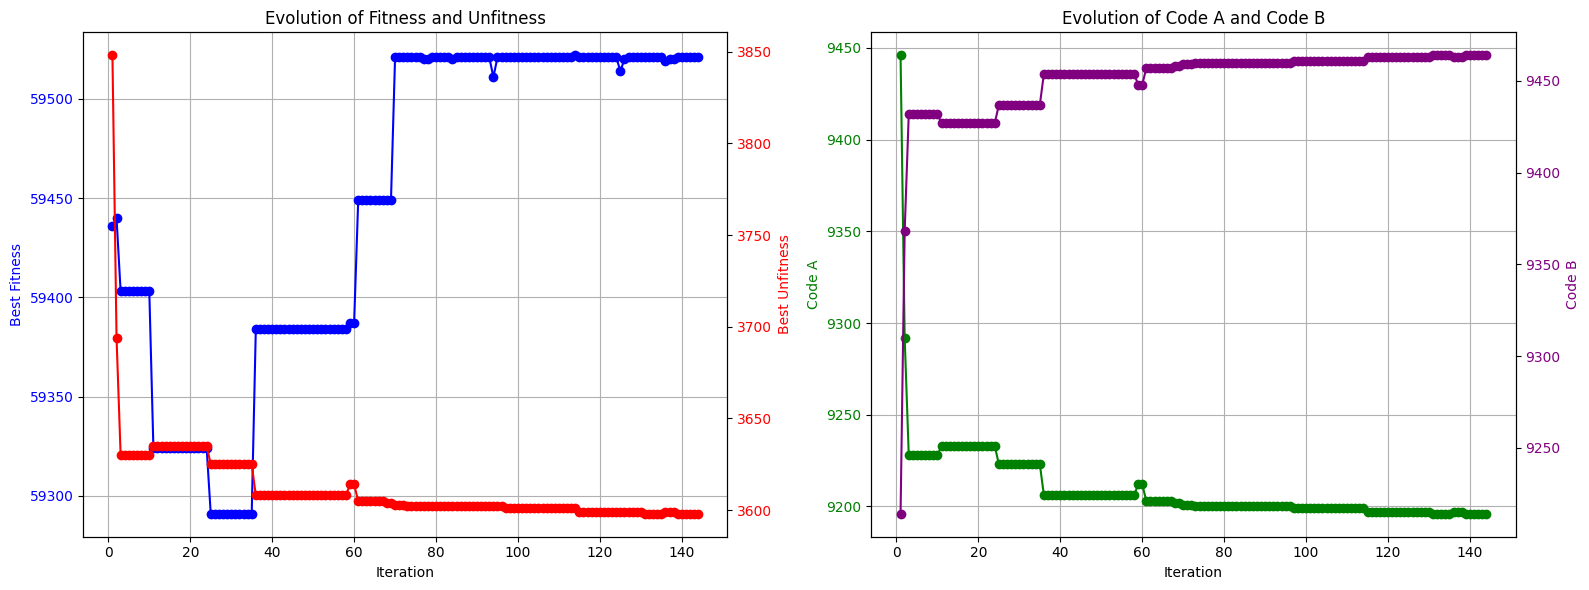

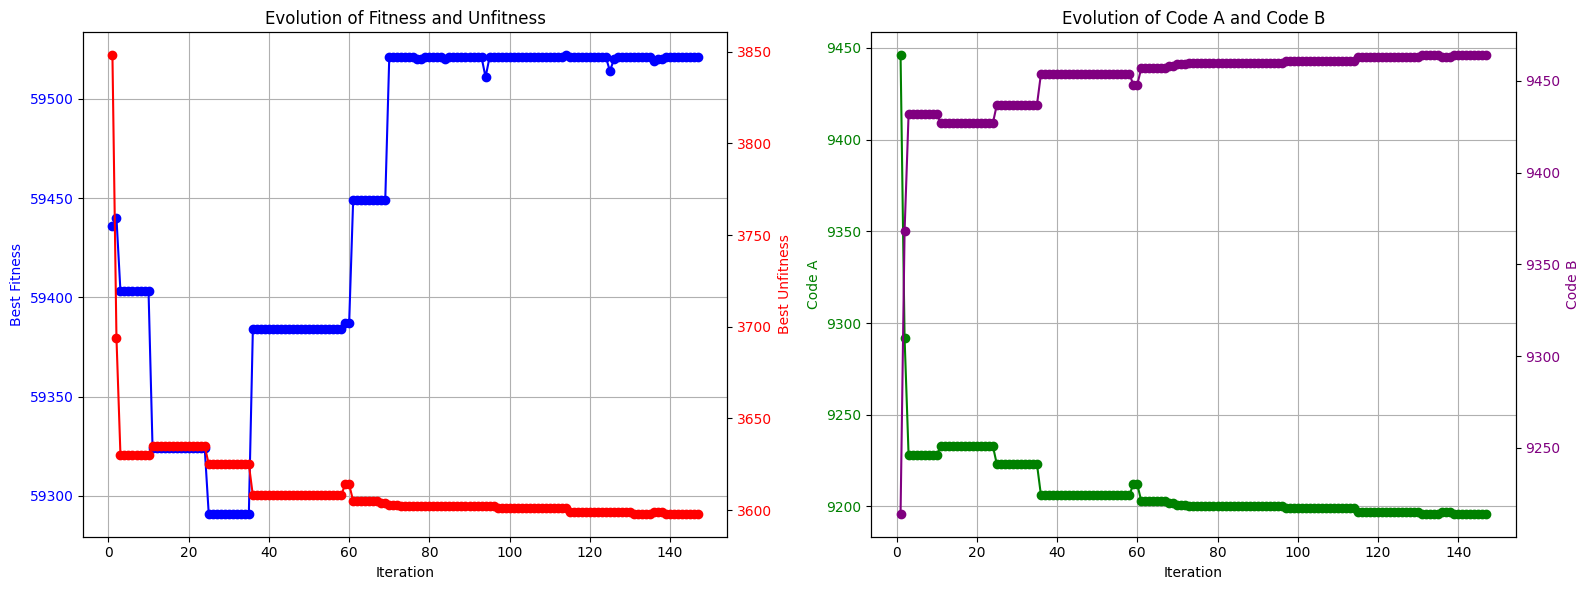

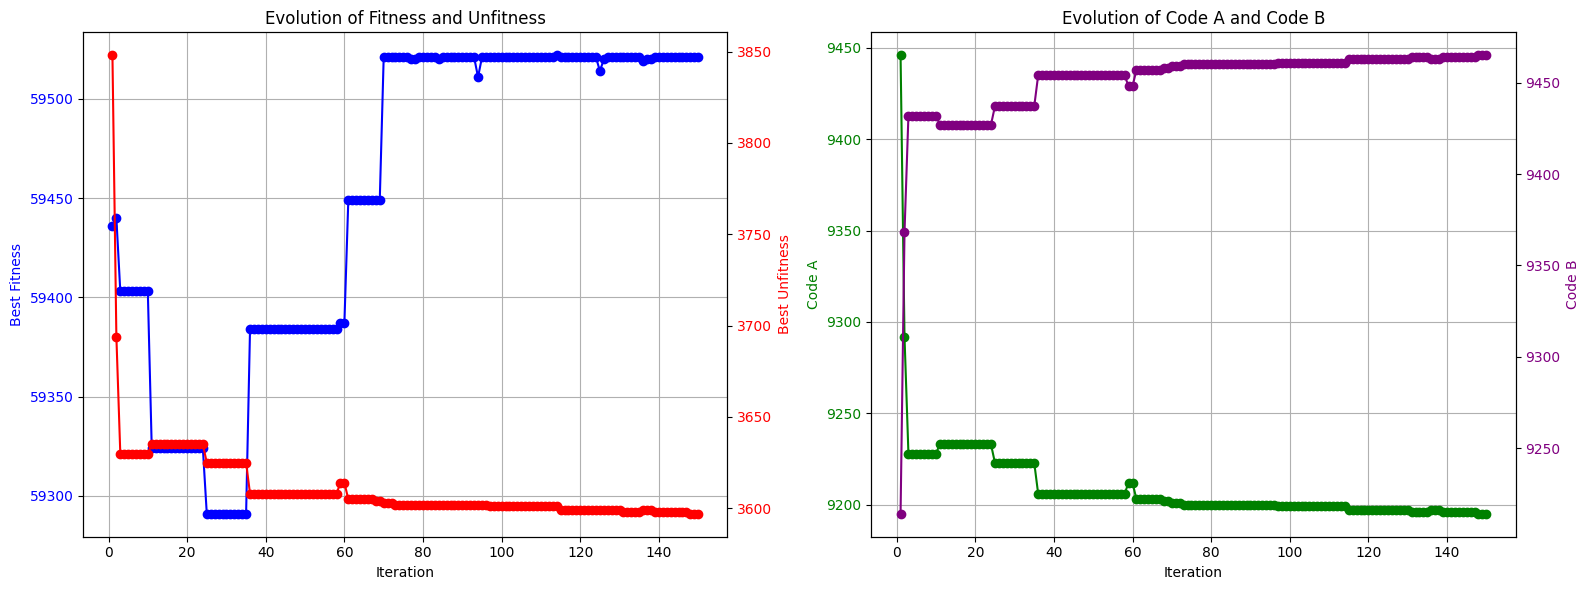

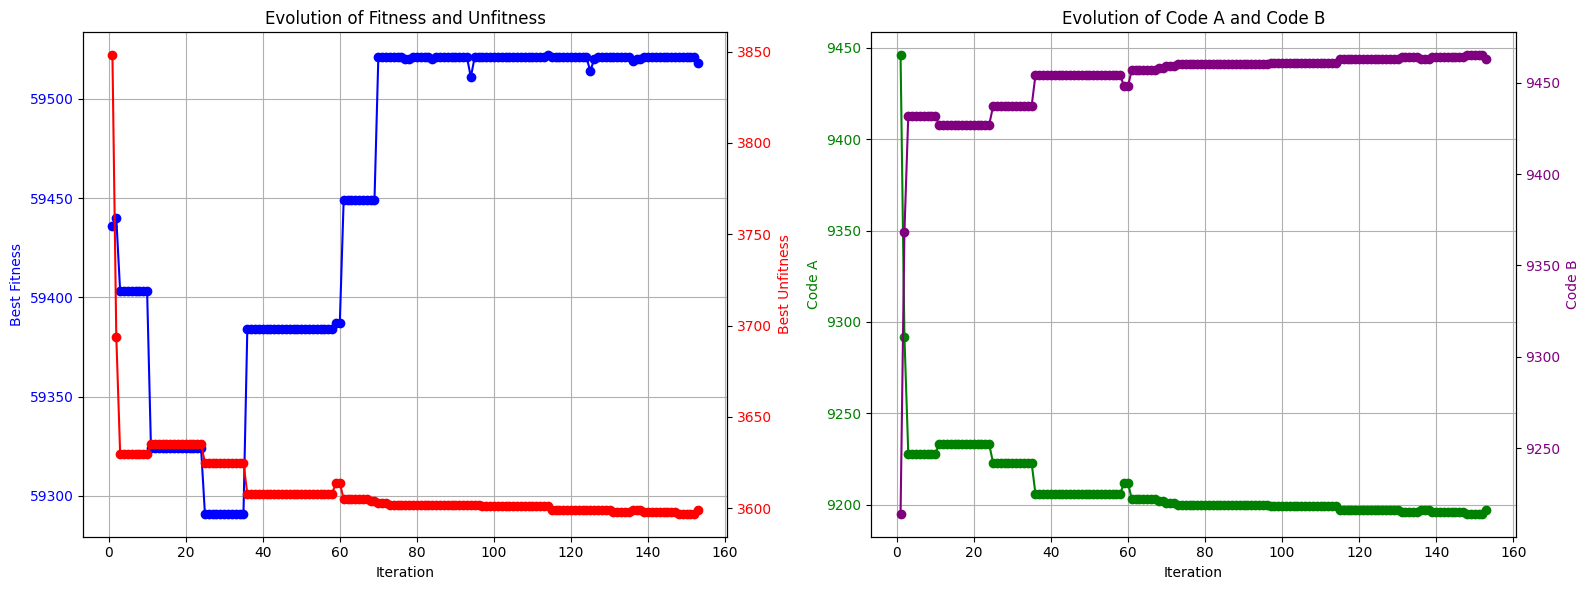

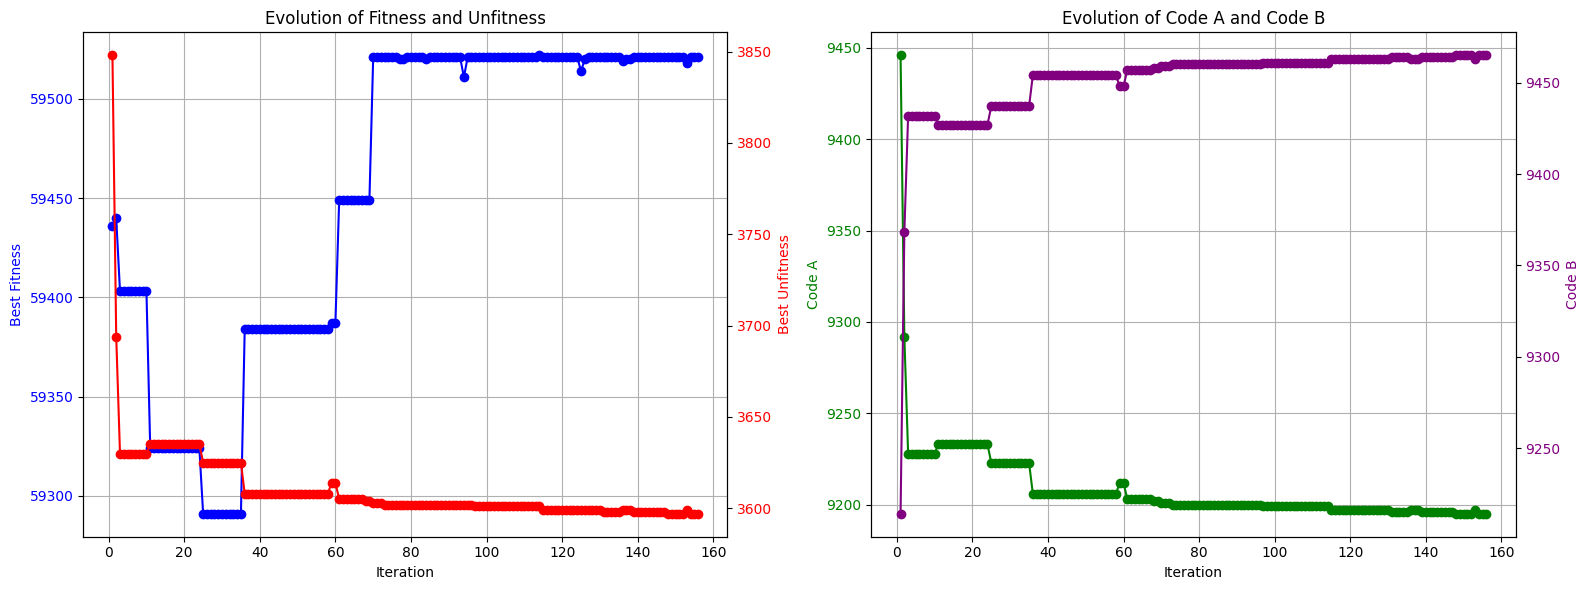

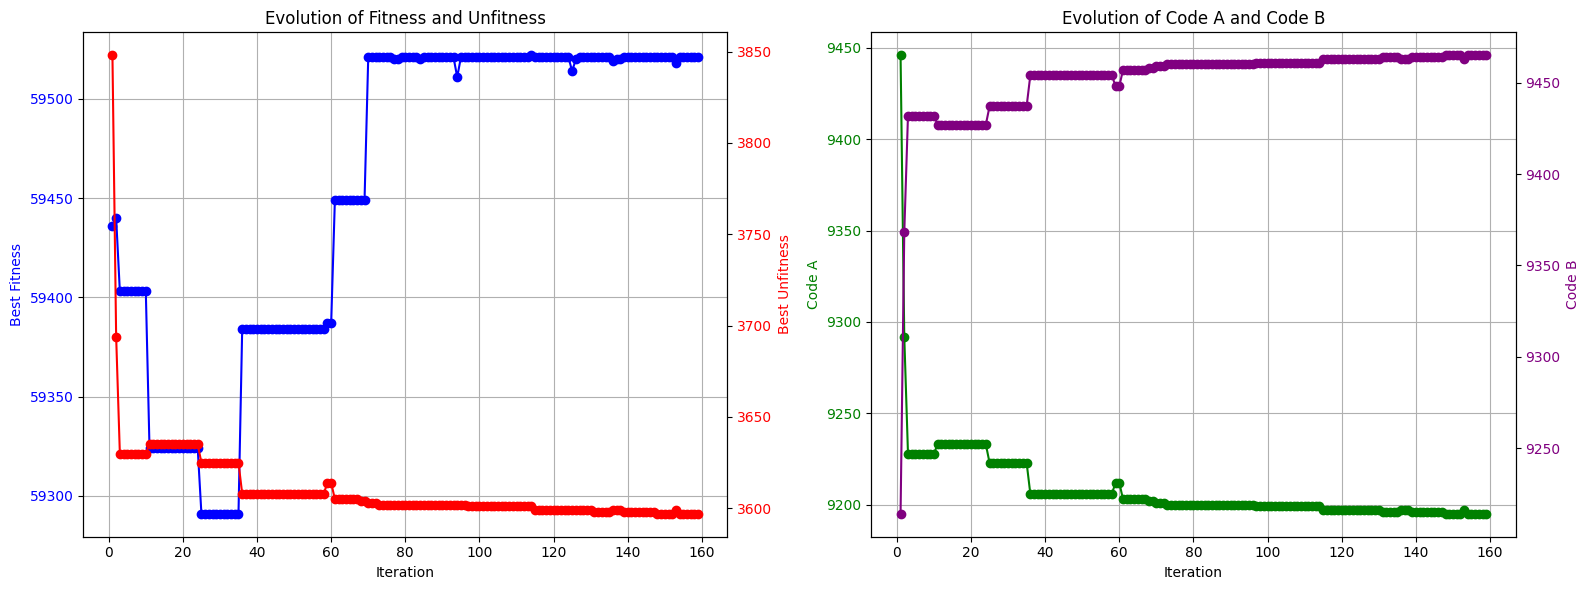

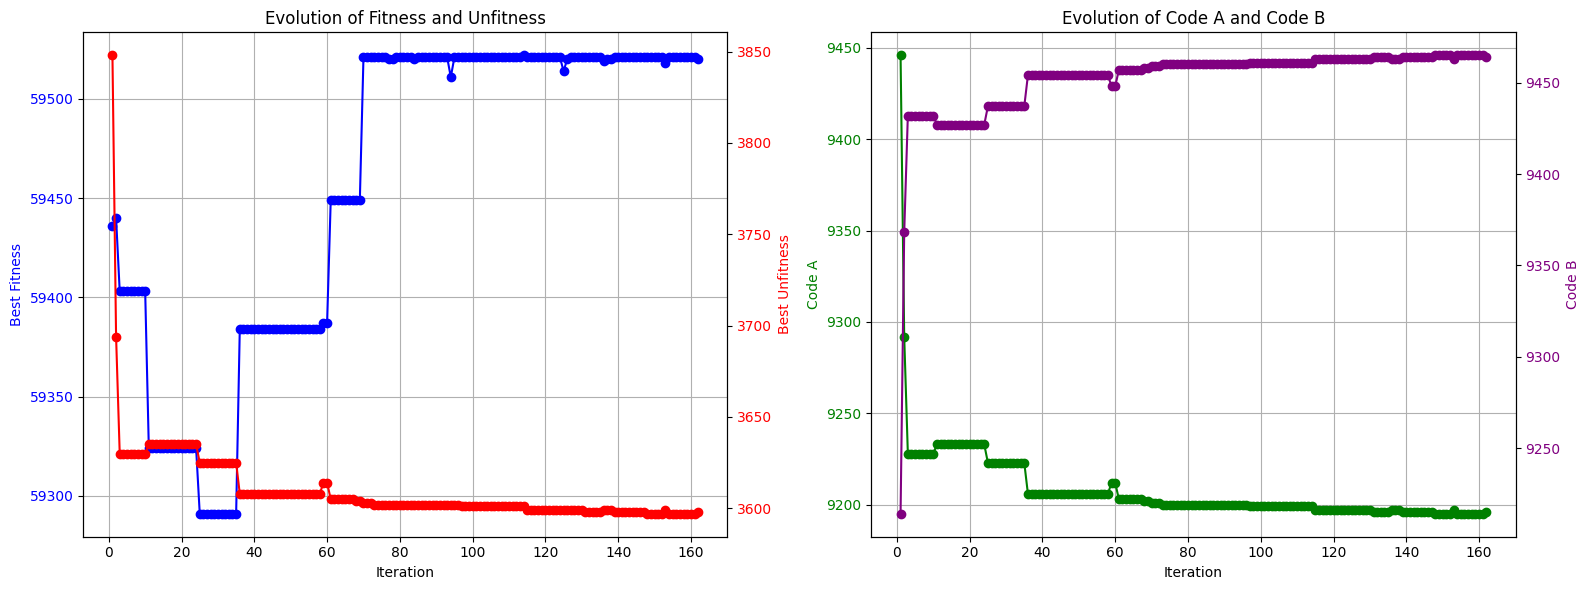

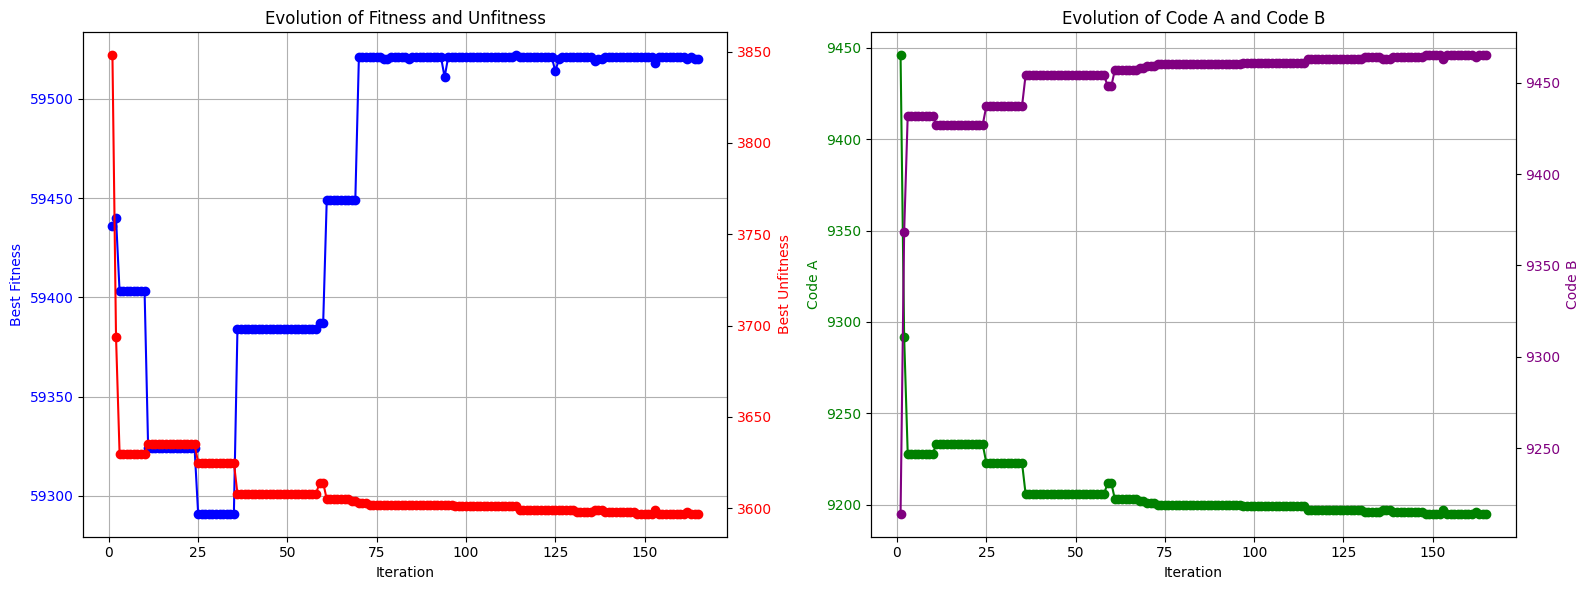

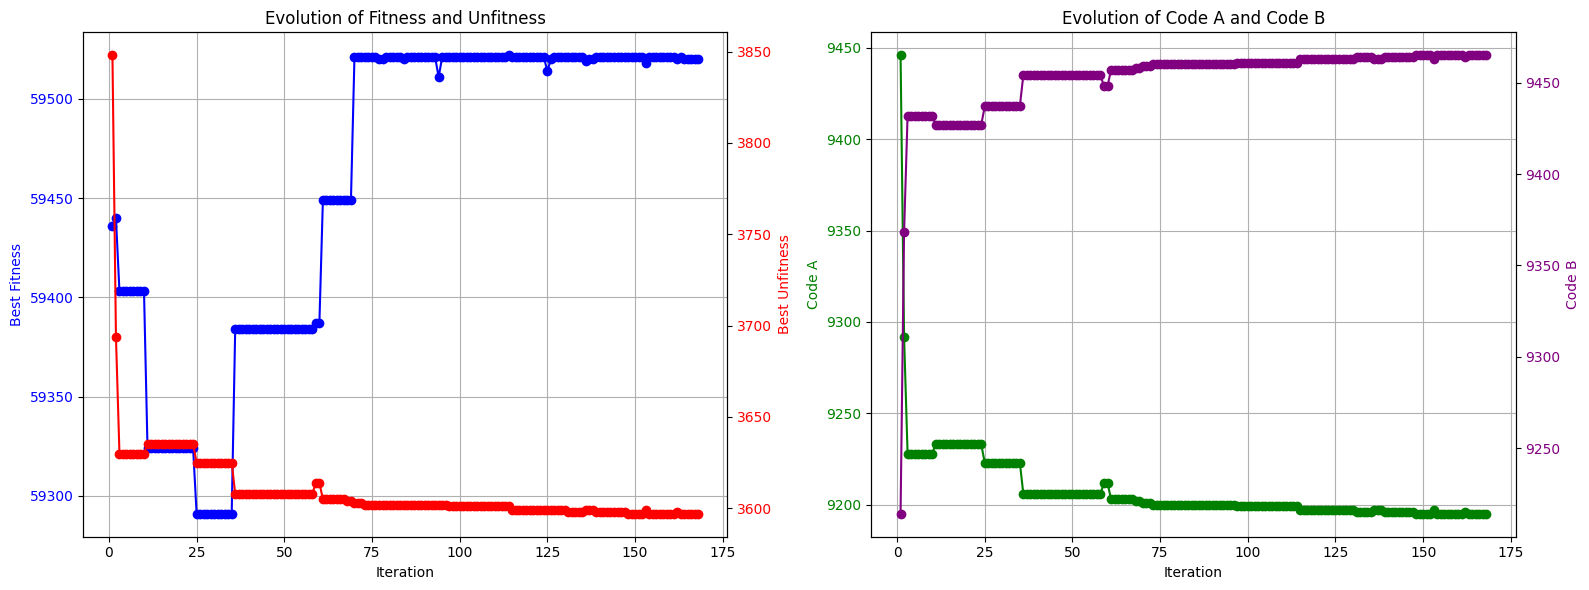

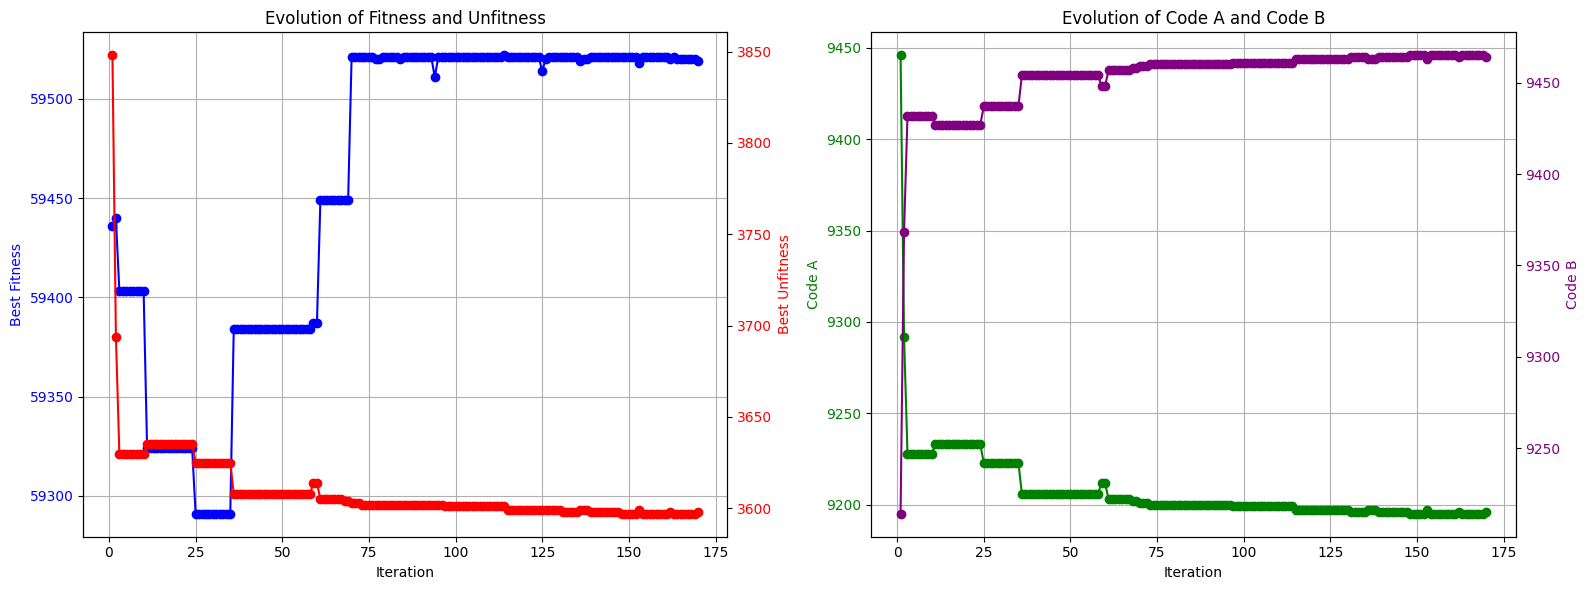

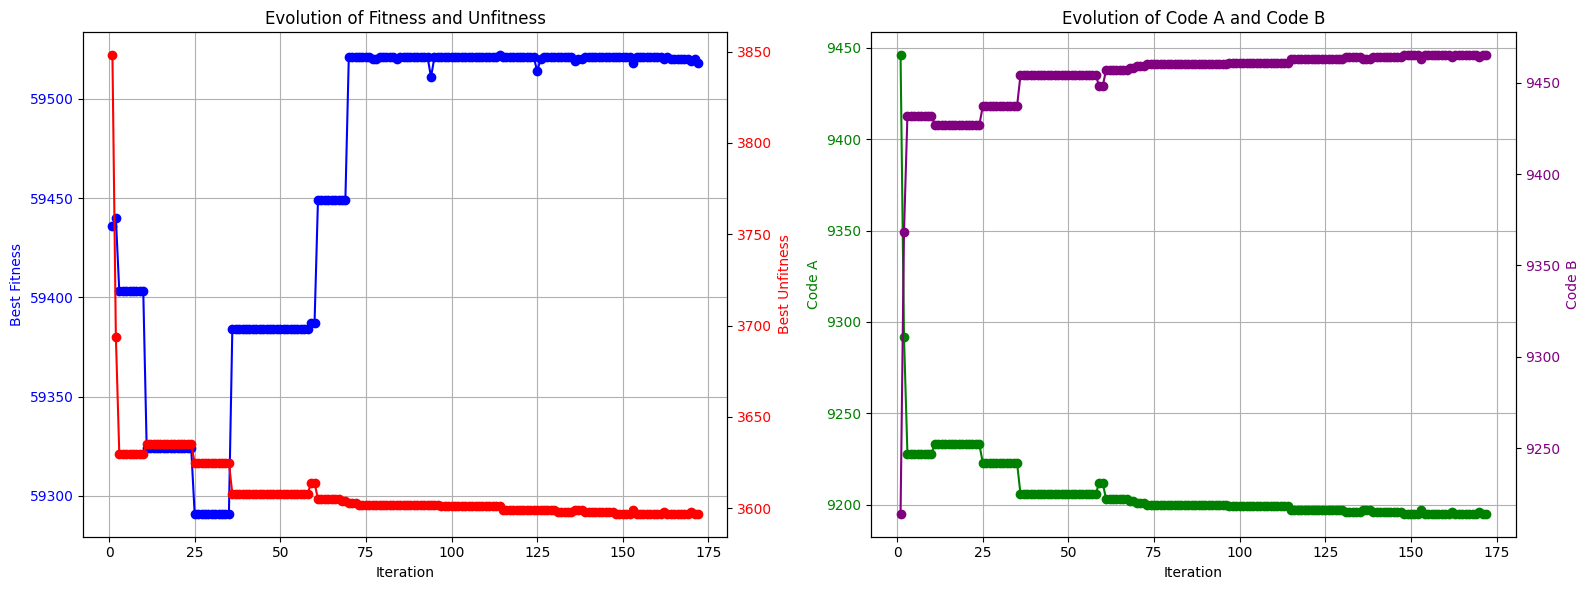

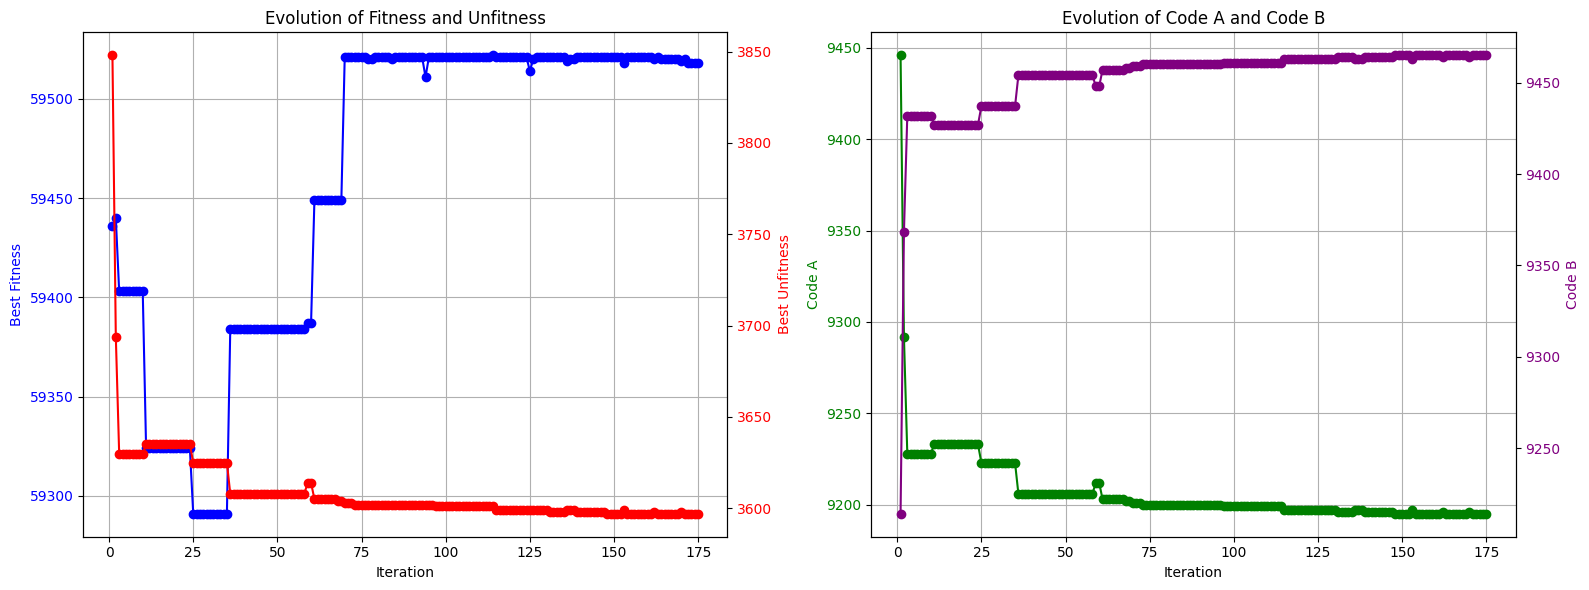

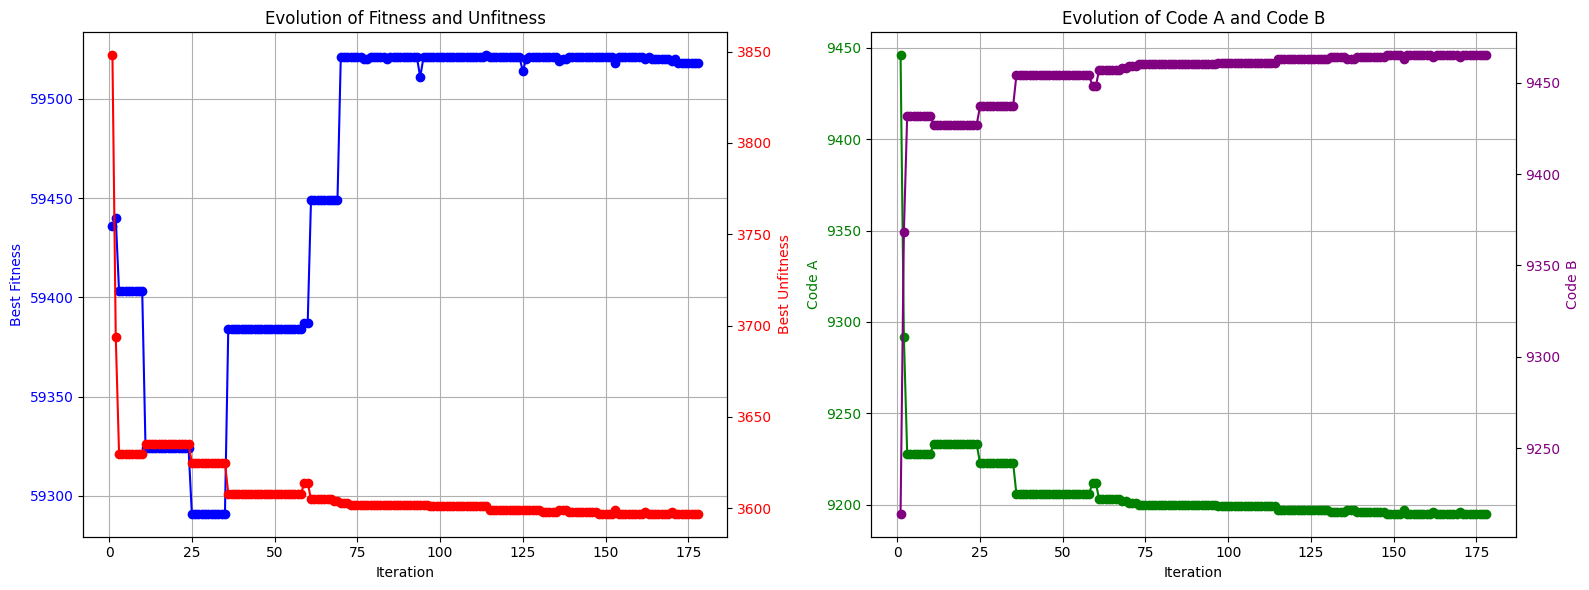

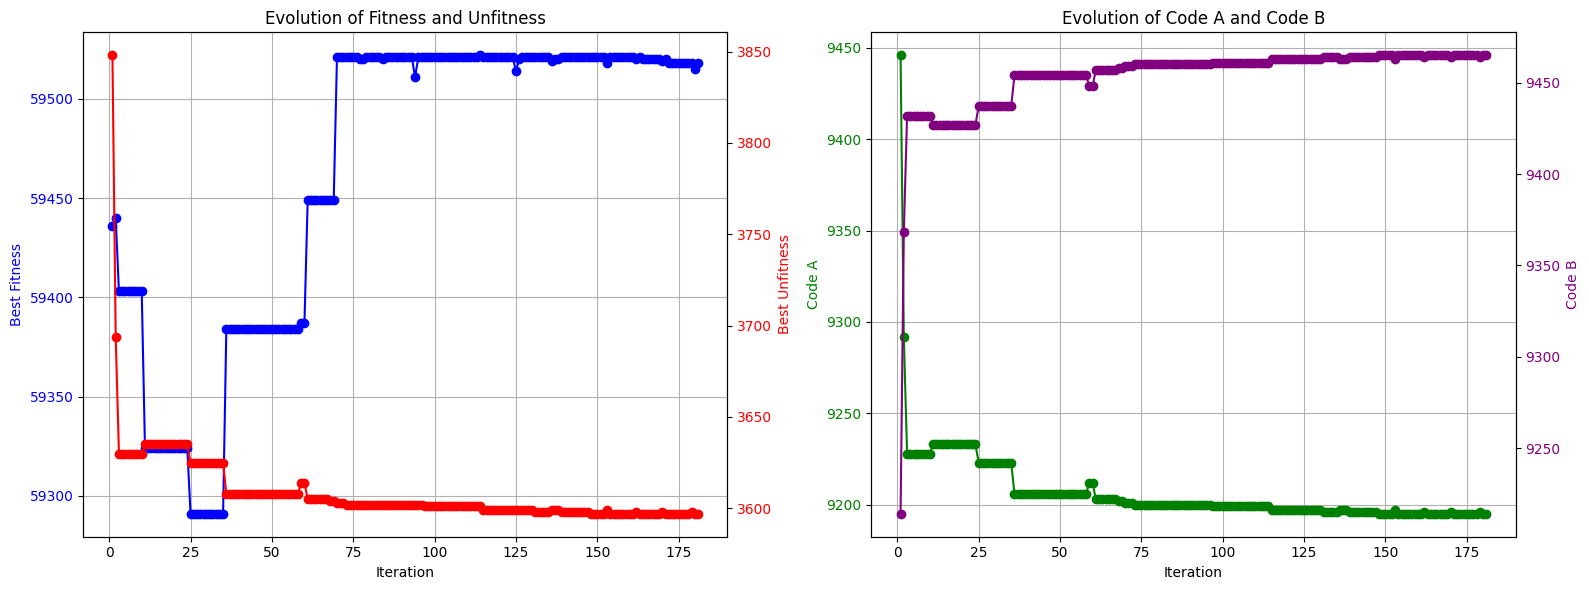

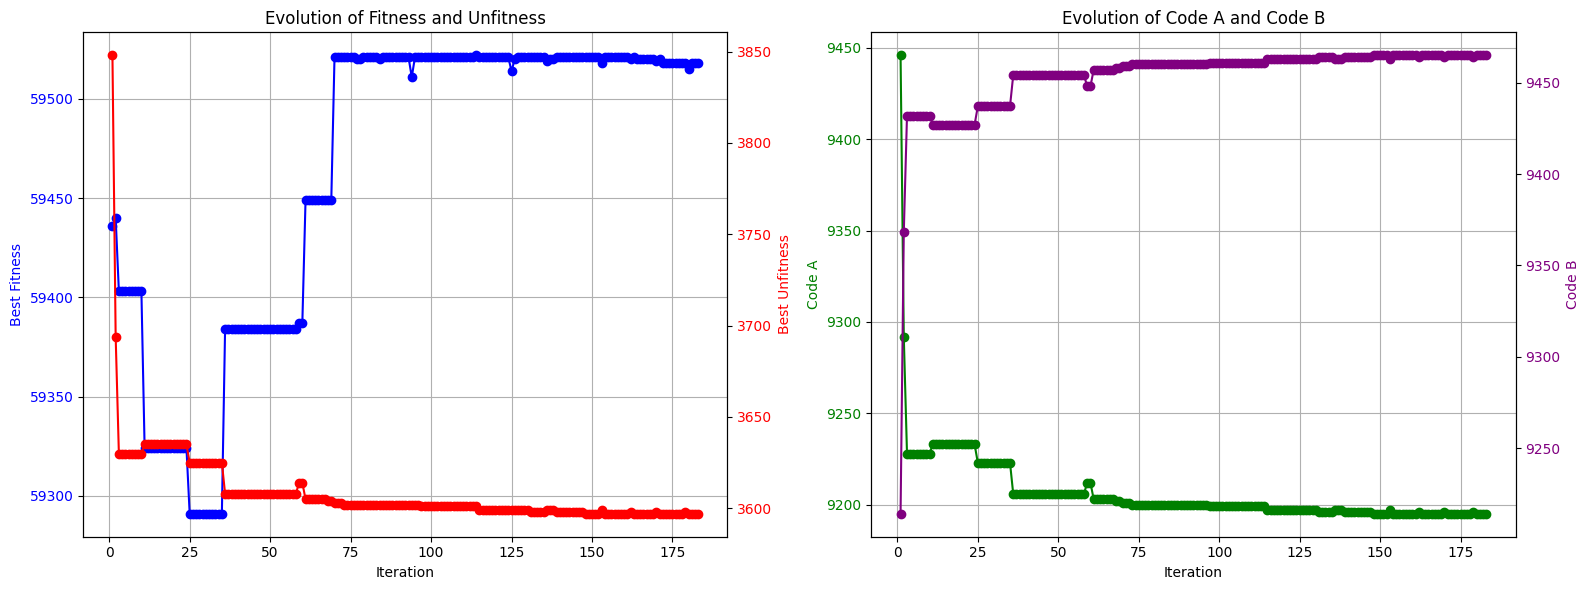

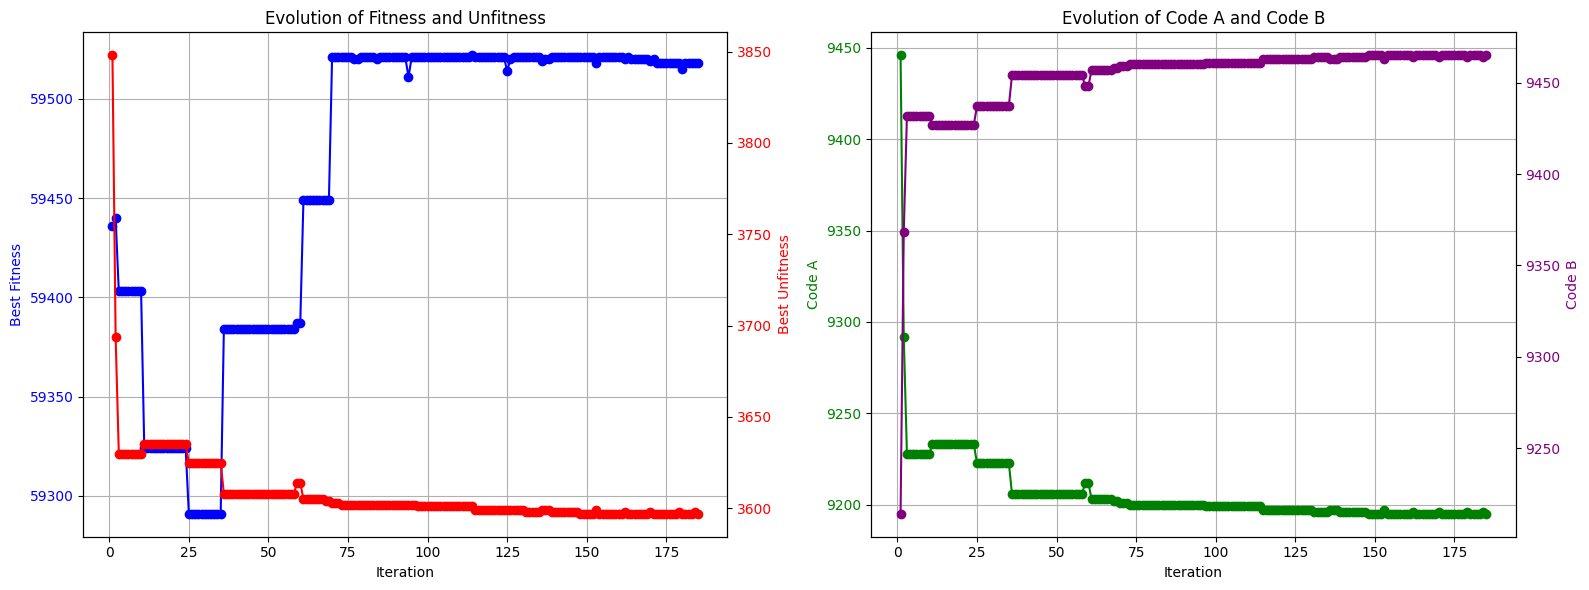

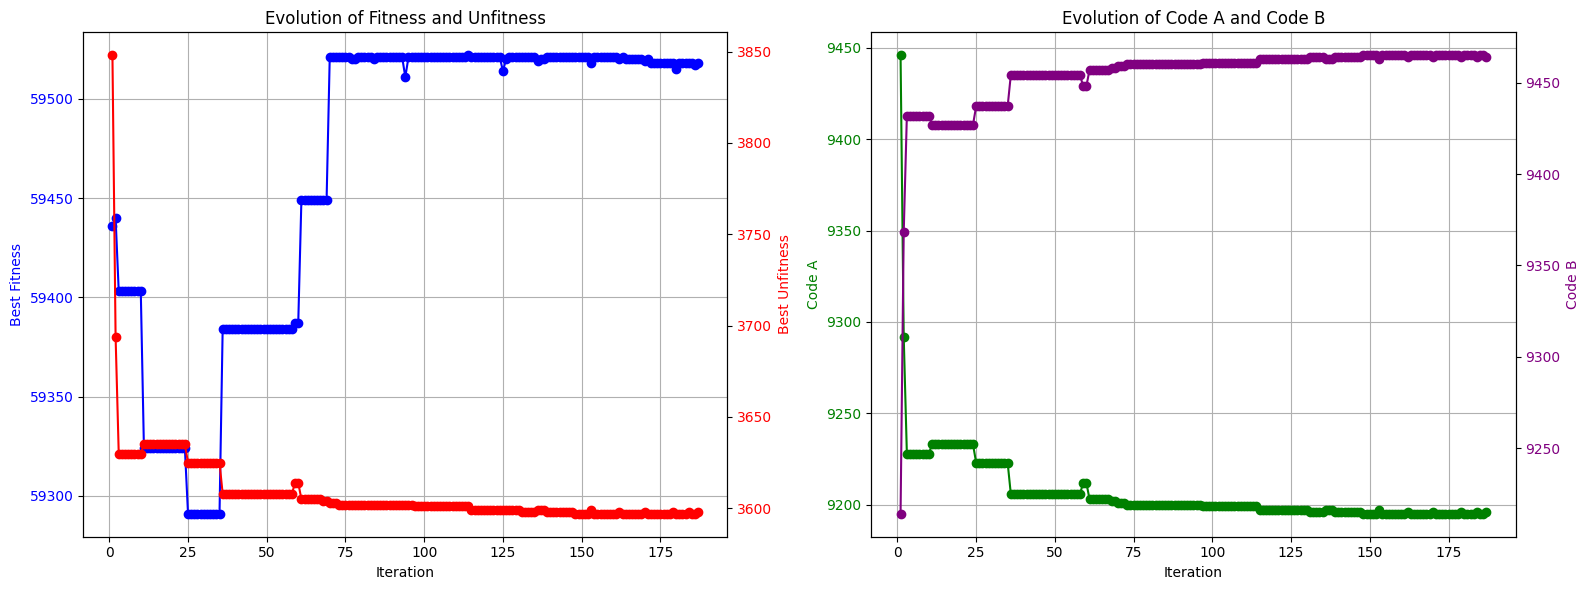

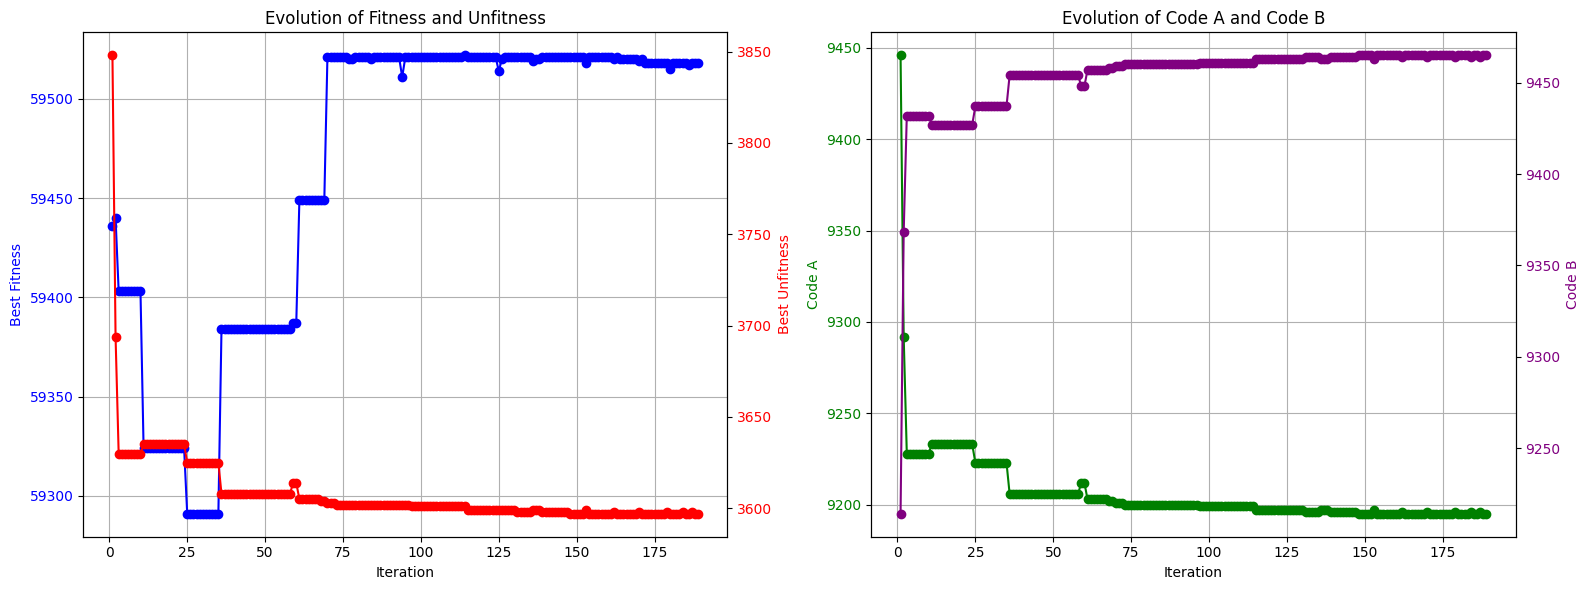

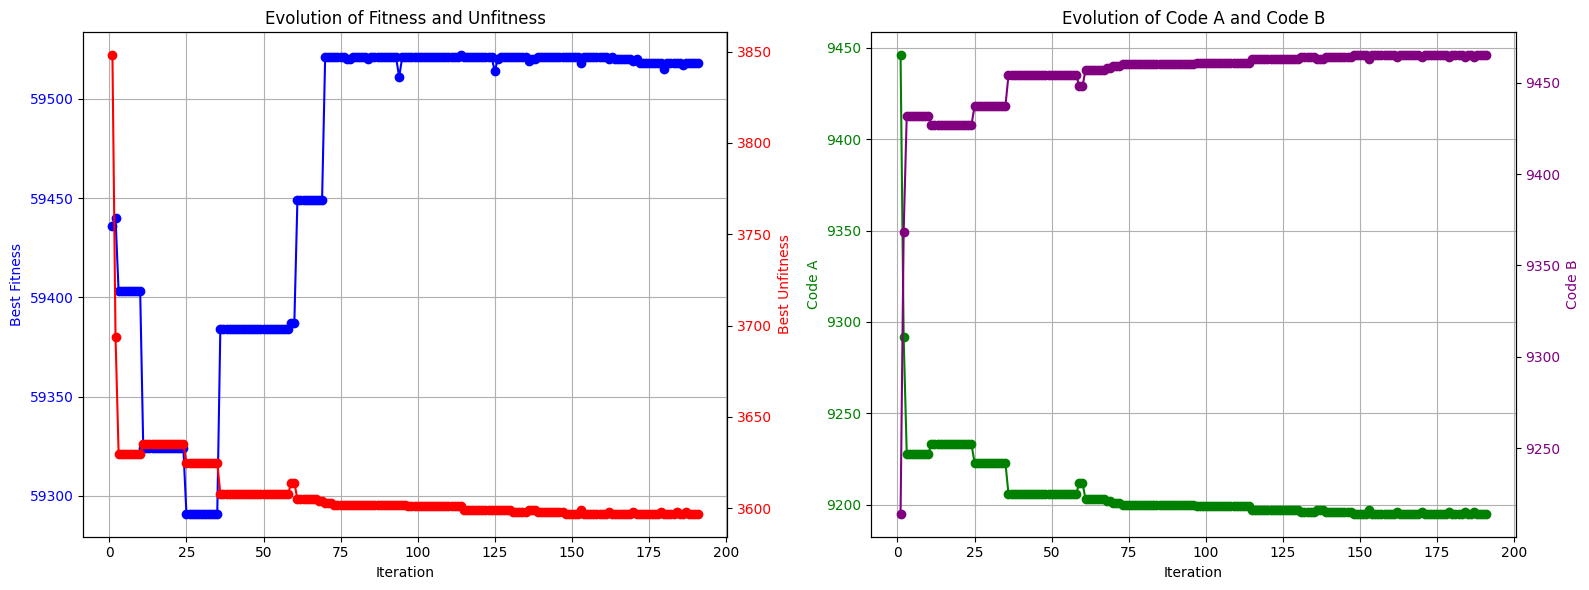

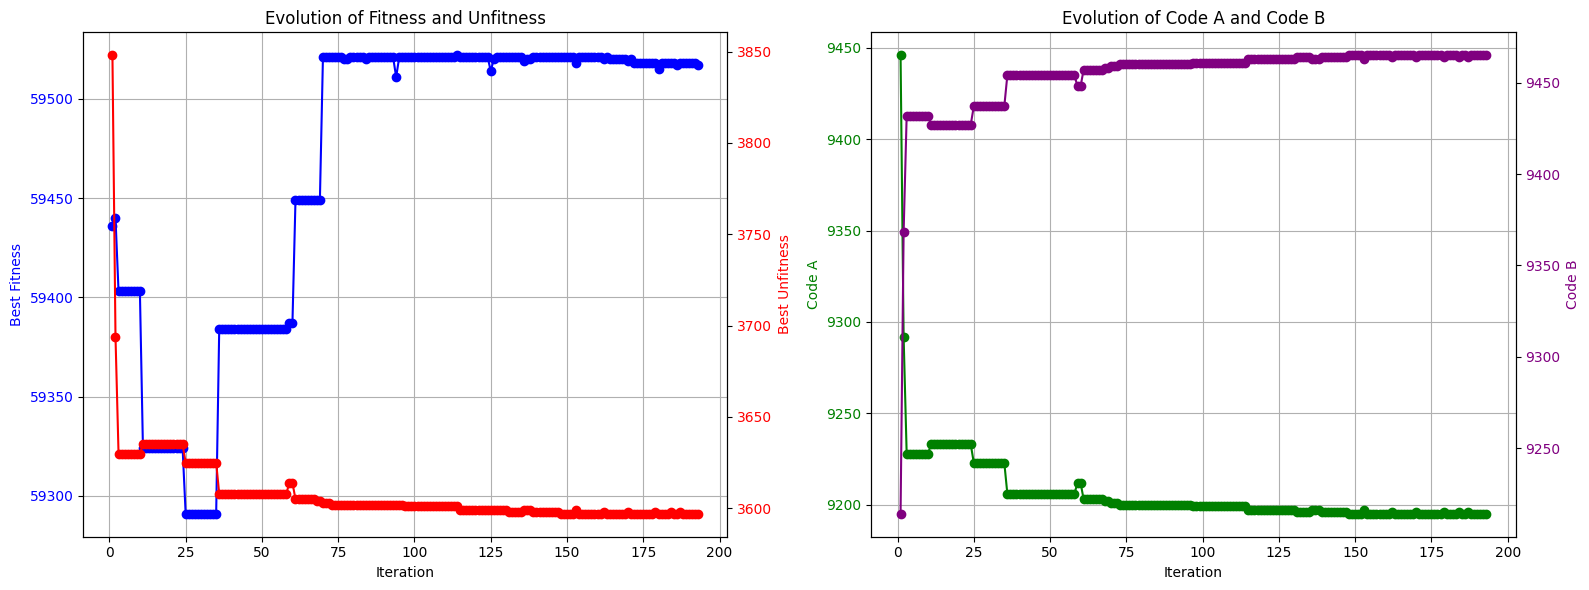

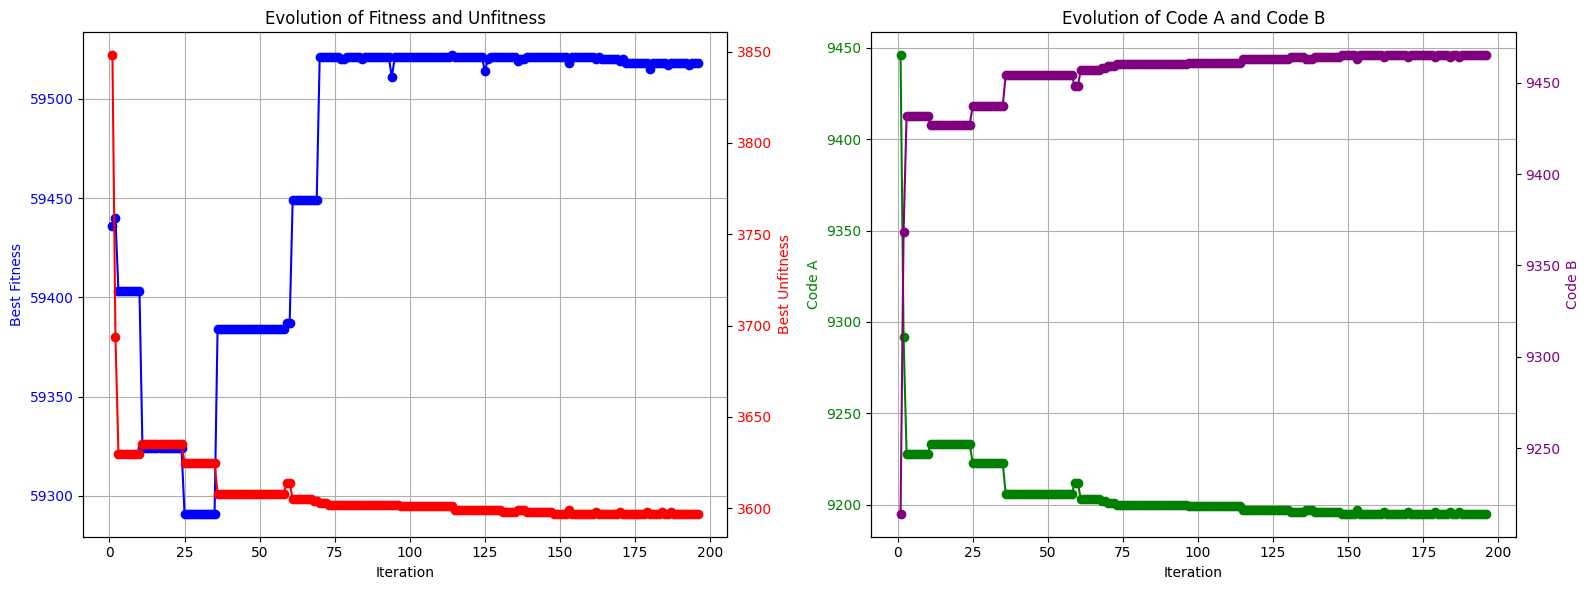

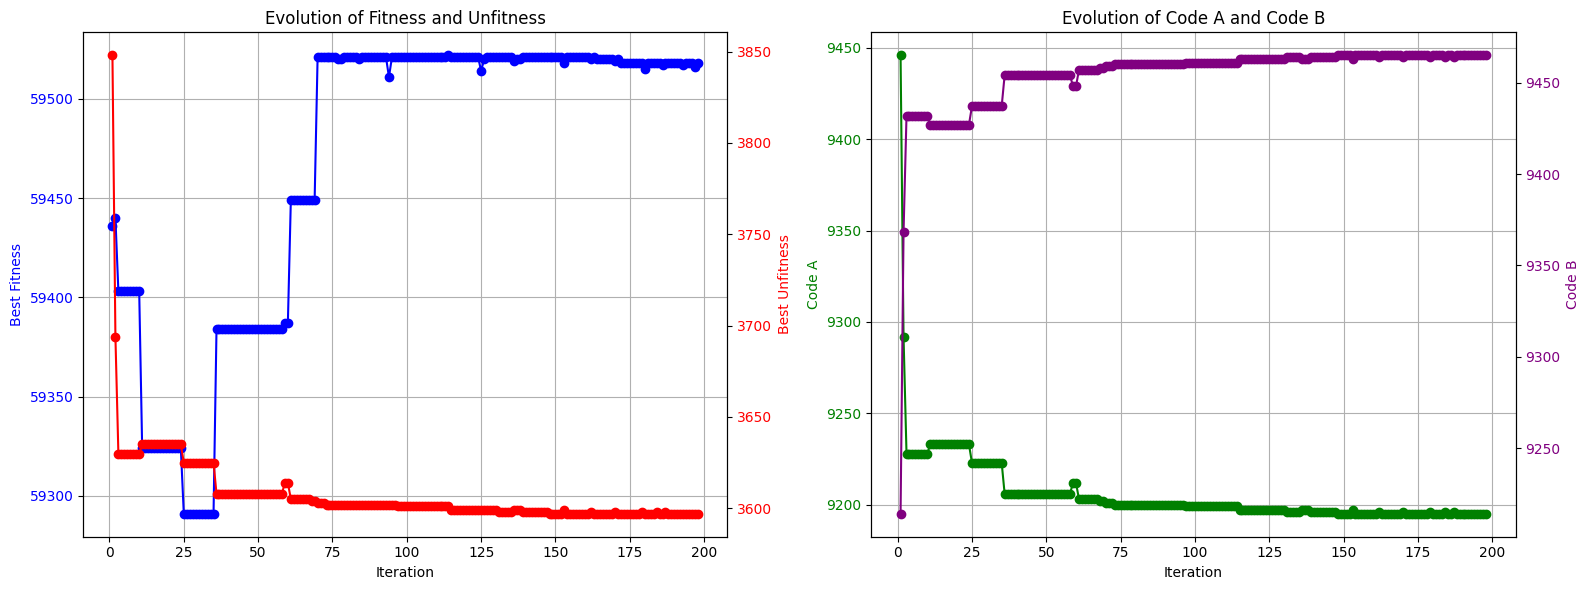

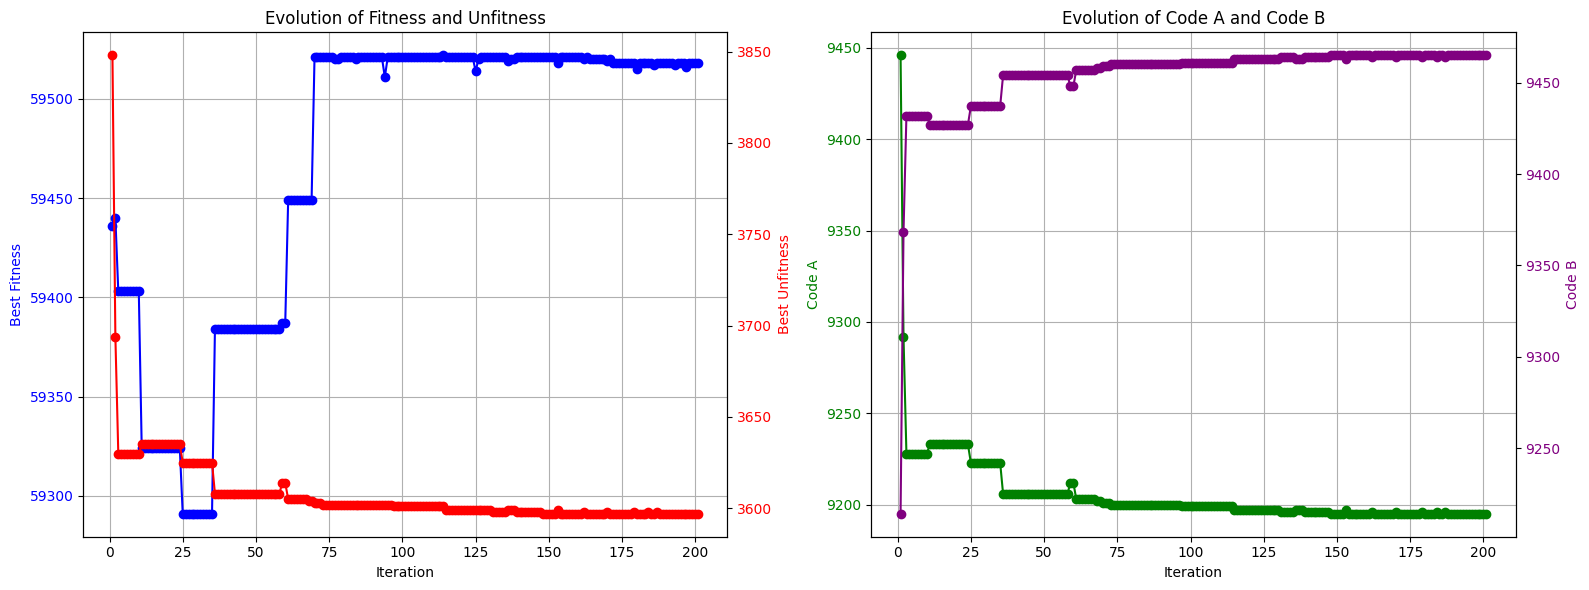

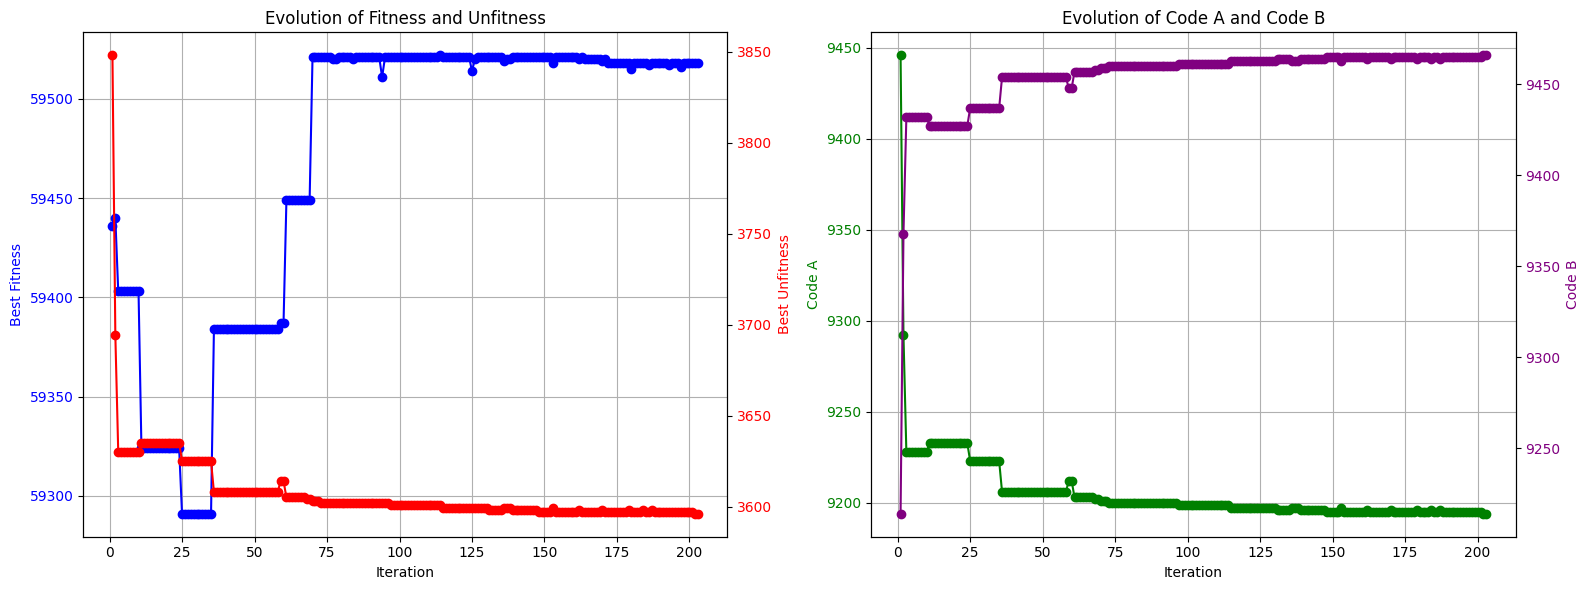


KeyboardInterrupt



In [26]:
# Run the Genetic Algorithm.
best_population, best_fitness_values, best_unfitness_values, comp_time = main(
    day=None,
    gene_space=gene_space,
    num_genes=num_genes,
    sol_per_pop=sol_per_pop,
    df=df,
    stock=stock,
    capacity_A=capacity_A,
    capacity_B=capacity_B,
    M=M,
    penalty_factor=penalty_factor
)

In [ ]:
print("Global Best Population:")
print(best_population)
print("Global Fitness Values:")
print(best_fitness_values)
print("Global Unfitness Values:")
print(best_unfitness_values)
print("Total Computational Time (sec):", comp_time)

# STATISTICS

In [ ]:
df = pd.merge(df, df_allocation, on='Articolo', how='left')
df

In [ ]:
df.groupby('Warehouse')['Articolo'].nunique()

In [ ]:
# Create a new column that contains the previous warehouse code within each order.
df['prev_warehouse'] = df.groupby('Num. Ordine')['Warehouse'].shift(1)

# Now create two boolean columns for the transitions:
df['transition_0_after_1'] = ((df['prev_warehouse'] == 1) & (df['Warehouse'] == 0)).astype(int)
df['transition_1_after_0'] = ((df['prev_warehouse'] == 0) & (df['Warehouse'] == 1)).astype(int)

# Group by 'Num. Ordine' and sum the transitions.
result = df.groupby('Num. Ordine')[['transition_0_after_1', 'transition_1_after_0']].sum()

result

In [ ]:
df[df['Num. Ordine'] == 714001]

In [ ]:
result.sum().sum()